# Household level analysis.
This notebook will look at tendencies at the household level in the data.

In [1]:
# Load in packages and data
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from typing import Tuple, List, Dict, Optional

from pathlib import Path

cwd = Path.cwd()

ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')
ll_df_aarhus = pd.read_csv(cwd / 'll_data' / 'll_aarhus.csv')
ll_df_odense = pd.read_csv(cwd / 'll_data' / 'll_odense.csv')

df_list = [ll_df_cph, ll_df_aarhus, ll_df_odense]
county_names = ['københavn', 'århus', 'odense']

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_47657/3333189222.py:15: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  ll_df_cph = pd.read_csv(cwd / 'll_data' / 'll_cph.csv')


In [2]:
def clean_household_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the household data by handling NA values appropriately
    
    Args:
        df: Raw census data DataFrame
    
    Returns:
        Cleaned DataFrame with standardized NA handling
    """
    cleaned_df = df.copy()
    
    # Replace NA values with appropriate strings
    string_columns = ['household_position', 'marital_status', 'sex', 'event_county']
    for col in string_columns:
        if col in cleaned_df.columns:
            cleaned_df[col] = cleaned_df[col].fillna('na')
    
    # Convert age to numeric, replacing NA with -1
    if 'age' in cleaned_df.columns:
        cleaned_df['age'] = pd.to_numeric(cleaned_df['age'], errors='coerce').fillna(-1)
    
    # Ensure household_id and event_year are not NA
    if cleaned_df['household_id'].isna().any() or cleaned_df['event_year'].isna().any():
        print("Warning: Found NA values in household_id or event_year. These rows will be dropped.")
        cleaned_df = cleaned_df.dropna(subset=['household_id', 'event_year'])
    
    return cleaned_df

def identify_extended_family(adults: pd.DataFrame, n_married: int, n_children: int) -> Tuple[bool, str]:
    """
    Identifies if a household is an extended family by analyzing age differences and adult relationships
    
    Args:
        adults: DataFrame containing adult members (age >= 15)
        n_married: Number of married adults
        n_children: Number of children in household
    
    Returns:
        Tuple of (is_extended: bool, reason: str)
    """
    if len(adults) < 2:
        return False, ""
    
    # Sort adults by age
    sorted_adults = adults.sort_values('age', ascending=False)
    ages = sorted_adults['age'].values
    
    # Calculate age differences between consecutive adults
    age_diffs = [ages[i] - ages[i+1] for i in range(len(ages)-1)]
    
    # Potential scenarios for extended families:
    
    # 1. Three or more adults with significant age gaps (potential three generations)
    if len(adults) >= 3:
        # Look for age gaps that could indicate different generations (>= 20 years)
        significant_gaps = [diff >= 20 for diff in age_diffs]
        if sum(significant_gaps) >= 1 and n_married >= 2:
            return True, "Multiple generations identified by age gaps"
    
    # 2. Elderly person(s) living with married couple
    if n_married >= 2:
        youngest_married = sorted_adults[sorted_adults['marital_status'].str.contains('gift', case=False, na=False)]['age'].min()
        oldest_adult = ages[0]
        if oldest_adult - youngest_married >= 20:
            return True, "Elderly person living with married couple"
    
    # 3. Multiple married couples with age difference
    if n_married >= 4:  # At least two couples
        married_adults = sorted_adults[sorted_adults['marital_status'].str.contains('gift', case=False, na=False)]
        if len(married_adults) >= 4:
            married_age_range = married_adults['age'].max() - married_adults['age'].min()
            if married_age_range >= 20:
                return True, "Multiple married couples with generational gap"
    
    # 4. Unmarried adults living with married couple and children
    if n_married >= 2 and n_children > 0 and len(adults) > 2:
        unmarried_adults = sorted_adults[~sorted_adults['marital_status'].str.contains('gift|enke', case=False, na=False)]
        if len(unmarried_adults) > 0:
            return True, "Additional unmarried adults in family household"
    
    return False, ""

def classify_household(household_df: pd.DataFrame) -> Tuple[int, str, str]:
    """
    Classifies a single household according to Laslett's categorization
    """
    # First identify and remove helpers
    has_helpers = household_df['household_position'].str.contains('tjeneste', case=False, na=False).any()
    non_helper_df = household_df[~household_df['household_position'].str.contains('tjeneste', case=False, na=False)]
    
    # Count household members (excluding helpers)
    n_members = len(non_helper_df)
    
    # Get demographic information
    adults = non_helper_df[non_helper_df['age'] >= 15]
    children = non_helper_df[non_helper_df['age'] < 15]
    married = adults['marital_status'].str.match('gift', case=False, na=False)
    widowed = adults['marital_status'].str.contains('enke', case=False, na=False)
    
    n_adults = len(adults)
    n_children = len(children)
    n_married = married.sum()
    n_widowed = widowed.sum()
    
    # Get gender distribution among adults
    adult_males = adults[adults['sex'].str.contains('m', case=False, na=False)]
    adult_females = adults[adults['sex'].str.contains('f|k', case=False, na=False)]
    
    # Helper suffix for description
    helper_suffix = " with helpers" if has_helpers else ""

    # Remove all of the biggest households
    if n_members > 15:
        return (7, '-', f'Indeterminate{helper_suffix}')
    
    # Single person households (Category 1)
    if n_members == 1:
        person = non_helper_df.iloc[0]
        if 'enke' in str(person['marital_status']).lower():
            return (1, 'a', f'Solitary - Widowed{helper_suffix}')
        return (1, 'b', f'Solitary - Unmarried{helper_suffix}')
    
    # Check for extended family before simple family
    is_extended, extension_reason = identify_extended_family(adults, n_married, n_children)
    if is_extended:
        return (4, 'a', f'Extended Family ({extension_reason}){helper_suffix}')
    
    # Simple Family Households (Category 3)
    if n_married == 2:  # Likely a married couple
        if n_children > 0:
            return (3, 'b', f'Simple Family - Married couple with children{helper_suffix}')
        return (3, 'a', f'Simple Family - Married couple alone{helper_suffix}')
    
    # Single parent families
    if n_widowed == 1 and n_children > 0:
        if len(adult_males) == 1 and adult_males['marital_status'].str.contains('enke', case=False, na=False).any():
            return (3, 'c', f'Simple Family - Widower with children{helper_suffix}')
        if len(adult_females) == 1 and adult_females['marital_status'].str.contains('enke', case=False, na=False).any():
            return (3, 'd', f'Simple Family - Widow with children{helper_suffix}')
    
    # No Family households (Category 2)
    if n_married == 0 and n_children == 0:
        if n_adults == 2:  # Check for possible siblings or relatives
            return (2, 'a', f'No Family - Coresident siblings/relatives{helper_suffix}')
        if n_adults > 2:
            return (2, 'c', f'No Family - Coresident persons{helper_suffix}')
    
    # Multiple Family Households (Category 5)
    if n_married >= 4:  # Two or more possible couples
        return (5, 'a', f'Multiple Family{helper_suffix}')
    
    # If we still can't determine with confidence
    return (6, '-', f'Indeterminate{helper_suffix}')

def analyze_households(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes all households in a dataframe and returns their Laslett categories
    
    Args:
        df: Census data DataFrame
    
    Returns:
        DataFrame with household classifications
    """
    cleaned_df = clean_household_data(df)
    results: List[Dict] = []
    
    for household_id, household_df in cleaned_df.groupby('household_id'):
        try:
            category, subcategory, description = classify_household(household_df)

            if category == 7:
                continue
            
            event_year = household_df['event_year'].iloc[0]
            event_county = household_df['event_county'].iloc[0]
            
            results.append({
                'household_id': household_id,
                'category': category,
                'subcategory': subcategory,
                'description': description,
                'event_year': event_year,
                'event_county': event_county,
                'household_size': len(household_df),
                'has_helpers': 'helpers' in description.lower()
            })
        except Exception as e:
            print(f"Warning: Error processing household {household_id}: {str(e)}")
            continue
    
    return pd.DataFrame(results)

def print_detailed_statistics(classified_df: pd.DataFrame) -> None:
    """
    Prints detailed tables for each county showing household types over time,
    split by helper status
    
    Args:
        classified_df: DataFrame containing the classified households
    """
    counties = classified_df['event_county'].unique()
    
    for county in counties:
        print(f"\n{county} Household Distribution")
        print("=" * 80)
        
        county_data = classified_df[classified_df['event_county'] == county]
        years = sorted(county_data['event_year'].unique())
        
        # Create pivot table for this county
        for has_helper in [False, True]:
            helper_status = "with helpers" if has_helper else "without helpers"
            print(f"\nHouseholds {helper_status}:")
            print("-" * 80)
            
            # Filter data by helper status
            helper_data = county_data[county_data['has_helpers'] == has_helper]
            
            # Create pivot table
            pivot = pd.pivot_table(
                helper_data,
                values='household_id',
                index='event_year',
                columns='category',
                aggfunc='count',
                fill_value=0
            )
            
            # Calculate percentages
            pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
            
            # Ensure all categories are present
            for cat in range(1, 7):
                if cat not in pivot_pct.columns:
                    pivot_pct[cat] = 0
            
            pivot_pct = pivot_pct.sort_index(axis=1)
            
            # Add total count column
            pivot_pct['Total Count'] = pivot.sum(axis=1)
            
            # Format the table
            formatted_table = pivot_pct.round(1)
            formatted_table.columns = ['1: Solitaries', '2: No Family', '3: Simple Family',
                                     '4: Extended Family', '5: Multiple Family', 
                                     '6: Indeterminate', 'Total Count']
            
            print(formatted_table.to_string(float_format=lambda x: f'{x:,.1f}%' if x != formatted_table['Total Count'].iloc[0] else f'{int(x):,}'))

def plot_detailed_household_distribution(classified_df: pd.DataFrame) -> Tuple[plt.Figure, plt.Figure]:
    """
    Creates two sets of bar plots for each county:
    1. Basic household type distribution
    2. Detailed distribution including helper status
    
    Args:
        classified_df: DataFrame containing the classified households
    
    Returns:
        Tuple of (basic_figure, detailed_figure)
    """
    counties = classified_df['event_county'].unique()
    n_counties = len(counties)
    
    # Create two figures
    basic_fig, basic_axes = plt.subplots(n_counties, 1, figsize=(15, 6*n_counties))
    detailed_fig, detailed_axes = plt.subplots(n_counties, 1, figsize=(15, 6*n_counties))
    
    if n_counties == 1:
        basic_axes = [basic_axes]
        detailed_axes = [detailed_axes]
    
    # Color palettes
    basic_colors = sns.color_palette("husl", n_colors=6)
    detailed_colors = sns.color_palette("husl", n_colors=12)  # Double for with/without helpers
    
    category_labels = ['Solitaries', 'No Family', 'Simple Family',
                      'Extended Family', 'Multiple Family', 'Indeterminate']
    
    for idx, county in enumerate(counties):
        county_data = classified_df[classified_df['event_county'] == county]
        
        # Basic plot (without helper distinction)
        plot_data_basic = pd.pivot_table(
            county_data,
            index='event_year',
            columns='category',
            values='household_id',
            aggfunc='count',
            fill_value=0
        )
        plot_data_basic = plot_data_basic.div(plot_data_basic.sum(axis=1), axis=0) * 100
        
        # Ensure all categories are present
        for cat in range(1, 7):
            if cat not in plot_data_basic.columns:
                plot_data_basic[cat] = 0
        plot_data_basic = plot_data_basic.sort_index(axis=1)
        
        # Plot basic distribution
        plot_data_basic.plot(
            kind='bar',
            ax=basic_axes[idx],
            color=basic_colors,
            width=0.8
        )
        
        # Customize basic plot
        basic_axes[idx].set_title(f'Household Types Distribution in {county}', pad=20)
        basic_axes[idx].set_xlabel('Census Year')
        basic_axes[idx].set_ylabel('Percentage of Households')
        basic_axes[idx].legend(
            title='Household Categories',
            labels=[f'{i+1}: {label}' for i, label in enumerate(category_labels)],
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        basic_axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.setp(basic_axes[idx].get_xticklabels(), rotation=45, ha='right')
        
        # Detailed plot (with helper distinction)
        detailed_data = []
        for has_helper in [False, True]:
            helper_data = county_data[county_data['has_helpers'] == has_helper]
            pivot = pd.pivot_table(
                helper_data,
                index='event_year',
                columns='category',
                values='household_id',
                aggfunc='count',
                fill_value=0
            )
            # Add helper status to column names
            suffix = ' (with helpers)' if has_helper else ' (no helpers)'
            pivot.columns = [f'{col}{suffix}' for col in pivot.columns]
            detailed_data.append(pivot)
        
        plot_data_detailed = pd.concat(detailed_data, axis=1)
        plot_data_detailed = plot_data_detailed.div(plot_data_detailed.sum(axis=1), axis=0) * 100
        
        # Plot detailed distribution
        plot_data_detailed.plot(
            kind='bar',
            ax=detailed_axes[idx],
            color=detailed_colors,
            width=0.8
        )
        
        # Customize detailed plot
        detailed_axes[idx].set_title(f'Detailed Household Types Distribution in {county}', pad=20)
        detailed_axes[idx].set_xlabel('Census Year')
        detailed_axes[idx].set_ylabel('Percentage of Households')
        detailed_axes[idx].legend(
            bbox_to_anchor=(1.05, 1),
            loc='upper left'
        )
        detailed_axes[idx].grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.setp(detailed_axes[idx].get_xticklabels(), rotation=45, ha='right')
    
    basic_fig.tight_layout()
    detailed_fig.tight_layout()
    
    return basic_fig, detailed_fig

def print_yearly_statistics(classified_df: pd.DataFrame) -> None:
    """
    Prints yearly tables for each county showing household types, with color coding
    for changes in relative frequencies.
    """
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)

    counties = classified_df['event_county'].unique()
    category_names = {
    1: 'Solitaries',
    2: 'No Family',
    3: 'Simple Family',
    4: 'Extended Family',
    5: 'Multiple Family',
    6: 'Indeterminate'
    }

    def color_changes(val, prev_val):
        if pd.isna(prev_val):
            return ''
        if isinstance(val, str):  # For the actual values column
            return ''
        change = val - prev_val
        if abs(change) < 0.1:  # Threshold for considering change significant
            return ''
        # Calculate color intensity based on magnitude of change
        intensity = min(abs(change) * 10, 255)  # Scale change to color intensity
        if change > 0:
            return f'background-color: rgba(0,255,0,{intensity/255})'
        return f'background-color: rgba(255,0,0,{intensity/255})'

    for county in counties:
        print(f"\n{county} Household Distribution")
        print("=" * 80)
    
    county_data = classified_df[classified_df['event_county'] == county]
    years = sorted(county_data['event_year'].unique())
    
    # Create yearly tables
    for year in years:
        year_data = county_data[county_data['event_year'] == year]
        
        # Calculate frequencies
        type_counts = year_data['category'].value_counts()
        total_households = len(year_data)
        
        # Create frequency table
        freq_data = []
        for cat in range(1, 7):
            count = type_counts.get(cat, 0)
            freq = (count / total_households) * 100
            freq_data.append({
                'Category': f"{cat}: {category_names[cat]}",
                'Count': count,
                'Frequency (%)': round(freq, 1)
            })
        
        year_df = pd.DataFrame(freq_data)
        year_df.loc['Total'] = ['Total', total_households, 100.0]
        
        # Get previous year's data for color coding
        if year != years[0]:
            prev_year_data = county_data[county_data['event_year'] == years[years.index(year)-1]]
            prev_freqs = prev_year_data['category'].value_counts(normalize=True) * 100
            prev_year_df = pd.DataFrame([{'Category': f"{cat}: {category_names[cat]}", 
                                        'Frequency (%)': prev_freqs.get(cat, 0)}
                                        for cat in range(1, 7)])
            
            # Apply color styling
            styled_df = year_df.style.apply(lambda x: [color_changes(x['Frequency (%)'], 
                                                                    prev_year_df['Frequency (%)'].get(i, None))
                                                        for i in range(len(x))], axis=1)
        else:
            styled_df = year_df
        
        print(f"\nYear: {year}")
        print("-" * 80)
        display(styled_df)

def create_summary_table(classified_df: pd.DataFrame) -> None:
    """
    Creates a summary table showing the overall development of household structures.
    """
    counties = classified_df['event_county'].unique()
    category_names = {
        1: 'Solitaries',
        2: 'No Family',
        3: 'Simple Family',
        4: 'Extended Family',
        5: 'Multiple Family',
        6: 'Indeterminate'
    }
    
    for county in counties:
        print(f"\n{county} Summary of Changes")
        print("=" * 80)
        
        county_data = classified_df[classified_df['event_county'] == county]
        years = sorted(county_data['event_year'].unique())
        
        # Calculate frequencies for each year
        summary_data = {}
        for year in years:
            year_data = county_data[county_data['event_year'] == year]
            freqs = year_data['category'].value_counts(normalize=True) * 100
            summary_data[year] = freqs
        
        # Create summary DataFrame
        summary_df = pd.DataFrame(summary_data).round(1)
        summary_df = summary_df.reindex(range(1, 7))
        summary_df.index = [f"{i}: {category_names[i]}" for i in range(1, 7)]
        
        # Calculate total change and average change
        total_change = summary_df[years[-1]] - summary_df[years[0]]
        avg_annual_change = total_change / (len(years) - 1)
        
        summary_df['Total Change'] = total_change.round(1)
        summary_df['Avg Annual Change'] = avg_annual_change.round(2)
        
        # Color code the changes
        def color_change(val):
            if pd.isna(val):
                return ''
            if isinstance(val, str):
                return ''
            intensity = min(abs(val) * 10, 255)
            if val > 0:
                return f'background-color: rgba(0,255,0,{intensity/255})'
            if val < 0:
                return f'background-color: rgba(255,0,0,{intensity/255})'
            return ''
        
        styled_summary = summary_df.style.applymap(color_change, subset=['Total Change', 'Avg Annual Change'])
        display(styled_summary)

# Replace the print_detailed_statistics and plot_detailed_household_distribution functions with:
def analyze_and_display_results(classified_df: pd.DataFrame) -> None:
    """
    Main function to analyze and display the results
    """
    print_yearly_statistics(classified_df)
    print("\nSummary Tables")
    print("=" * 80)
    create_summary_table(classified_df)


odense Household Distribution

Households without helpers:
--------------------------------------------------------------------------------
            1: Solitaries  2: No Family  3: Simple Family  4: Extended Family  5: Multiple Family  6: Indeterminate  Total Count
event_year                                                                                                                      
1787                 5.0%          5.5%             39.0%               41.4%                0.5%              8.7%         8629
1801                 3.6%          4.1%             40.9%               46.9%                0.3%              4.3%        10783
1834                 3.2%          4.3%             39.1%               46.7%                1.0%              5.7%        11121
1840                 5.2%          5.0%             39.3%               44.0%                0.7%              5.8%        11550
1845                 5.3%          5.8%             38.3%               44.3%        

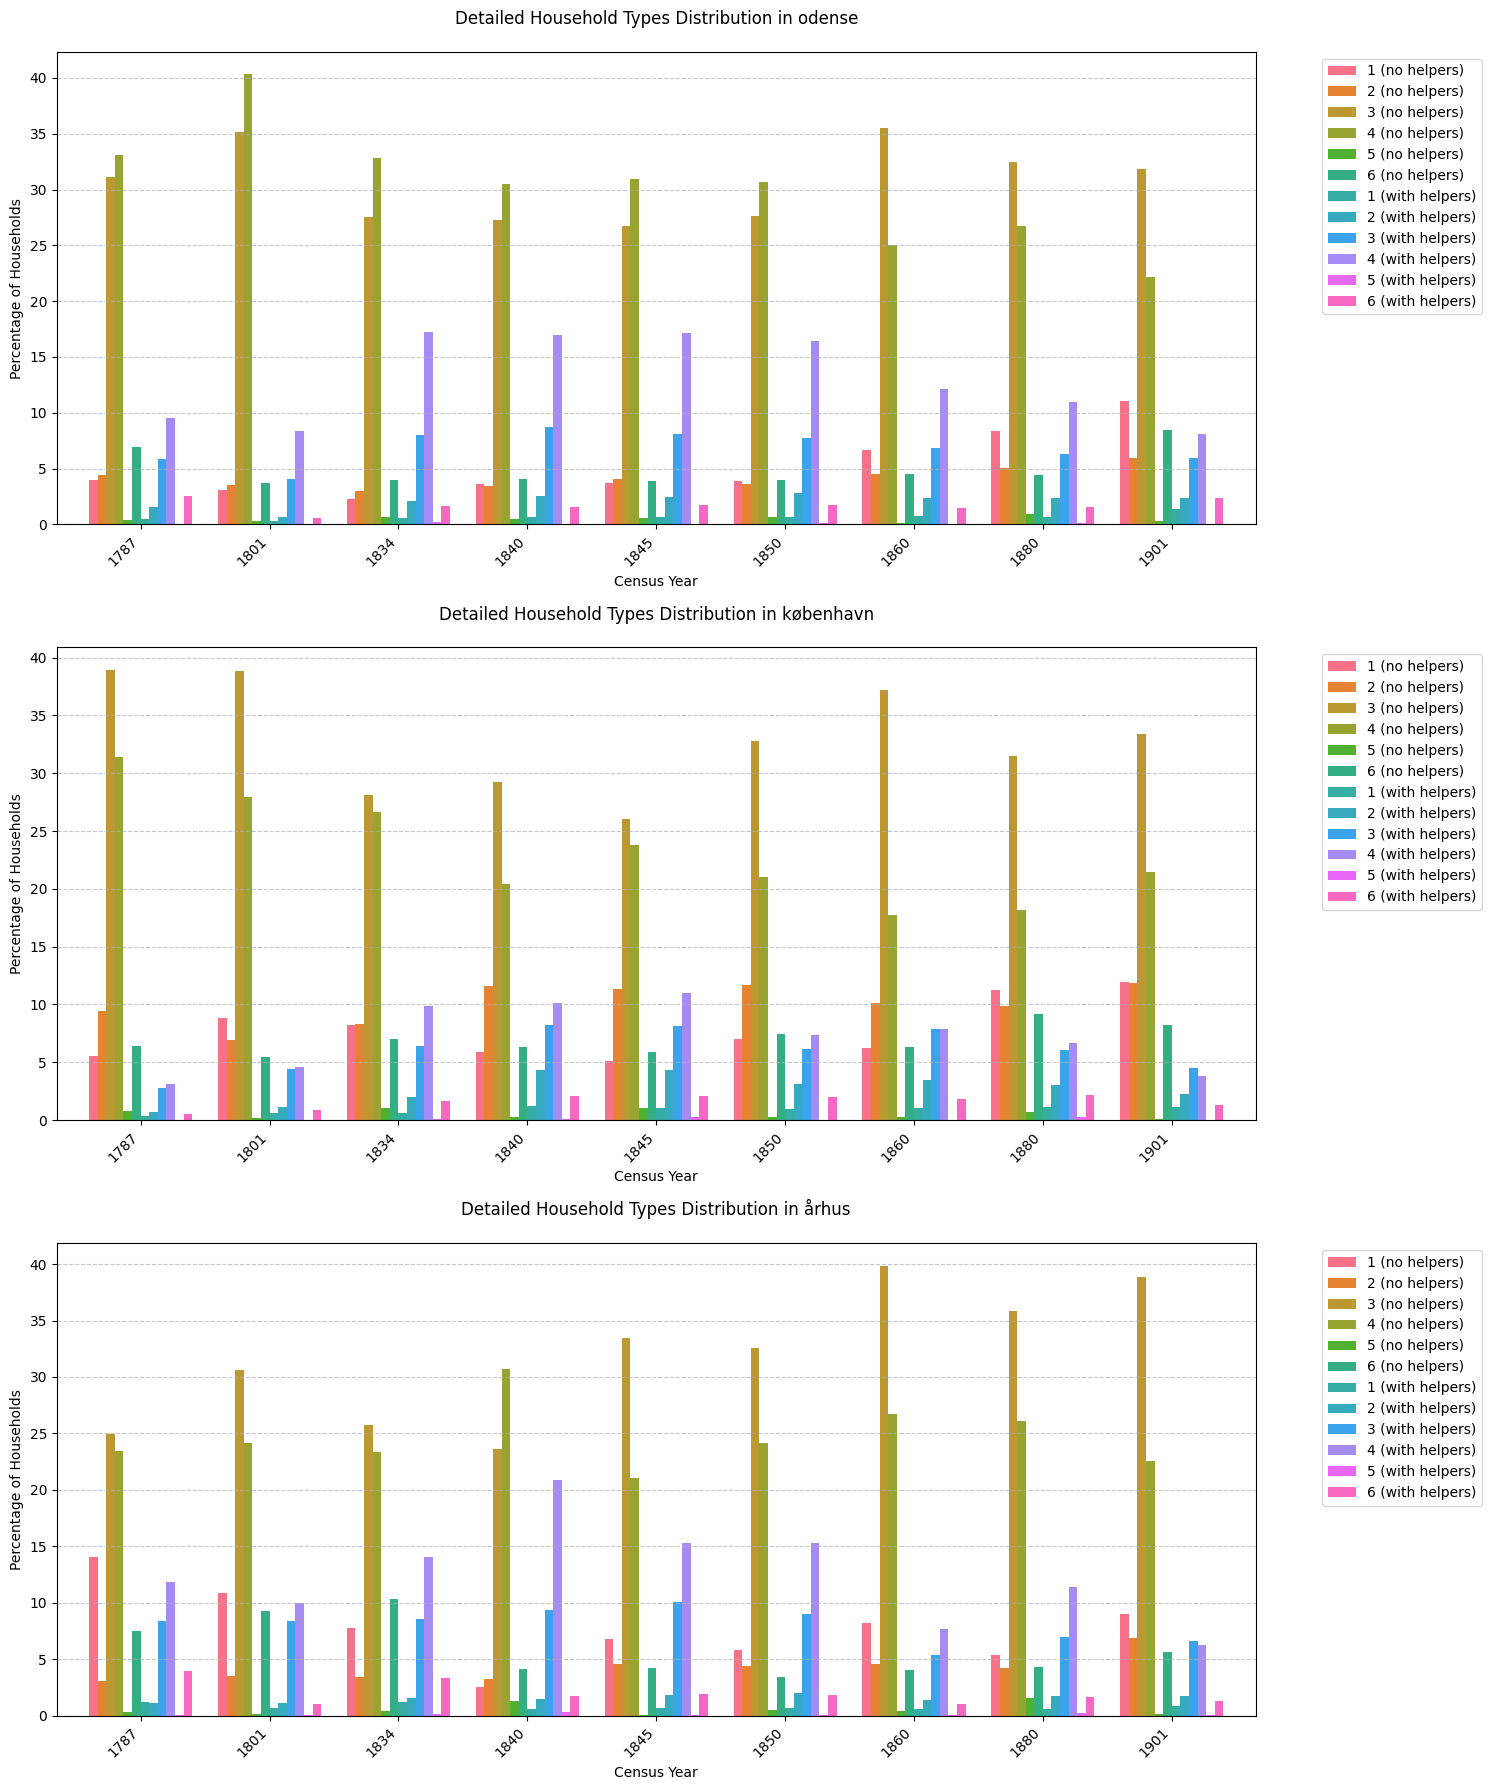

In [3]:
# First combine all dataframes
combined_df = pd.concat([ll_df_odense, ll_df_cph, ll_df_aarhus], ignore_index=True)

# Analyze households
classified_households = analyze_households(combined_df)

# Print detailed tables
print_detailed_statistics(classified_households)

# Create visualizations
basic_fig, detailed_fig = plot_detailed_household_distribution(classified_households)
plt.show()


Absolute changes in household types between census years:
category    Solitaries  No Family  Simple Family  Extended Family  \
event_year                                                          
1787               NaN        NaN            NaN              NaN   
1801            1093.0     -251.0         1648.0            529.0   
1840            -271.0     2735.0          211.0            858.0   
1845            -474.0     -510.0        -1956.0            288.0   
1850            1129.0      932.0         4299.0            462.0   
1860             377.0      795.0         6138.0           1300.0   
1880            5072.0     2593.0         5374.0           5369.0   
1901            9135.0    10224.0        25410.0          17041.0   

category    Multiple Family  Indeterminate  
event_year                                  
1787                    NaN            NaN  
1801                 -107.0           52.0  
1840                   45.0          920.0  
1845                  249

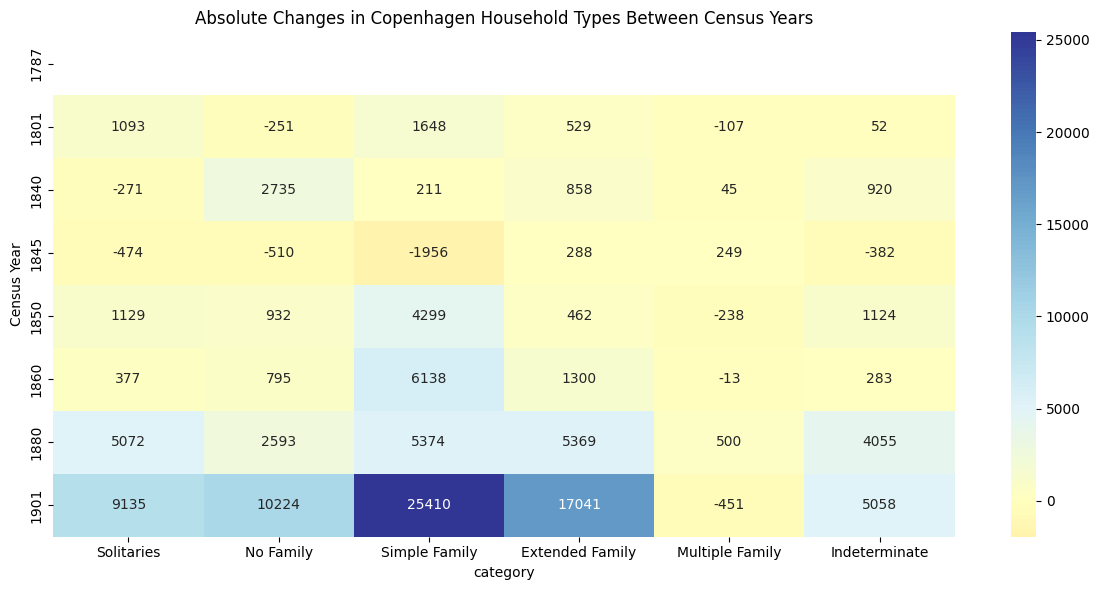

In [4]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_absolute_household_changes(df: pd.DataFrame) -> pd.DataFrame:
   """
   Calculate absolute changes in household types between census years for Copenhagen,
   excluding 1834 due to data quality issues
   
   Args:
       df: Census DataFrame for Copenhagen
       
   Returns:
       DataFrame with absolute changes in household types
   """
   # Clean and classify households 
   classified_df = analyze_households(df)
   
   # Filter for Copenhagen and remove 1834
   cph_data = classified_df[
       (classified_df['event_county'] == 'københavn') & 
       (classified_df['event_year'] != 1834)
   ]
   
   # Get counts by year and category
   yearly_counts = pd.pivot_table(
       cph_data,
       values='household_id',
       index='event_year',
       columns='category',
       aggfunc='count',
       fill_value=0
   )
   
   # Calculate absolute changes
   changes = yearly_counts.diff()
   
   # Rename columns
   category_names = {
       1: 'Solitaries',
       2: 'No Family',
       3: 'Simple Family', 
       4: 'Extended Family',
       5: 'Multiple Family',
       6: 'Indeterminate'
   }
   changes = changes.rename(columns=category_names)
   
   return changes

# Calculate changes
changes_df = get_absolute_household_changes(ll_df_cph)

# Visualize
plt.figure(figsize=(12, 6))
sns.heatmap(changes_df, cmap='RdYlBu', center=0, annot=True, fmt='.0f')
plt.title('Absolute Changes in Copenhagen Household Types Between Census Years')
plt.ylabel('Census Year')
plt.tight_layout()

# Display numeric results
print("\nAbsolute changes in household types between census years:")
print(changes_df)

In [5]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_growth_distribution(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate each household type's share of total household growth between census years
    for Copenhagen, excluding 1834. Handles negative growth by separating positive and 
    negative changes.
    
    For years with both positive and negative changes:
    - Positive changes are shown as % of total positive change
    - Negative changes are shown as % of total negative change
    - This creates a clear distinction between growing and shrinking household types
    """
    classified_df = analyze_households(df)
    
    cph_data = classified_df[
        (classified_df['event_county'] == 'københavn') & 
        (classified_df['event_year'] != 1834)
    ]
    
    # Get counts and calculate absolute changes
    yearly_counts = pd.pivot_table(
        cph_data,
        values='household_id',
        index='event_year',
        columns='category',
        aggfunc='count',
        fill_value=0
    )
    changes = yearly_counts.diff()
    
    # Calculate percentage distribution separately for positive and negative changes
    growth_dist = pd.DataFrame(index=changes.index, columns=changes.columns)
    
    for year in changes.index:
        year_changes = changes.loc[year]
        
        # Handle positive changes
        pos_changes = year_changes[year_changes > 0]
        if not pos_changes.empty:
            pos_total = pos_changes.sum()
            growth_dist.loc[year, pos_changes.index] = (pos_changes / pos_total) * 100
            
        # Handle negative changes
        neg_changes = year_changes[year_changes < 0]
        if not neg_changes.empty:
            neg_total = abs(neg_changes.sum())
            growth_dist.loc[year, neg_changes.index] = (neg_changes / neg_total) * 100
    
    category_names = {
        1: 'Solitaries',
        2: 'No Family',
        3: 'Simple Family', 
        4: 'Extended Family',
        5: 'Multiple Family',
        6: 'Indeterminate'
    }
    growth_dist = growth_dist.rename(columns=category_names)
    
    return growth_dist

growth_df = get_growth_distribution(ll_df_cph)

# We try too look a the solitaries as a group, since these are weirdly over represented

In [6]:
def analyze_solitaries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes characteristics of solitary households across time and counties
    """
    cleaned_df = clean_household_data(df)
    results = []
    
    for (county, year), group in cleaned_df.groupby(['event_county', 'event_year']):
        households = group.groupby('household_id')
        solitaries = [hh for _, hh in households if len(hh) == 1]
        
        if not solitaries:
            continue
            
        solitary_df = pd.concat(solitaries)
        total_count = len(solitary_df)
        
        # Calculate helper status
        helper_count = solitary_df['household_position'].str.contains('tjeneste', case=False, na=False).sum()
        helper_ratio = helper_count / total_count * 100
        
        # Original metrics
        gender_counts = solitary_df['sex'].str.lower().value_counts()
        male_ratio = gender_counts.get('m', 0) / total_count * 100
        female_ratio = 100 - male_ratio
        mean_age = solitary_df['age'].mean()
        widow_count = solitary_df['marital_status'].str.contains('enke', case=False, na=False).sum()
        widow_ratio = widow_count / total_count * 100
        
        results.append({
            'county': county,
            'year': year,
            'total_solitaries': total_count,
            'male_ratio': male_ratio,
            'female_ratio': female_ratio,
            'mean_age': mean_age,
            'widow_ratio': widow_ratio,
            'helper_ratio': helper_ratio
        })
    
    return pd.DataFrame(results).sort_values(['county', 'year'])

# Create and display analysis
solitary_stats = analyze_solitaries(combined_df)

for county in solitary_stats['county'].unique():
    county_data = solitary_stats[solitary_stats['county'] == county].copy()
    
    # Round numerical columns
    numeric_columns = ['male_ratio', 'female_ratio', 'mean_age', 'widow_ratio', 'helper_ratio']
    county_data[numeric_columns] = county_data[numeric_columns].round(1)
    
    print(f"\n{county} Solitary Household Characteristics")
    print("=" * 80)
    print(county_data.to_string(index=False))


københavn Solitary Household Characteristics
   county  year  total_solitaries  male_ratio  female_ratio  mean_age  widow_ratio  helper_ratio
københavn  1787              1265        46.6          53.4      45.8         41.4           0.6
københavn  1801              2282        42.9          57.1      54.2         72.4           0.4
københavn  1834               887        55.7          44.3      39.0         26.2           0.6
københavn  1840              1800        44.1          55.9      46.1         41.9           0.7
københavn  1845              1424        50.0          50.0      46.8         39.0           2.0
københavn  1850              2505        41.9          58.1      47.6         39.9           1.4
københavn  1860              2759        42.8          57.2      48.5         40.1           1.3
københavn  1880              7695        43.8          56.2      42.7         32.0           2.3
københavn  1901             16175        37.2          62.8      46.7         31.

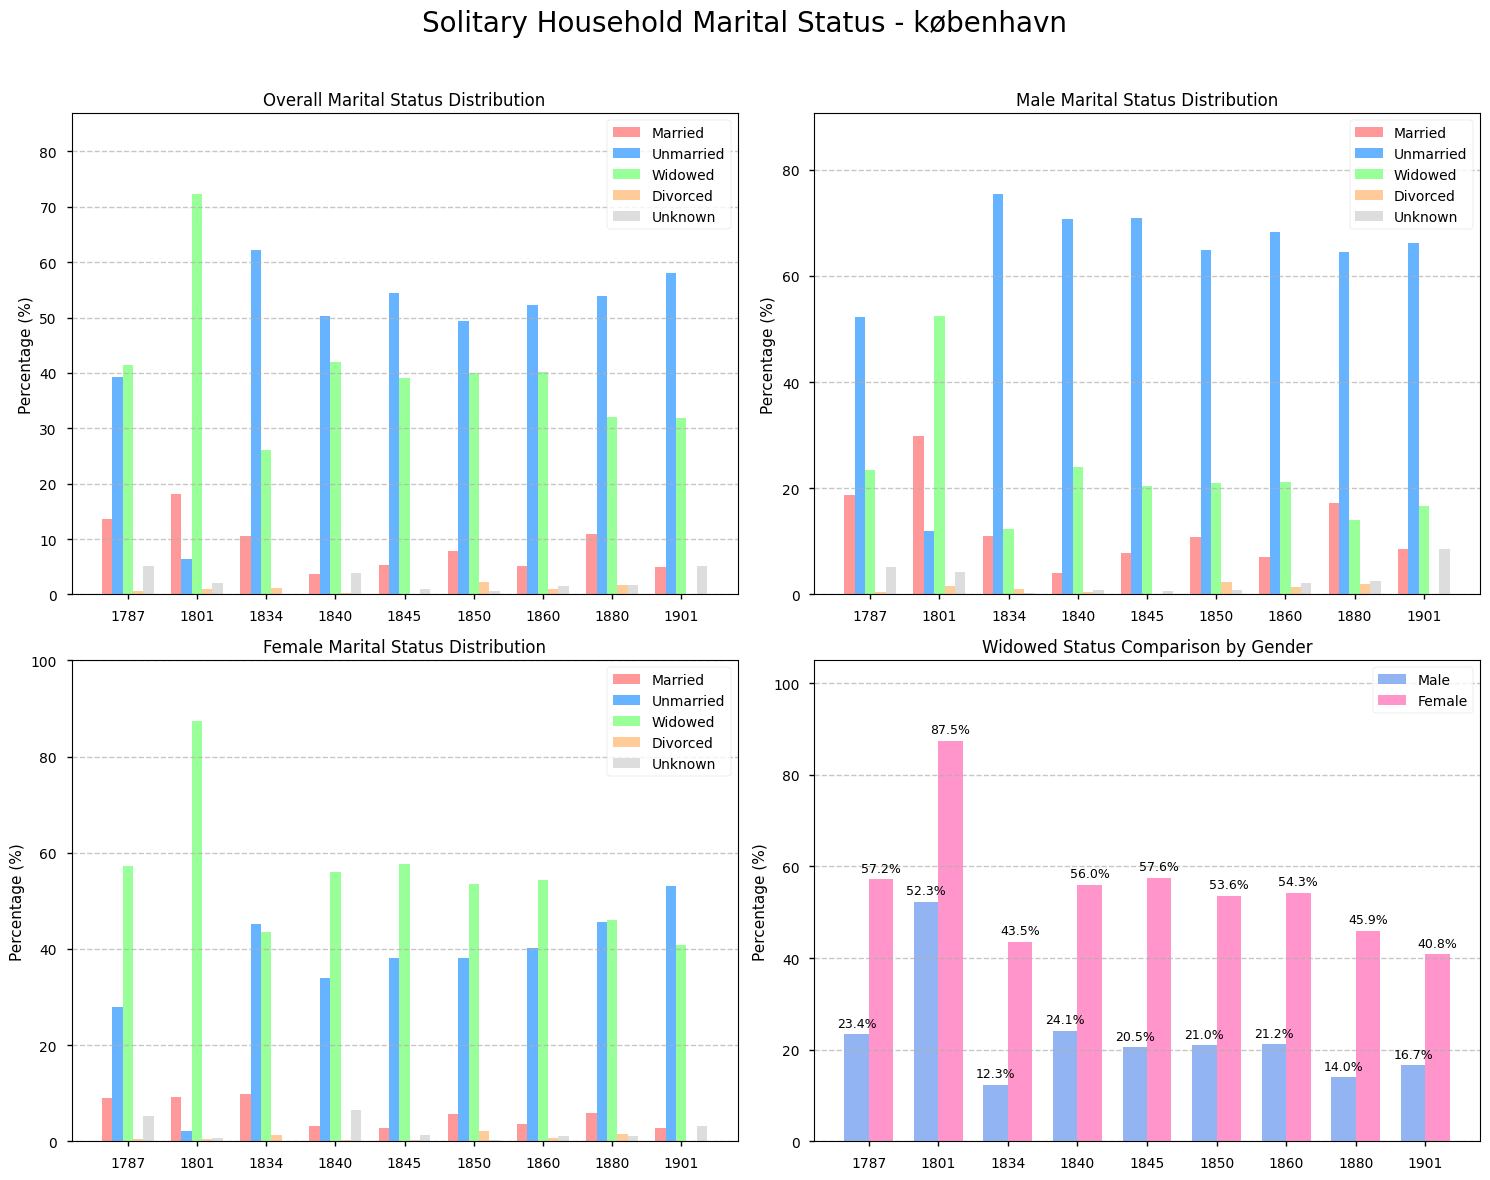

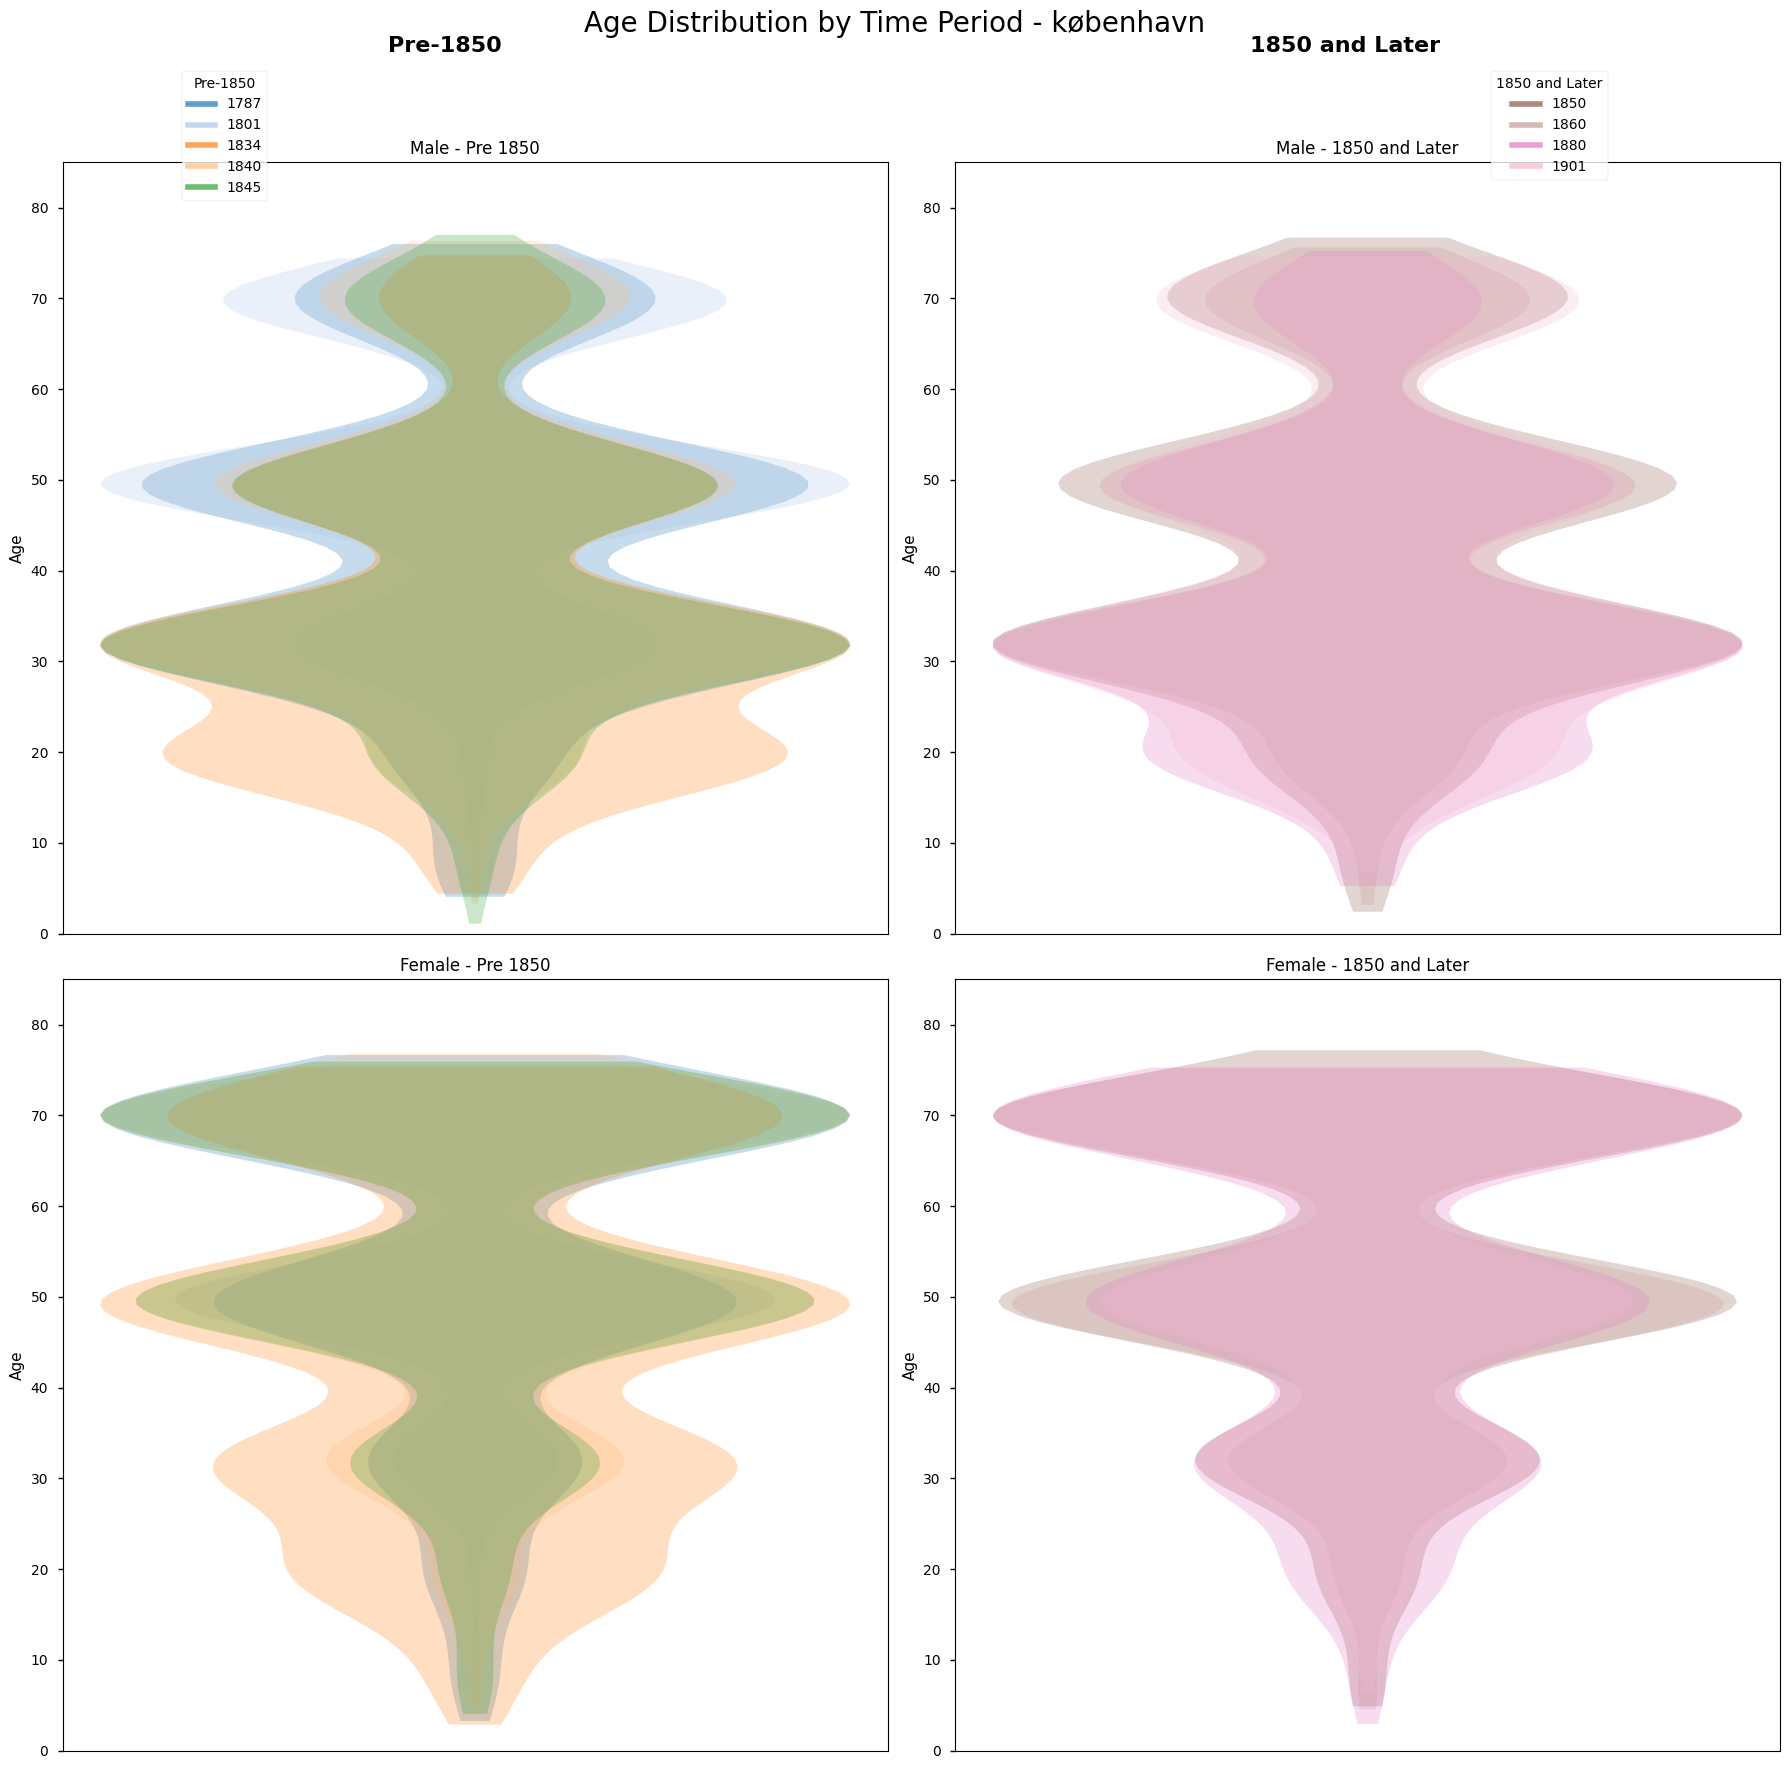


københavn Solitary Household Characteristics
 year  total_solitaries  male_ratio  female_ratio  mean_age  male_mean_age  female_mean_age  helper_ratio  male_helper_ratio  female_helper_ratio
 1787              1265        46.6          53.4      45.8           40.0             50.9           0.6                0.0                  1.0
 1801              2282        42.9          57.1      54.2           49.6             57.6           0.4                0.8                  0.2
 1834               887        55.7          44.3      39.0           34.0             45.3           0.6                0.4                  0.8
 1840              1800        44.1          55.9      46.1           41.4             49.7           0.7                0.9                  0.6
 1845              1424        50.0          50.0      46.8           40.2             53.4           2.0                1.5                  2.4
 1850              2505        41.9          58.1      47.6           42.0    

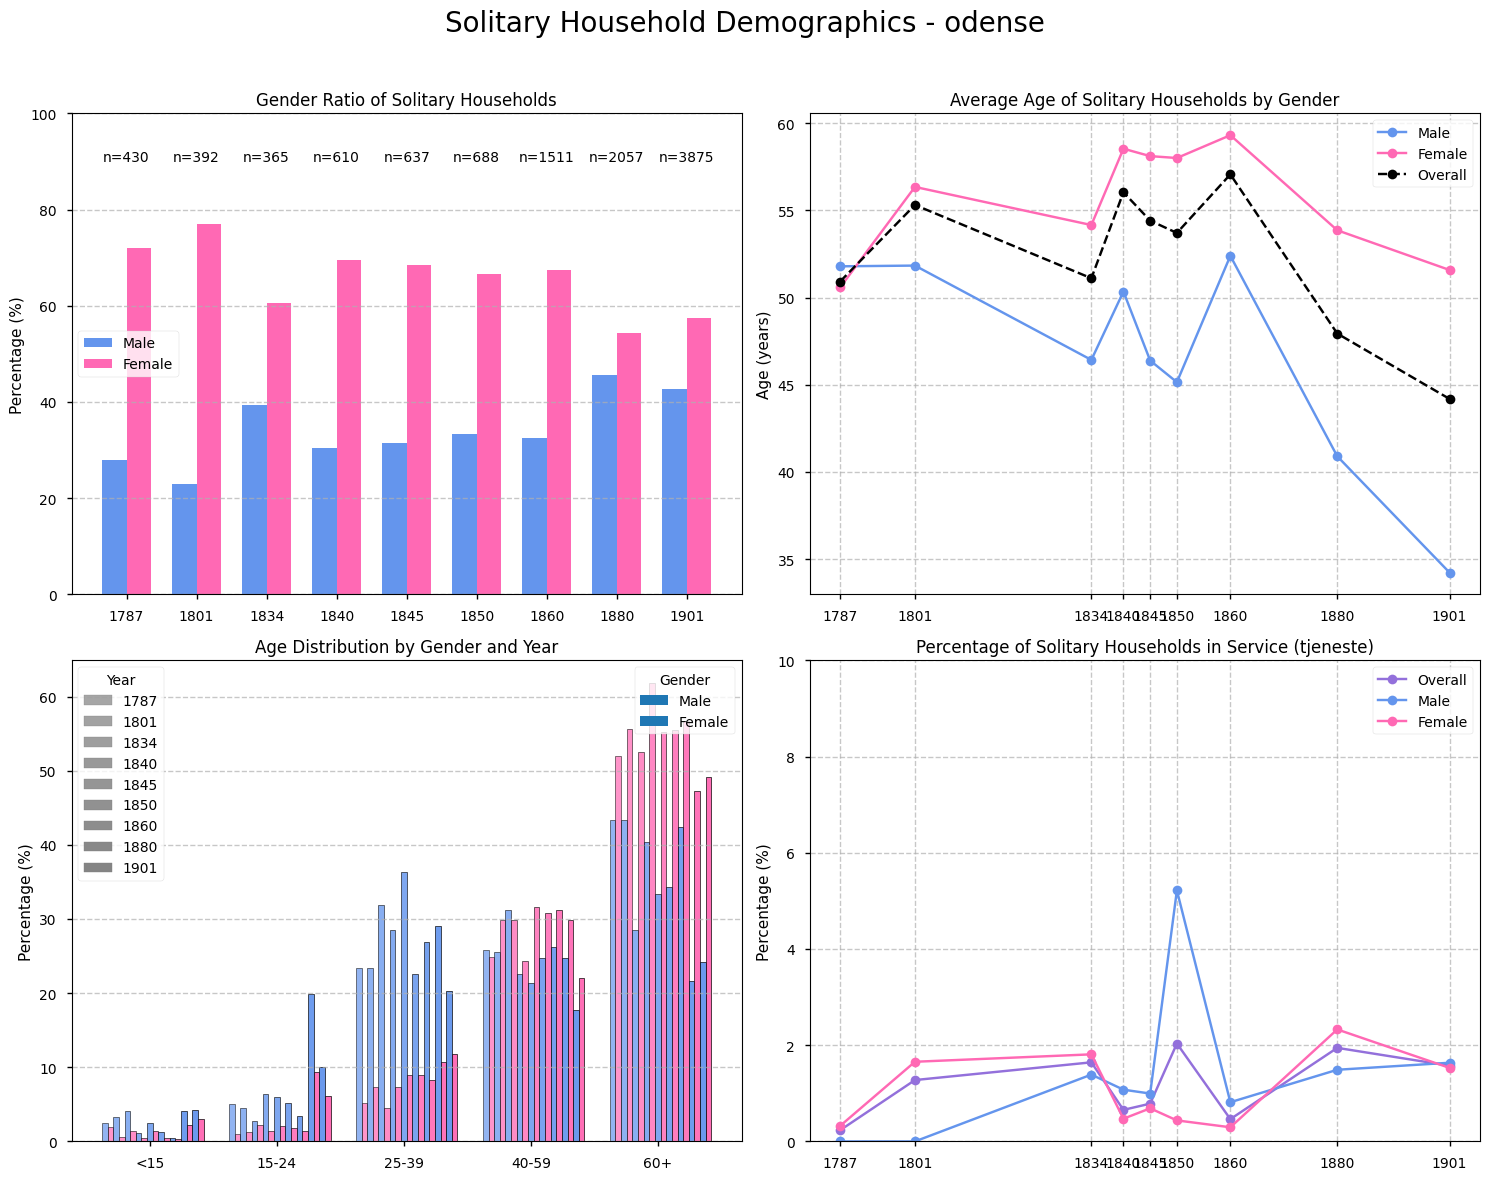

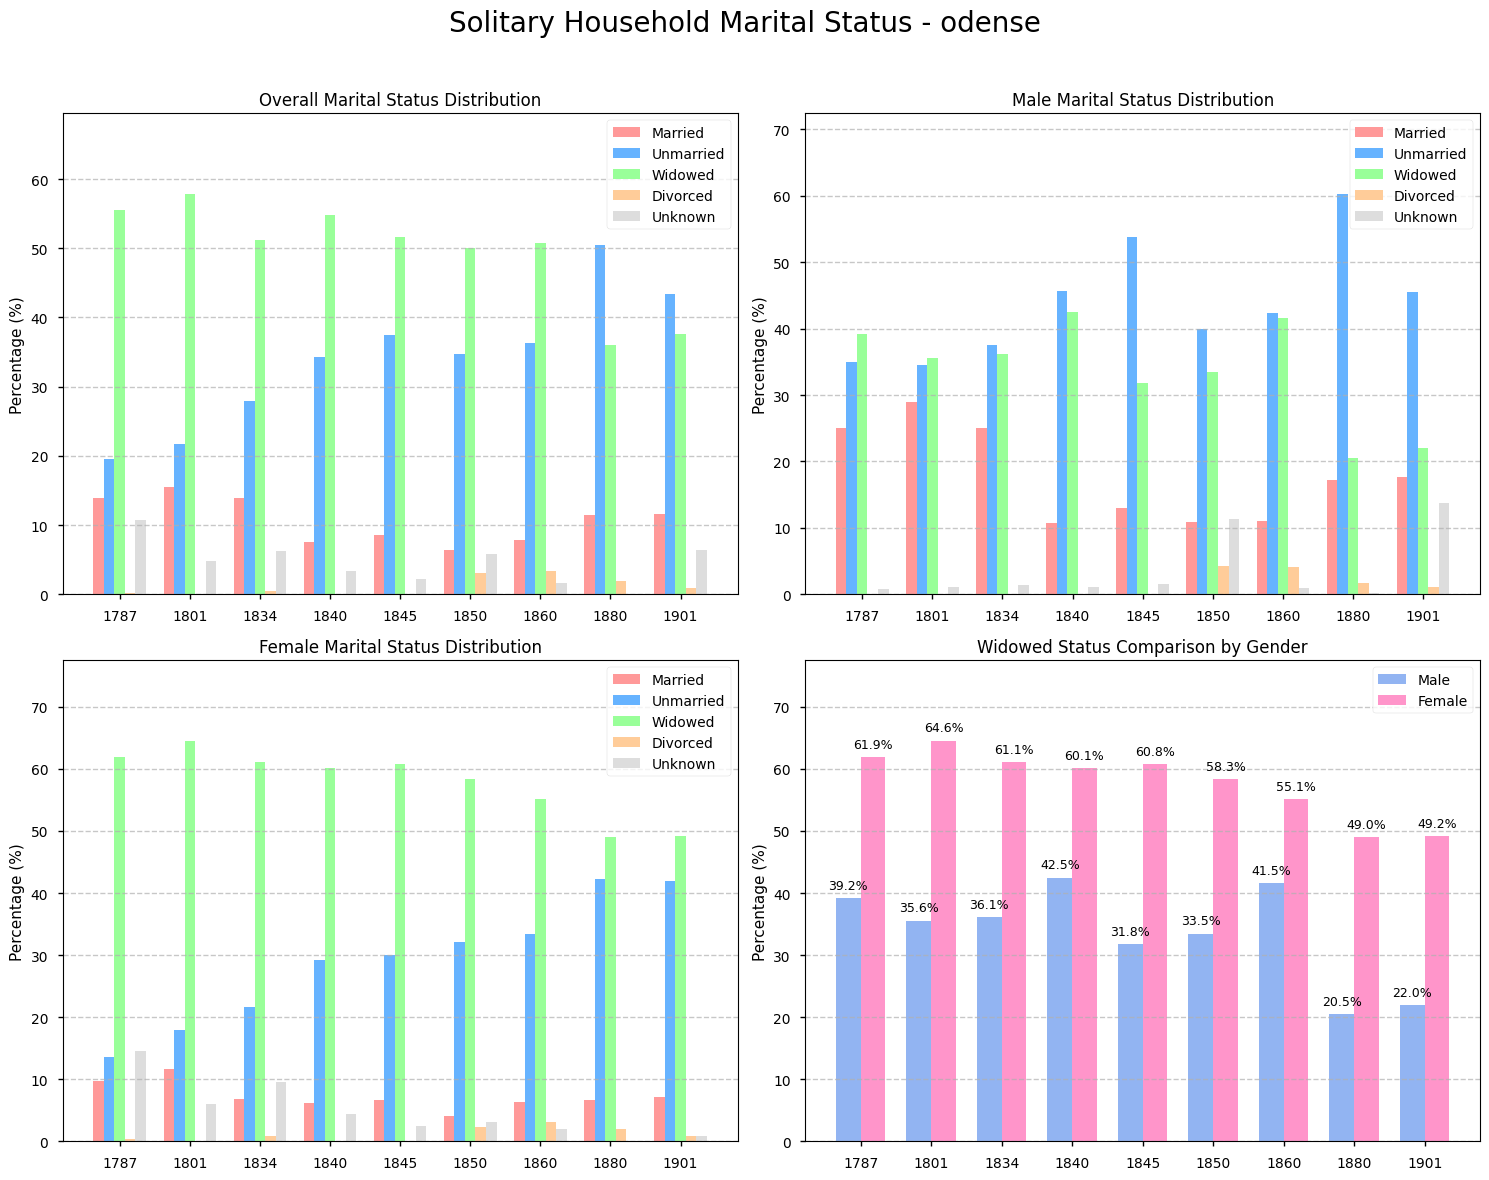


odense Solitary Household Characteristics
 year  total_solitaries  male_ratio  female_ratio  mean_age  male_mean_age  female_mean_age  helper_ratio  male_helper_ratio  female_helper_ratio
 1787               430        27.9          72.1      50.9           51.8             50.6           0.2                0.0                  0.3
 1801               392        23.0          77.0      55.3           51.8             56.3           1.3                0.0                  1.7
 1834               365        39.5          60.5      51.1           46.4             54.2           1.6                1.4                  1.8
 1840               610        30.5          69.5      56.0           50.3             58.5           0.7                1.1                  0.5
 1845               637        31.6          68.4      54.4           46.4             58.1           0.8                1.0                  0.7
 1850               688        33.4          66.6      53.7           45.1       

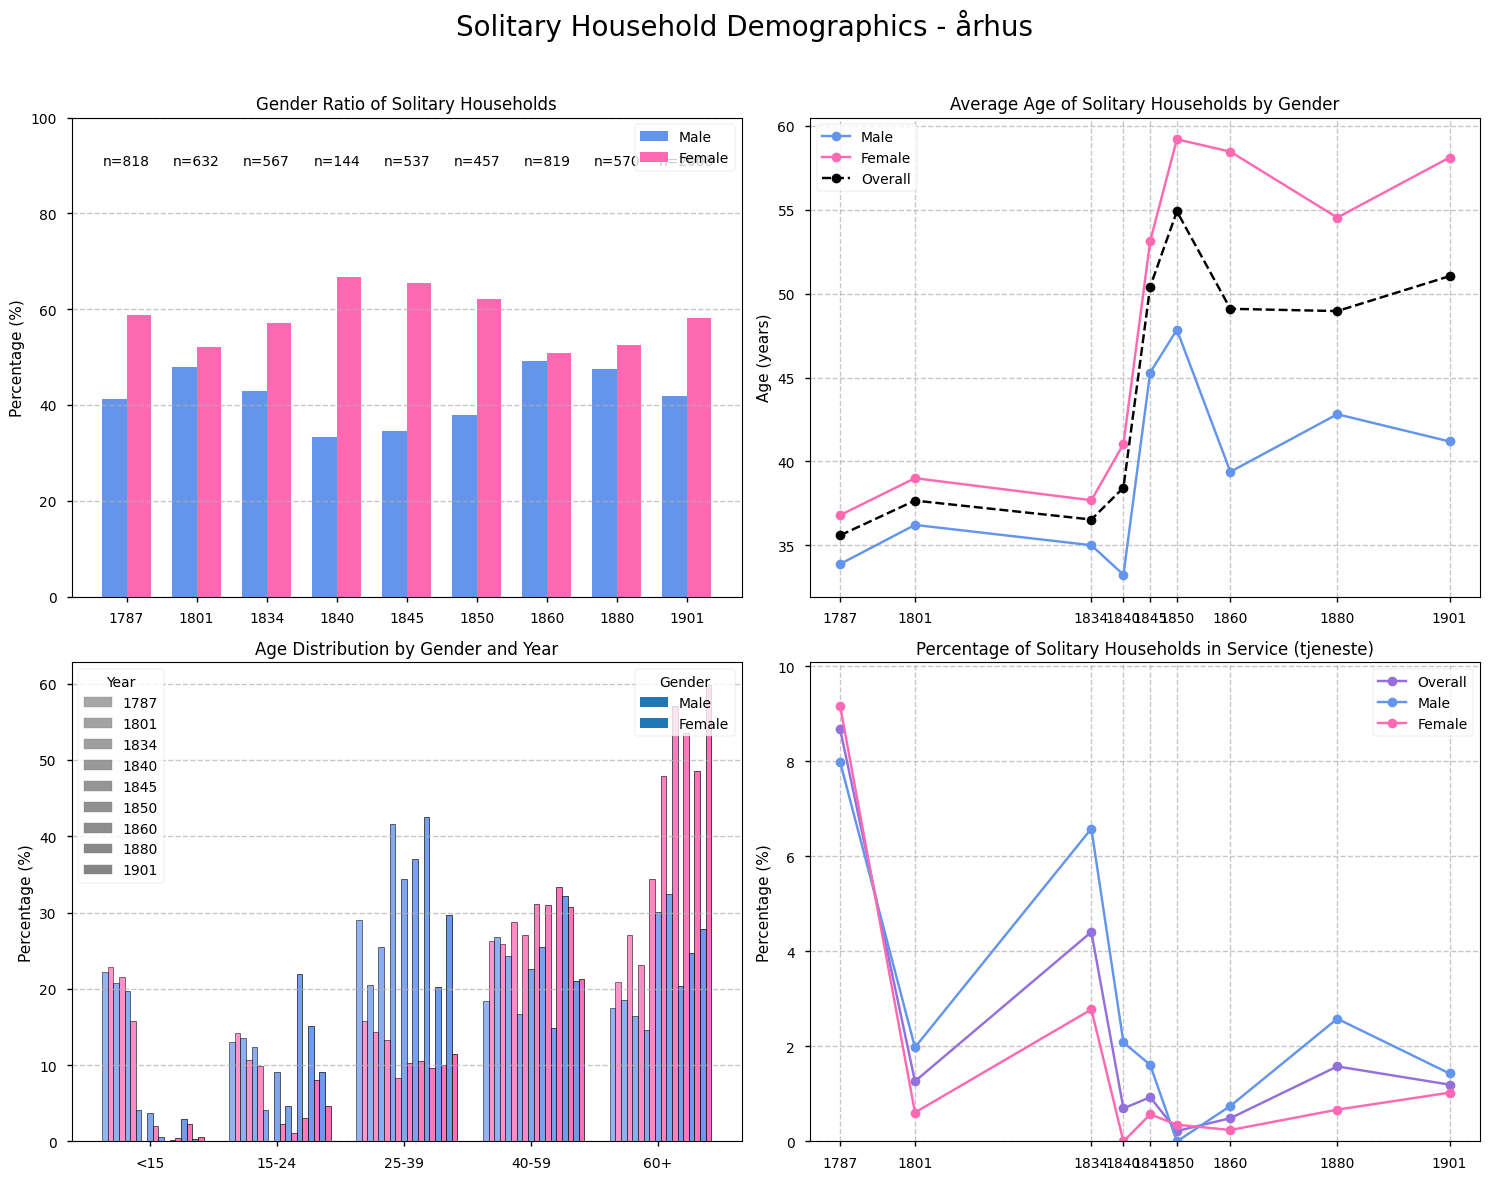

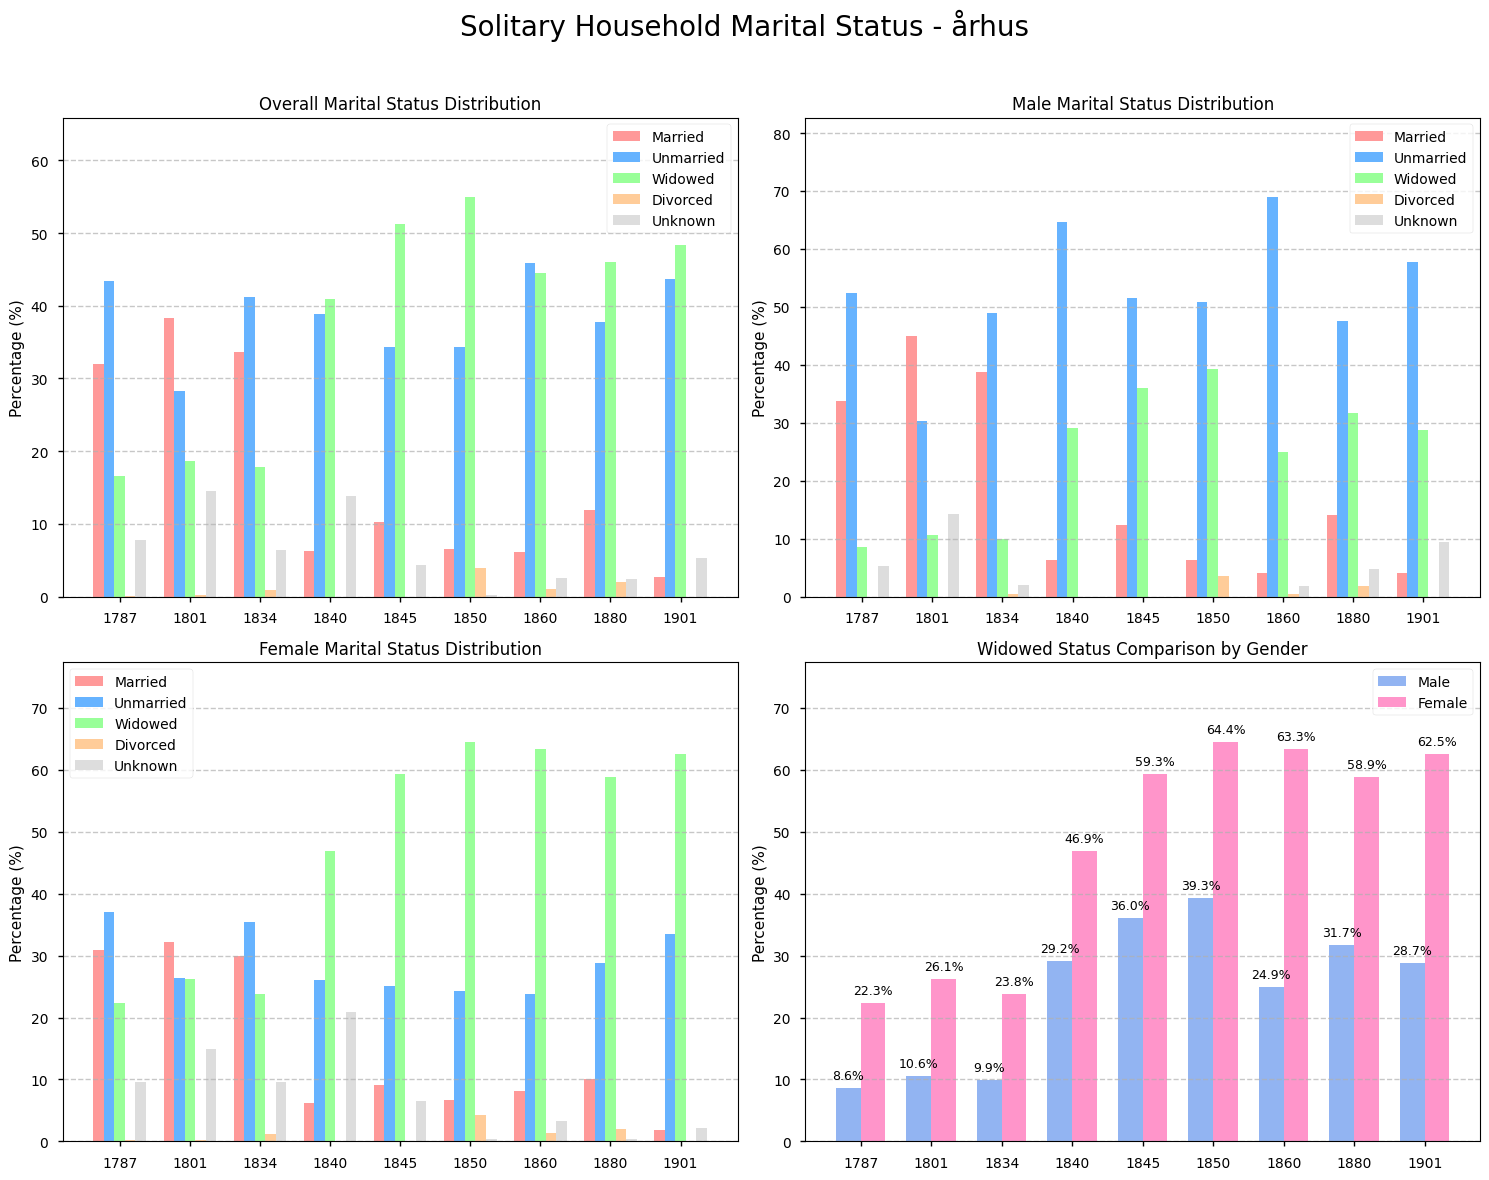


århus Solitary Household Characteristics
 year  total_solitaries  male_ratio  female_ratio  mean_age  male_mean_age  female_mean_age  helper_ratio  male_helper_ratio  female_helper_ratio
 1787               818        41.3          58.7      35.6           33.9             36.8           8.7                8.0                  9.2
 1801               632        47.9          52.1      37.7           36.2             39.0           1.3                2.0                  0.6
 1834               567        42.9          57.1      36.5           35.0             37.7           4.4                6.6                  2.8
 1840               144        33.3          66.7      38.4           33.2             41.0           0.7                2.1                  0.0
 1845               537        34.6          65.4      50.4           45.3             53.1           0.9                1.6                  0.6
 1850               457        37.9          62.1      54.9           47.8        

In [7]:
import re

def analyze_solitaries(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyzes characteristics of solitary households across time and counties,
    with detailed breakdowns by gender, age, marital status, and helper status.
    
    Args:
        df: DataFrame containing household census data
        
    Returns:
        DataFrame with solitary household statistics by county and year
    """
    cleaned_df = clean_household_data(df)
    results = []
    
    # Define marital status categories with more precise patterns
    # Use the start of string (^) anchor to match more precisely
    marital_patterns = {
        'married': r'(?:^|\b)gift\b',
        'unmarried': r'(?:^|\b)ugift\b',
        'widowed': r'(?:^|\b)enke\b',
        'divorced': r'(?:^|\b)skilt\b'
    }
    
    # Define age groups for distribution analysis
    age_groups = [
        (0, 14, '<15'),
        (15, 24, '15-24'),
        (25, 39, '25-39'),
        (40, 59, '40-59'),
        (60, float('inf'), '60+')
    ]
    
    for (county, year), group in cleaned_df.groupby(['event_county', 'event_year']):
        households = group.groupby('household_id')
        solitaries = [hh for _, hh in households if len(hh) == 1]
        
        if not solitaries:
            continue
            
        solitary_df = pd.concat(solitaries)
        total_count = len(solitary_df)
        
        # Calculate helper status
        helper_count = solitary_df['household_position'].str.contains('tjeneste', case=False, na=False).sum()
        helper_ratio = helper_count / total_count * 100
        
        # Gender analysis
        gender_counts = solitary_df['sex'].str.lower().value_counts()
        male_count = gender_counts.get('m', 0)
        female_count = gender_counts.get('f', 0) + gender_counts.get('k', 0)  # Include 'k' for 'kvinde'
        
        male_ratio = male_count / total_count * 100
        female_ratio = female_count / total_count * 100
        
        # Age analysis by gender
        mean_age = solitary_df['age'].mean()
        male_mean_age = solitary_df[solitary_df['sex'].str.lower() == 'm']['age'].mean()
        female_mean_age = solitary_df[solitary_df['sex'].str.lower().isin(['f', 'k'])]['age'].mean()
        
        # Age group analysis
        age_group_counts = {}
        age_group_male_counts = {}
        age_group_female_counts = {}
        
        for min_age, max_age, group_label in age_groups:
            age_mask = (solitary_df['age'] >= min_age) & (solitary_df['age'] <= max_age)
            group_count = age_mask.sum()
            age_group_counts[group_label] = group_count
            
            # By gender
            male_mask = solitary_df['sex'].str.lower() == 'm'
            female_mask = solitary_df['sex'].str.lower().isin(['f', 'k'])
            
            age_group_male_counts[group_label] = (age_mask & male_mask).sum()
            age_group_female_counts[group_label] = (age_mask & female_mask).sum()
        
        # Calculate age group percentages
        age_group_pcts = {k: (v / total_count * 100) for k, v in age_group_counts.items()}
        age_group_male_pcts = {k: (v / male_count * 100) if male_count > 0 else 0 
                             for k, v in age_group_male_counts.items()}
        age_group_female_pcts = {k: (v / female_count * 100) if female_count > 0 else 0 
                               for k, v in age_group_female_counts.items()}
        
        # Helper ratio by gender
        male_helpers = solitary_df[(solitary_df['sex'].str.lower() == 'm') & 
                                  (solitary_df['household_position'].str.contains('tjeneste', case=False, na=False))]
        female_helpers = solitary_df[(solitary_df['sex'].str.lower().isin(['f', 'k'])) & 
                                    (solitary_df['household_position'].str.contains('tjeneste', case=False, na=False))]
        
        male_helper_ratio = (len(male_helpers) / male_count * 100) if male_count > 0 else 0
        female_helper_ratio = (len(female_helpers) / female_count * 100) if female_count > 0 else 0
        
        # Marital status analysis - IMPROVED METHOD
        # Create a categorical marital status column to ensure each person is counted only once
        def categorize_marital_status(status_str):
            if pd.isna(status_str):
                return 'unknown'
                
            status_str = str(status_str).lower()
            
            # Check each pattern in order of priority
            if re.search(marital_patterns['married'], status_str):
                return 'married'
            elif re.search(marital_patterns['widowed'], status_str):
                return 'widowed'
            elif re.search(marital_patterns['unmarried'], status_str):
                return 'unmarried'
            elif re.search(marital_patterns['divorced'], status_str):
                return 'divorced'
            else:
                return 'unknown'
        
        # Apply categorization
        solitary_df['marital_category'] = solitary_df['marital_status'].apply(categorize_marital_status)
        
        # Overall marital status distribution
        marital_status_counts = solitary_df['marital_category'].value_counts()
        marital_status_pcts = {status: (marital_status_counts.get(status, 0) / total_count * 100) 
                              for status in ['married', 'unmarried', 'widowed', 'divorced', 'unknown']}
        
        # Marital status by gender
        males = solitary_df[solitary_df['sex'].str.lower() == 'm']
        females = solitary_df[solitary_df['sex'].str.lower().isin(['f', 'k'])]
        
        male_status_counts = males['marital_category'].value_counts()
        female_status_counts = females['marital_category'].value_counts()
        
        male_status_pcts = {status: (male_status_counts.get(status, 0) / len(males) * 100) if len(males) > 0 else 0 
                          for status in ['married', 'unmarried', 'widowed', 'divorced', 'unknown']}
        female_status_pcts = {status: (female_status_counts.get(status, 0) / len(females) * 100) if len(females) > 0 else 0 
                            for status in ['married', 'unmarried', 'widowed', 'divorced', 'unknown']}
        
        result = {
            'county': county,
            'year': year,
            'total_solitaries': total_count,
            'male_count': male_count,
            'female_count': female_count,
            'male_ratio': male_ratio,
            'female_ratio': female_ratio,
            'mean_age': mean_age,
            'male_mean_age': male_mean_age,
            'female_mean_age': female_mean_age,
            'helper_ratio': helper_ratio,
            'male_helper_ratio': male_helper_ratio,
            'female_helper_ratio': female_helper_ratio
        }
        
        # Add marital status percentages
        for status in ['married', 'unmarried', 'widowed', 'divorced', 'unknown']:
            result[f'total_{status}_pct'] = marital_status_pcts[status]
            result[f'male_{status}_pct'] = male_status_pcts[status]
            result[f'female_{status}_pct'] = female_status_pcts[status]
        
        # Add age group percentages
        for group_label in [g[2] for g in age_groups]:
            result[f'age_group_{group_label}'] = age_group_counts[group_label]
            result[f'age_group_{group_label}_pct'] = age_group_pcts[group_label]
            result[f'male_age_group_{group_label}_pct'] = age_group_male_pcts[group_label]
            result[f'female_age_group_{group_label}_pct'] = age_group_female_pcts[group_label]
        
        results.append(result)
    
    return pd.DataFrame(results).sort_values(['county', 'year'])
def visualize_solitary_households(stats_df: pd.DataFrame) -> None:
    """
    Creates visualizations for solitary household statistics with improved
    layout and more detailed temporal breakdowns, including split violin plots
    for different time periods.
    
    Args:
        stats_df: DataFrame with solitary household statistics
    """
    # Import needed for violin plots
    import matplotlib.colors as mcolors
    
    # Set up plotting style
    plt.style.use('seaborn-v0_8-notebook')
    
    # Define color scheme for consistency
    colors = {
        'male': '#6495ED',    # Blue
        'female': '#FF69B4',  # Pink
        'married': '#ff9999',    # Light red
        'unmarried': '#66b3ff',  # Light blue
        'widowed': '#99ff99',    # Light green
        'divorced': '#ffcc99',   # Light orange
        'unknown': '#dddddd',    # Light gray
        'helper': '#9370DB',     # Purple
        # Age group colors
        '<15': '#FFEB3B',     # Yellow
        '15-24': '#4CAF50',   # Green
        '25-39': '#2196F3',   # Blue
        '40-59': '#FF9800',   # Orange
        '60+': '#F44336',     # Red
    }
    
    # Create a better color palette for the violin plots
    cmap = plt.cm.tab20
    
    marital_status_list = ['married', 'unmarried', 'widowed', 'divorced', 'unknown']
    age_group_list = ['<15', '15-24', '25-39', '40-59', '60+']
    
    for county in stats_df['county'].unique():
        county_data = stats_df[stats_df['county'] == county].sort_values('year')
        
        # Ensure all percentage values are positive
        for col in county_data.columns:
            if 'pct' in col or 'ratio' in col:
                county_data[col] = county_data[col].abs()
        
        years = county_data['year'].values
        
        # Split years into two groups: pre-1850 and 1850+
        early_years = [year for year in years if year < 1850]
        late_years = [year for year in years if year >= 1850]
        
        # Create year-specific colors from colormap
        year_colors = {}
        
        # Colors for early years - first half of the colormap
        for i, year in enumerate(early_years):
            year_colors[year] = cmap(i)
            
        # Colors for late years - second half of the colormap (with offset to avoid duplicate colors)
        for i, year in enumerate(late_years):
            year_colors[year] = cmap(i + 10)  # Use the second half of tab20
        
        # ===== Gender Ratio and Age Analysis =====
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Solitary Household Demographics - {county}', fontsize=20, y=0.98)
        
        # 1. Gender Ratio Plot (regular bar chart instead of stacked)
        ax = axes[0, 0]
        width = 0.35
        x = np.arange(len(years))
        
        # Plot male and female percentages as separate bars
        ax.bar(x - width/2, county_data['male_ratio'], width, color=colors['male'], label='Male')
        ax.bar(x + width/2, county_data['female_ratio'], width, color=colors['female'], label='Female')
        
        ax.set_title('Gender Ratio of Solitary Households')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(x)
        ax.set_xticklabels(years)
        ax.set_ylim(0, 100)
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        ax.legend()
        
        # Add count annotations
        for i, year in enumerate(years):
            total = county_data.iloc[i]['total_solitaries']
            ax.text(i, 90, f'n={total}', ha='center')
        
        # 2. Average Age by Gender
        ax = axes[0, 1]
        ax.plot(years, county_data['male_mean_age'], 'o-', color=colors['male'], label='Male')
        ax.plot(years, county_data['female_mean_age'], 'o-', color=colors['female'], label='Female')
        ax.plot(years, county_data['mean_age'], 'o--', color='black', label='Overall')
        ax.set_title('Average Age of Solitary Households by Gender')
        ax.set_ylabel('Age (years)')
        ax.set_xticks(years)  # Explicitly set x-ticks to years
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        
        # 3. Age Distribution by Gender and Year
        ax = axes[1, 0]
        
        # Create a mini-plot for each year
        n_years = len(years)
        n_groups = len(age_group_list)
        group_width = 0.8 / n_years  # Width of each year group
        bar_width = group_width / 2  # Width of each bar within group
        
        # Set up positions for each group of bars
        positions = np.arange(n_groups)
        
        # For each year, plot male and female percentages for each age group
        for i, year in enumerate(years):
            year_data = county_data[county_data['year'] == year]
            offset = (i - n_years/2 + 0.5) * group_width
            
            # Male bars
            male_values = [year_data[f'male_age_group_{age}_pct'].values[0] for age in age_group_list]
            male_pos = positions + offset
            male_bars = ax.bar(male_pos, male_values, bar_width, color=colors['male'], 
                              alpha=0.7 + 0.3/n_years*i, edgecolor='black', linewidth=0.5)
            
            # Female bars
            female_values = [year_data[f'female_age_group_{age}_pct'].values[0] for age in age_group_list]
            female_pos = positions + offset + bar_width
            female_bars = ax.bar(female_pos, female_values, bar_width, color=colors['female'], 
                                alpha=0.7 + 0.3/n_years*i, edgecolor='black', linewidth=0.5)
            
            # Add a small legend for this year
            if i == 0:
                ax.bar([], [], color=colors['male'], label='Male')
                ax.bar([], [], color=colors['female'], label='Female')
        
        # Create year-specific legend
        years_legend = ax.legend(title='Gender', loc='upper right')
        ax.add_artist(years_legend)
        
        # Add a custom legend for years
        handles = [plt.Rectangle((0,0), 1, 1, color='gray', alpha=0.7 + 0.3/n_years*i) for i in range(n_years)]
        ax.legend(handles, years, title='Year', loc='upper left')
        
        ax.set_title('Age Distribution by Gender and Year')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(positions)
        ax.set_xticklabels(age_group_list)
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        
        # 4. Helper Ratio 
        ax = axes[1, 1]
        ax.plot(years, county_data['helper_ratio'], 'o-', color=colors['helper'], label='Overall')
        ax.plot(years, county_data['male_helper_ratio'], 'o-', color=colors['male'], label='Male')
        ax.plot(years, county_data['female_helper_ratio'], 'o-', color=colors['female'], label='Female')
        ax.set_title('Percentage of Solitary Households in Service (tjeneste)')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(years)  # Explicitly set x-ticks to years
        
        # Properly calculate max value for y-axis limit
        helper_max = max(
            county_data['helper_ratio'].max(),
            county_data['male_helper_ratio'].max(),
            county_data['female_helper_ratio'].max()
        )
        y_limit = max(helper_max * 1.1, 10)
        ax.set_ylim(0, y_limit)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        
        # Adjust layout and display
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # ===== Marital Status Analysis =====
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Solitary Household Marital Status - {county}', fontsize=20, y=0.98)
        
        # 1. Overall Marital Status (regular bar chart instead of stacked)
        ax = axes[0, 0]
        
        # Set up bar positions
        bar_width = 0.15
        positions = np.arange(len(years))
        offsets = np.linspace(-(len(marital_status_list)-1)/2*bar_width, (len(marital_status_list)-1)/2*bar_width, len(marital_status_list))
        
        # Plot each marital status as a separate bar
        for i, status in enumerate(marital_status_list):
            values = county_data[f'total_{status}_pct'].values
            ax.bar(positions + offsets[i], values, bar_width, label=status.capitalize(), color=colors[status])
        
        ax.set_title('Overall Marital Status Distribution')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(positions)
        ax.set_xticklabels(years)
        ax.set_ylim(0, min(100, county_data[[f'total_{status}_pct' for status in marital_status_list]].max().max() * 1.2))
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        ax.legend()
        
        # 2. Marital Status - Males (regular bar chart instead of stacked)
        ax = axes[0, 1]
        
        # Plot each marital status as a separate bar
        for i, status in enumerate(marital_status_list):
            values = county_data[f'male_{status}_pct'].values
            ax.bar(positions + offsets[i], values, bar_width, label=status.capitalize(), color=colors[status])
        
        ax.set_title('Male Marital Status Distribution')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(positions)
        ax.set_xticklabels(years)
        ax.set_ylim(0, min(100, county_data[[f'male_{status}_pct' for status in marital_status_list]].max().max() * 1.2))
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        ax.legend()
        
        # 3. Marital Status - Females (regular bar chart instead of stacked)
        ax = axes[1, 0]
        
        # Plot each marital status as a separate bar
        for i, status in enumerate(marital_status_list):
            values = county_data[f'female_{status}_pct'].values
            ax.bar(positions + offsets[i], values, bar_width, label=status.capitalize(), color=colors[status])
        
        ax.set_title('Female Marital Status Distribution')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(positions)
        ax.set_xticklabels(years)
        ax.set_ylim(0, min(100, county_data[[f'female_{status}_pct' for status in marital_status_list]].max().max() * 1.2))
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        ax.legend()
        
        # 4. Marital Status Comparison by Gender and Year
        ax = axes[1, 1]
        
        # Create a grid for detailed comparison of a specific marital status across years
        # Let's focus on widowed status as an example (typically interesting for solitaries)
        male_widowed = county_data['male_widowed_pct'].values
        female_widowed = county_data['female_widowed_pct'].values
        
        # Bar positions
        x = np.arange(len(years))
        width = 0.35
        
        # Plot bars
        ax.bar(x - width/2, male_widowed, width, label='Male', color=colors['male'], alpha=0.7)
        ax.bar(x + width/2, female_widowed, width, label='Female', color=colors['female'], alpha=0.7)
        
        # Add percentage labels above bars
        for i in range(len(x)):
            ax.text(x[i] - width/2, male_widowed[i] + 1, f'{male_widowed[i]:.1f}%', 
                  ha='center', va='bottom', fontsize=9)
            ax.text(x[i] + width/2, female_widowed[i] + 1, f'{female_widowed[i]:.1f}%', 
                  ha='center', va='bottom', fontsize=9)
        
        # Customize plot
        ax.set_title('Widowed Status Comparison by Gender')
        ax.set_ylabel('Percentage (%)')
        ax.set_xticks(x)
        ax.set_xticklabels(years)
        ax.grid(True, linestyle='--', alpha=0.7, axis='y')
        ax.legend()
        
        # Set y-limit with some headroom
        max_pct = max(max(male_widowed), max(female_widowed))
        ax.set_ylim(0, max(max_pct * 1.2, 10))
        
        # Adjust layout and display
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # ===== Age Group Layered Violin Plot Analysis - Split by Time Period =====
        # Create a figure with 2 rows (male/female) and 2 columns (early/late years)
        fig, axes = plt.subplots(2, 2, figsize=(18, 18))
        fig.suptitle(f'Age Distribution by Time Period - {county}', fontsize=20, y=0.98)
        
        # Add titles for each column
        plt.figtext(0.25, 0.96, "Pre-1850", ha="center", va="center", fontsize=16, fontweight='bold')
        plt.figtext(0.75, 0.96, "1850 and Later", ha="center", va="center", fontsize=16, fontweight='bold')
        
        # Function to map age group to numeric value for violin plotting
        def age_group_to_numeric(age_group):
            # Map to central value of each age group for visualization
            if age_group == '<15':
                return 7.5
            elif age_group == '15-24':
                return 19.5
            elif age_group == '25-39':
                return 32
            elif age_group == '40-59':
                return 49.5
            elif age_group == '60+':
                return 70
        
        # Create layered violin plot data
        male_data_by_year = {}
        female_data_by_year = {}
        
        for year in years:
            year_data = county_data[county_data['year'] == year]
            
            # Create weighted data points for each age group
            male_data = []
            female_data = []
            
            for age_group in age_group_list:
                male_pct = year_data[f'male_age_group_{age_group}_pct'].values[0]
                female_pct = year_data[f'female_age_group_{age_group}_pct'].values[0]
                
                # Convert age group to numeric value
                numeric_age = age_group_to_numeric(age_group)
                
                # Add points proportional to percentage (scaled for visualization)
                num_points = max(5, int(male_pct * 10))  # at least 5 points, more for higher percentages
                male_data.extend([numeric_age + np.random.normal(0, 2, size=num_points)])  # Add some jitter
                
                num_points = max(5, int(female_pct * 10))
                female_data.extend([numeric_age + np.random.normal(0, 2, size=num_points)])  # Add some jitter
            
            # Store data for each year
            male_data_by_year[year] = np.concatenate(male_data) if male_data else np.array([])
            female_data_by_year[year] = np.concatenate(female_data) if female_data else np.array([])
        
        # Plot early years (Pre-1850) - male
        ax = axes[0, 0]
        violin_positions = []
        violin_data = []
        violin_colors = []
        
        for year in early_years:
            if len(male_data_by_year[year]) > 0:
                violin_positions.append(0)  # All at position 0 for layering
                violin_data.append(male_data_by_year[year])
                violin_colors.append(year_colors[year])
        
        if violin_data:  # Only plot if we have data
            parts = ax.violinplot(violin_data, positions=violin_positions, vert=True, showmeans=False, 
                                showmedians=False, showextrema=False)
            
            # Customize violin parts
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(violin_colors[i])
                pc.set_edgecolor('none')
                pc.set_alpha(0.25)
        
        ax.set_title('Male - Pre 1850')
        ax.set_ylabel('Age')
        ax.set_xticks([])
        ax.set_ylim(0, 85)
        ax.grid(False)
        
        # Plot late years (1850+) - male
        ax = axes[0, 1]
        violin_positions = []
        violin_data = []
        violin_colors = []
        
        for year in late_years:
            if len(male_data_by_year[year]) > 0:
                violin_positions.append(0)
                violin_data.append(male_data_by_year[year])
                violin_colors.append(year_colors[year])
        
        if violin_data:  # Only plot if we have data
            parts = ax.violinplot(violin_data, positions=violin_positions, vert=True, showmeans=False, 
                                showmedians=False, showextrema=False)
            
            # Customize violin parts
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(violin_colors[i])
                pc.set_edgecolor('none')
                pc.set_alpha(0.25)
        
        ax.set_title('Male - 1850 and Later')
        ax.set_ylabel('Age')
        ax.set_xticks([])
        ax.set_ylim(0, 85)
        ax.grid(False)
        
        # Plot early years (Pre-1850) - female
        ax = axes[1, 0]
        violin_positions = []
        violin_data = []
        violin_colors = []
        
        for year in early_years:
            if len(female_data_by_year[year]) > 0:
                violin_positions.append(0)
                violin_data.append(female_data_by_year[year])
                violin_colors.append(year_colors[year])
        
        if violin_data:  # Only plot if we have data
            parts = ax.violinplot(violin_data, positions=violin_positions, vert=True, showmeans=False, 
                                showmedians=False, showextrema=False)
            
            # Customize violin parts
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(violin_colors[i])
                pc.set_edgecolor('none')
                pc.set_alpha(0.25)
        
        ax.set_title('Female - Pre 1850')
        ax.set_ylabel('Age')
        ax.set_xticks([])
        ax.set_ylim(0, 85)
        ax.grid(False)
        
        # Plot late years (1850+) - female
        ax = axes[1, 1]
        violin_positions = []
        violin_data = []
        violin_colors = []
        
        for year in late_years:
            if len(female_data_by_year[year]) > 0:
                violin_positions.append(0)
                violin_data.append(female_data_by_year[year])
                violin_colors.append(year_colors[year])
        
        if violin_data:  # Only plot if we have data
            parts = ax.violinplot(violin_data, positions=violin_positions, vert=True, showmeans=False, 
                                showmedians=False, showextrema=False)
            
            # Customize violin parts
            for i, pc in enumerate(parts['bodies']):
                pc.set_facecolor(violin_colors[i])
                pc.set_edgecolor('none')
                pc.set_alpha(0.25)
        
        ax.set_title('Female - 1850 and Later')
        ax.set_ylabel('Age')
        ax.set_xticks([])
        ax.set_ylim(0, 85)
        ax.grid(False)
        
        # Create a combined legend for all years
        early_handles = [plt.Line2D([0], [0], color=year_colors[year], lw=4, alpha=0.7) for year in early_years]
        late_handles = [plt.Line2D([0], [0], color=year_colors[year], lw=4, alpha=0.7) for year in late_years]
        
        # Add legends for each time period
        if early_years:
            fig.legend(early_handles, early_years, title="Pre-1850", 
                      loc='upper left', bbox_to_anchor=(0.1, 0.95))
            
        if late_years:
            fig.legend(late_handles, late_years, title="1850 and Later", 
                      loc='upper right', bbox_to_anchor=(0.9, 0.95))
        
        plt.tight_layout(rect=[0, 0, 1, 0.94])
        plt.show()
        
        # ===== Marital Status Temporal Analysis =====
        # Create one plot per marital status to show male vs female over time
        fig, axes = plt.subplots(len(marital_status_list), 1, figsize=(15, 20))
        fig.suptitle(f'Marital Status Analysis Over Time - {county}', fontsize=20, y=0.98)
        
        # Plot one marital status per subplot
        for i, status in enumerate(marital_status_list):
            ax = axes[i]
            
            male_values = county_data[f'male_{status}_pct'].values
            female_values = county_data[f'female_{status}_pct'].values
            
            ax.bar(years - 0.2, male_values, 0.4, label='Male', color=colors['male'])
            ax.bar(years + 0.2, female_values, 0.4, label='Female', color=colors['female'])
            
            ax.set_title(f'Marital Status: {status.capitalize()}')
            ax.set_ylabel('Percentage (%)')
            ax.set_xlabel('Year')
            ax.set_xticks(years)  # Explicitly set x-ticks to years
            ax.grid(True, linestyle='--', alpha=0.7, axis='y')
            
            # Only add legend to the first subplot to avoid repetition
            if i == 0:
                ax.legend()
            
            # Add percentage labels if values are significant
            for j, year in enumerate(years):
                if male_values[j] >= 5:
                    ax.text(year - 0.2, male_values[j] + 1, f'{male_values[j]:.1f}%', 
                          ha='center', va='bottom', fontsize=8)
                if female_values[j] >= 5:
                    ax.text(year + 0.2, female_values[j] + 1, f'{female_values[j]:.1f}%', 
                          ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # Print summary statistics
        print(f"\n{county} Solitary Household Characteristics")
        print("=" * 80)
        
        # Create a more concise summary table
        summary_cols = [
            'year', 'total_solitaries', 'male_ratio', 'female_ratio', 
            'mean_age', 'male_mean_age', 'female_mean_age', 
            'helper_ratio', 'male_helper_ratio', 'female_helper_ratio'
        ]
        
        summary_df = county_data[summary_cols].copy()
        # Round numerical columns
        numeric_columns = [col for col in summary_cols if col != 'year' and col != 'total_solitaries']
        summary_df[numeric_columns] = summary_df[numeric_columns].round(1)
        
        print(summary_df.to_string(index=False))
        
        # Print marital status summary
        print("\nMarital Status Breakdown:")
        print("-" * 80)
        marital_cols = ['year'] + [f'total_{status}_pct' for status in marital_status_list]
        marital_df = county_data[marital_cols].copy()
        marital_df.columns = ['Year'] + [s.capitalize() for s in marital_status_list]
        marital_df.iloc[:, 1:] = marital_df.iloc[:, 1:].round(1)
        print(marital_df.to_string(index=False))
        
        # Print age group summary
        print("\nAge Group Breakdown:")
        print("-" * 80)
        age_cols = ['year'] + [f'age_group_{age}_pct' for age in age_group_list]
        age_df = county_data[age_cols].copy()
        age_df.columns = ['Year'] + age_group_list
        age_df.iloc[:, 1:] = age_df.iloc[:, 1:].round(1)
        print(age_df.to_string(index=False))

# Create combined dataframe if not already done
if 'combined_df' not in globals():
    combined_df = pd.concat(df_list, ignore_index=True)
    # Ensure event_county is set properly
    for i, df in enumerate(df_list):
        county = county_names[i] 
        if 'event_county' not in df.columns or df['event_county'].isna().any():
            mask = combined_df.index.isin(df.index)
            combined_df.loc[mask, 'event_county'] = county

# Run the analysis
solitary_stats = analyze_solitaries(combined_df)
visualize_solitary_households(solitary_stats)


Summary Statistics for Solitary Individuals in københavn
Total number of solitary individuals: 36792
Total by gender: 15192 male, 21600 female
Average female ratio: 55.0%
Average age: 46.4 years
Average proportion of population: 1.6%
Average marital status distribution:
  Married: 8.9%
  Unmarried: 47.3%
  Widowed: 40.5%




Gender-Specific Marital Status for Solitary Individuals in københavn
Male Solitary Individuals:
  Married: 12.8%
  Unmarried: 60.6%
  Widowed: 22.8%
  Other/Unknown: 3.8%

Female Solitary Individuals:
  Married: 5.8%
  Unmarried: 36.0%
  Widowed: 55.2%
  Other/Unknown: 3.0%

Detailed Age Statistics for Solitary Individuals in københavn

Year: 1787
----------------------------------------
Male solitary   - Median age: 39.0, IQR: 25.8
Proportion over 50: 31.0% (males)
Proportion over 70: 5.9% (males)
Female solitary - Median age: 57.0, IQR: 27.0
Proportion over 50: 63.1% (females)
Proportion over 70: 16.7% (females)

Year: 1801
----------------------------------------
Male solitary   - Median age: 50.0, IQR: 22.0
Proportion over 50: 51.8% (males)
Proportion over 70: 11.8% (males)
Female solitary - Median age: 59.0, IQR: 18.0
Proportion over 50: 75.7% (females)
Proportion over 70: 20.8% (females)

Year: 1834
----------------------------------------
Male solitary   - Median age: 30.0, IQR


Summary Statistics for Solitary Individuals in århus
Total number of solitary individuals: 6552
Total by gender: 2803 male, 3749 female
Average female ratio: 58.2%
Average age: 44.7 years
Average proportion of population: 1.7%
Average marital status distribution:
  Married: 16.4%
  Unmarried: 38.6%
  Widowed: 37.7%



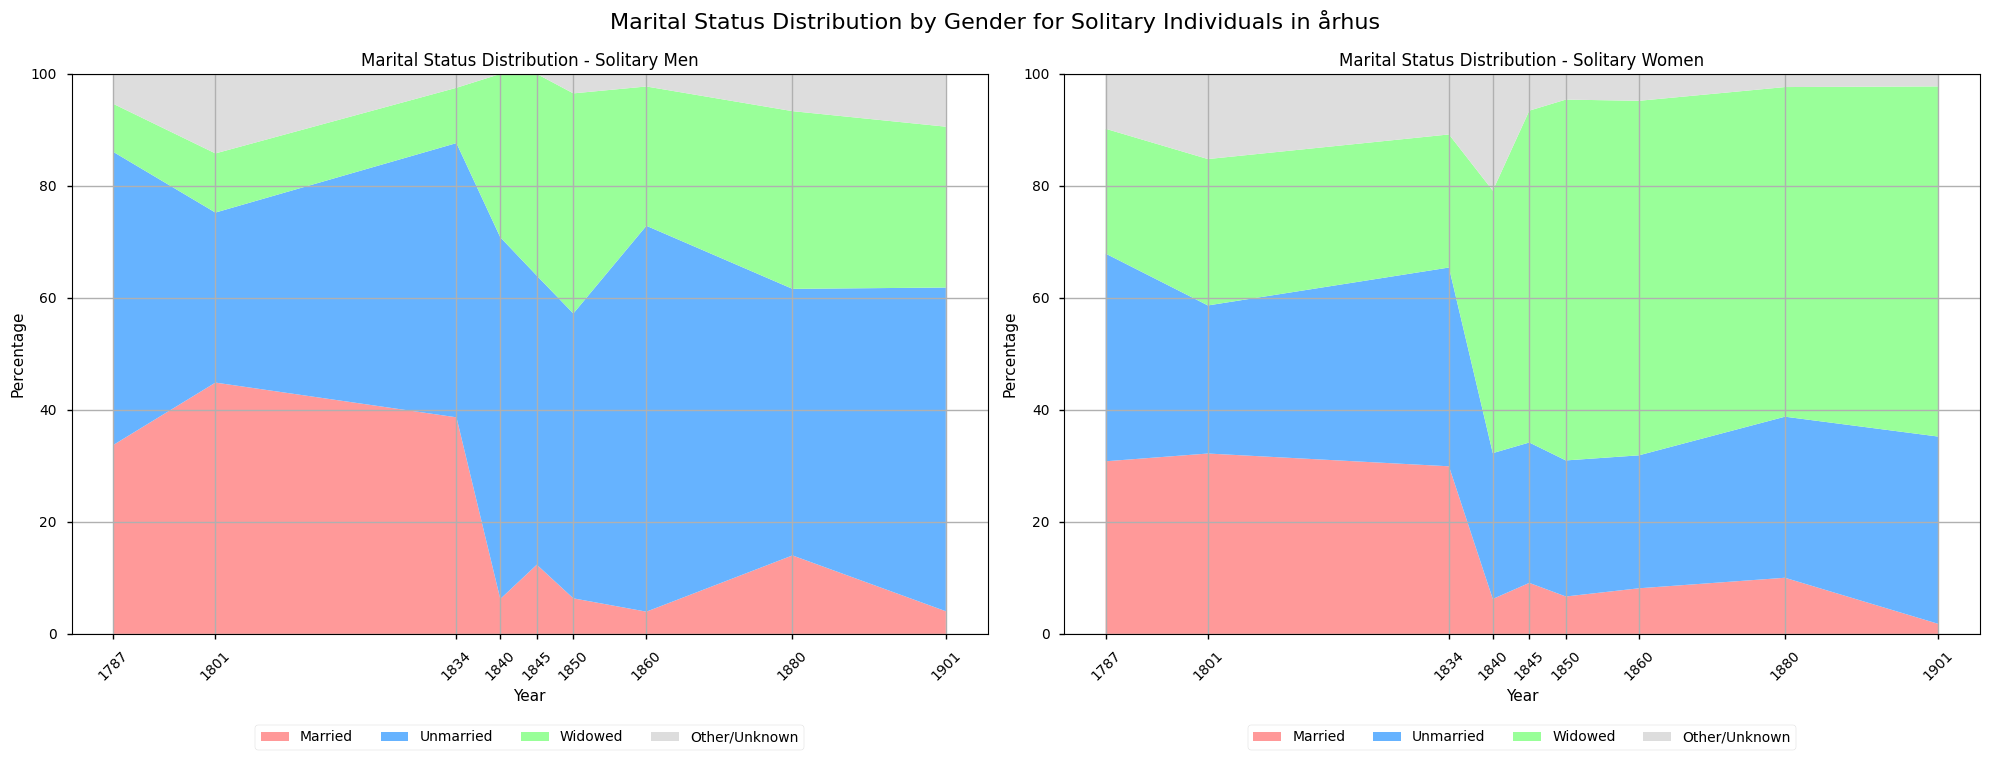


Gender-Specific Marital Status for Solitary Individuals in århus
Male Solitary Individuals:
  Married: 18.3%
  Unmarried: 52.6%
  Widowed: 24.3%
  Other/Unknown: 4.9%

Female Solitary Individuals:
  Married: 15.0%
  Unmarried: 28.9%
  Widowed: 47.5%
  Other/Unknown: 8.6%

Detailed Age Statistics for Solitary Individuals in århus

Year: 1787
----------------------------------------
Male solitary   - Median age: 30.0, IQR: 34.0
Proportion over 50: 26.0% (males)
Proportion over 70: 6.5% (males)
Female solitary - Median age: 36.0, IQR: 40.0
Proportion over 50: 36.0% (females)
Proportion over 70: 6.5% (females)

Year: 1801
----------------------------------------
Male solitary   - Median age: 35.0, IQR: 34.0
Proportion over 50: 29.0% (males)
Proportion over 70: 8.6% (males)
Female solitary - Median age: 42.0, IQR: 44.0
Proportion over 50: 38.3% (females)
Proportion over 70: 10.0% (females)

Year: 1834
----------------------------------------
Male solitary   - Median age: 33.0, IQR: 32.5
Pr

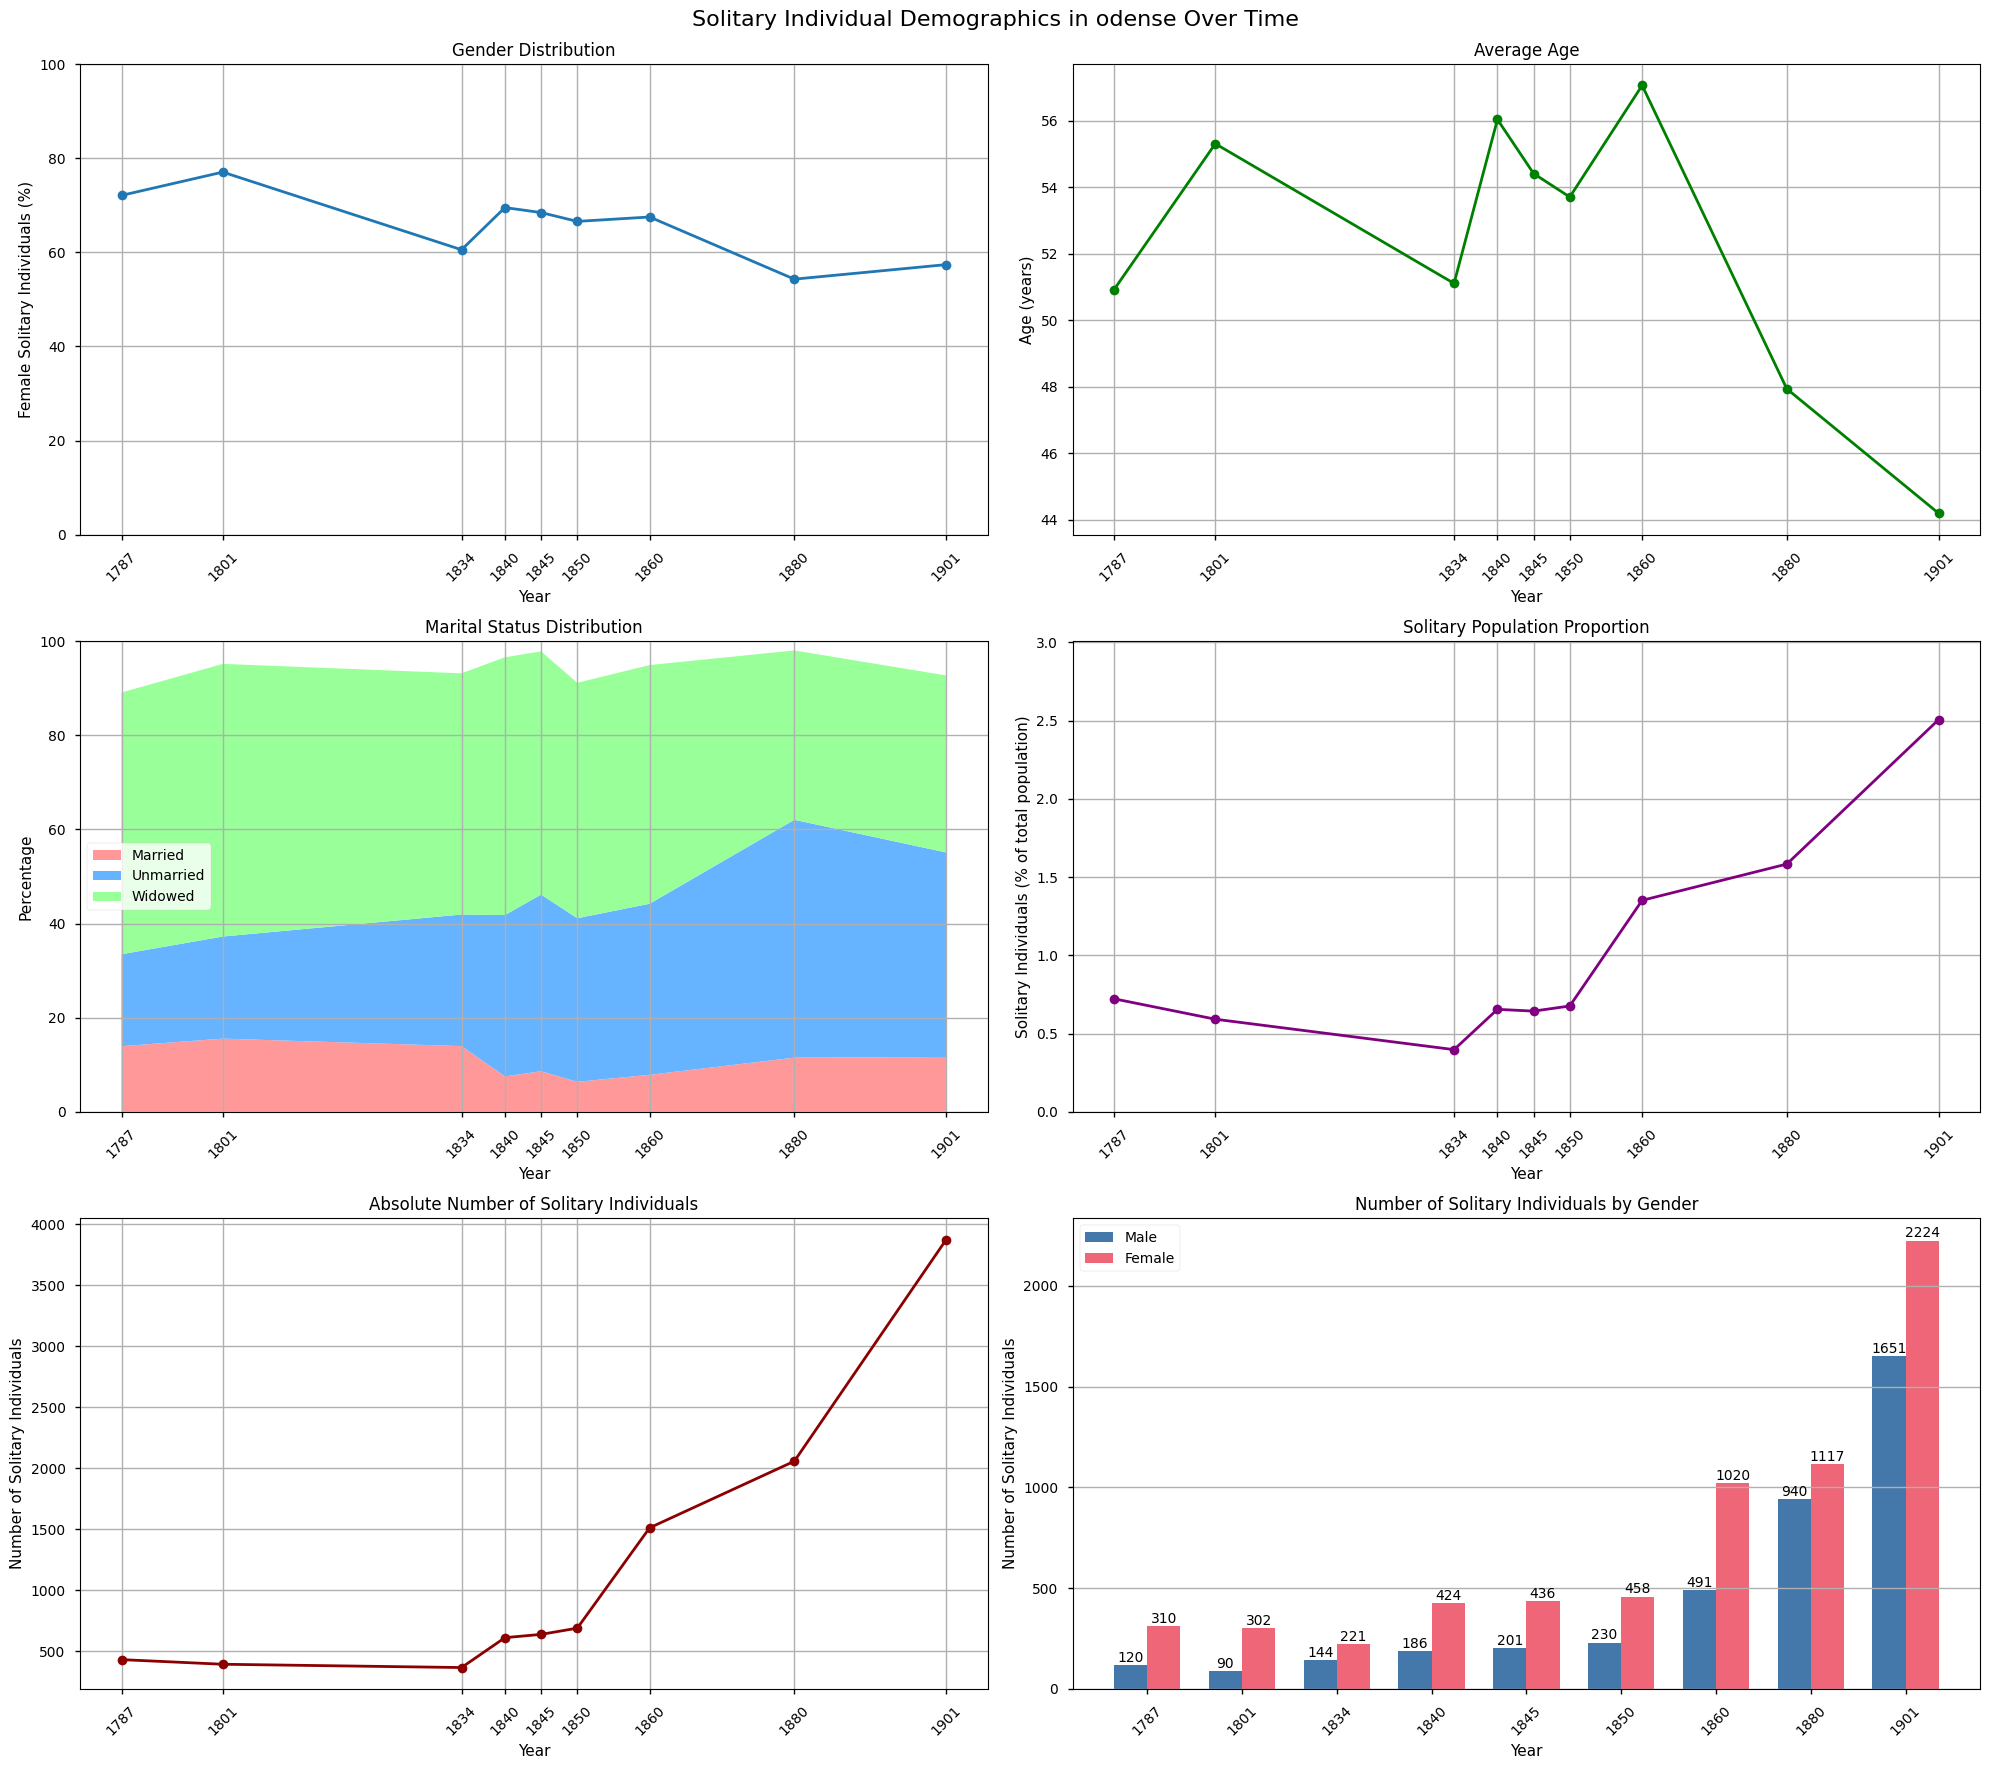


Summary Statistics for Solitary Individuals in odense
Total number of solitary individuals: 10565
Total by gender: 4053 male, 6512 female
Average female ratio: 65.9%
Average age: 52.3 years
Average proportion of population: 1.0%
Average marital status distribution:
  Married: 10.8%
  Unmarried: 34.0%
  Widowed: 49.5%



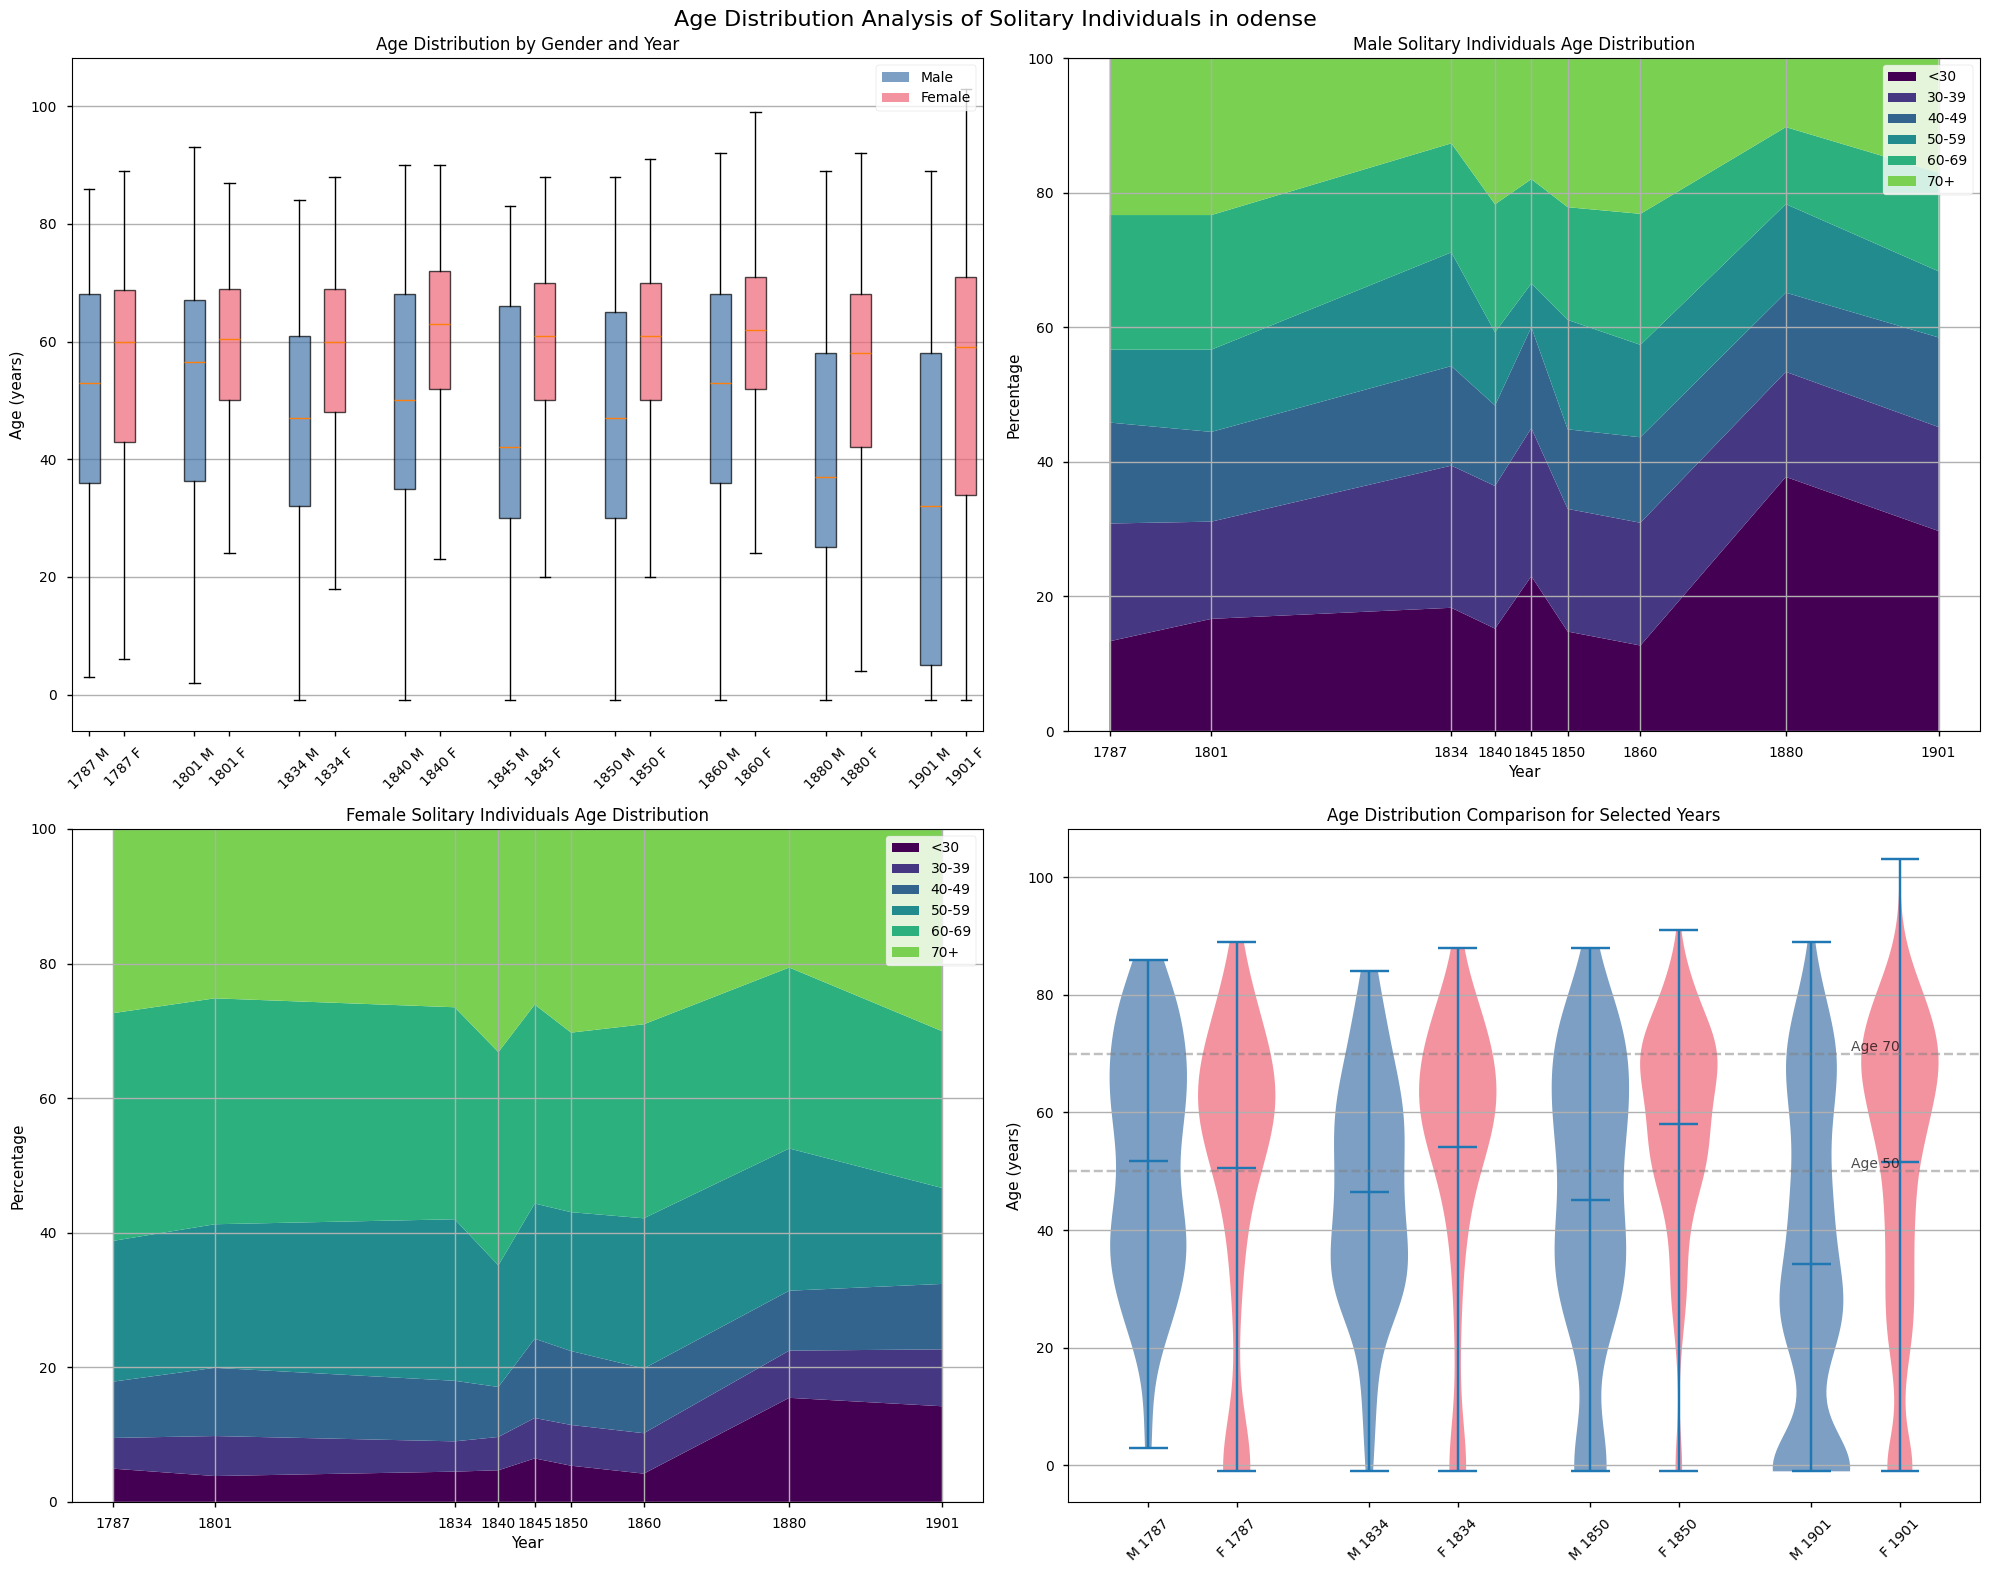

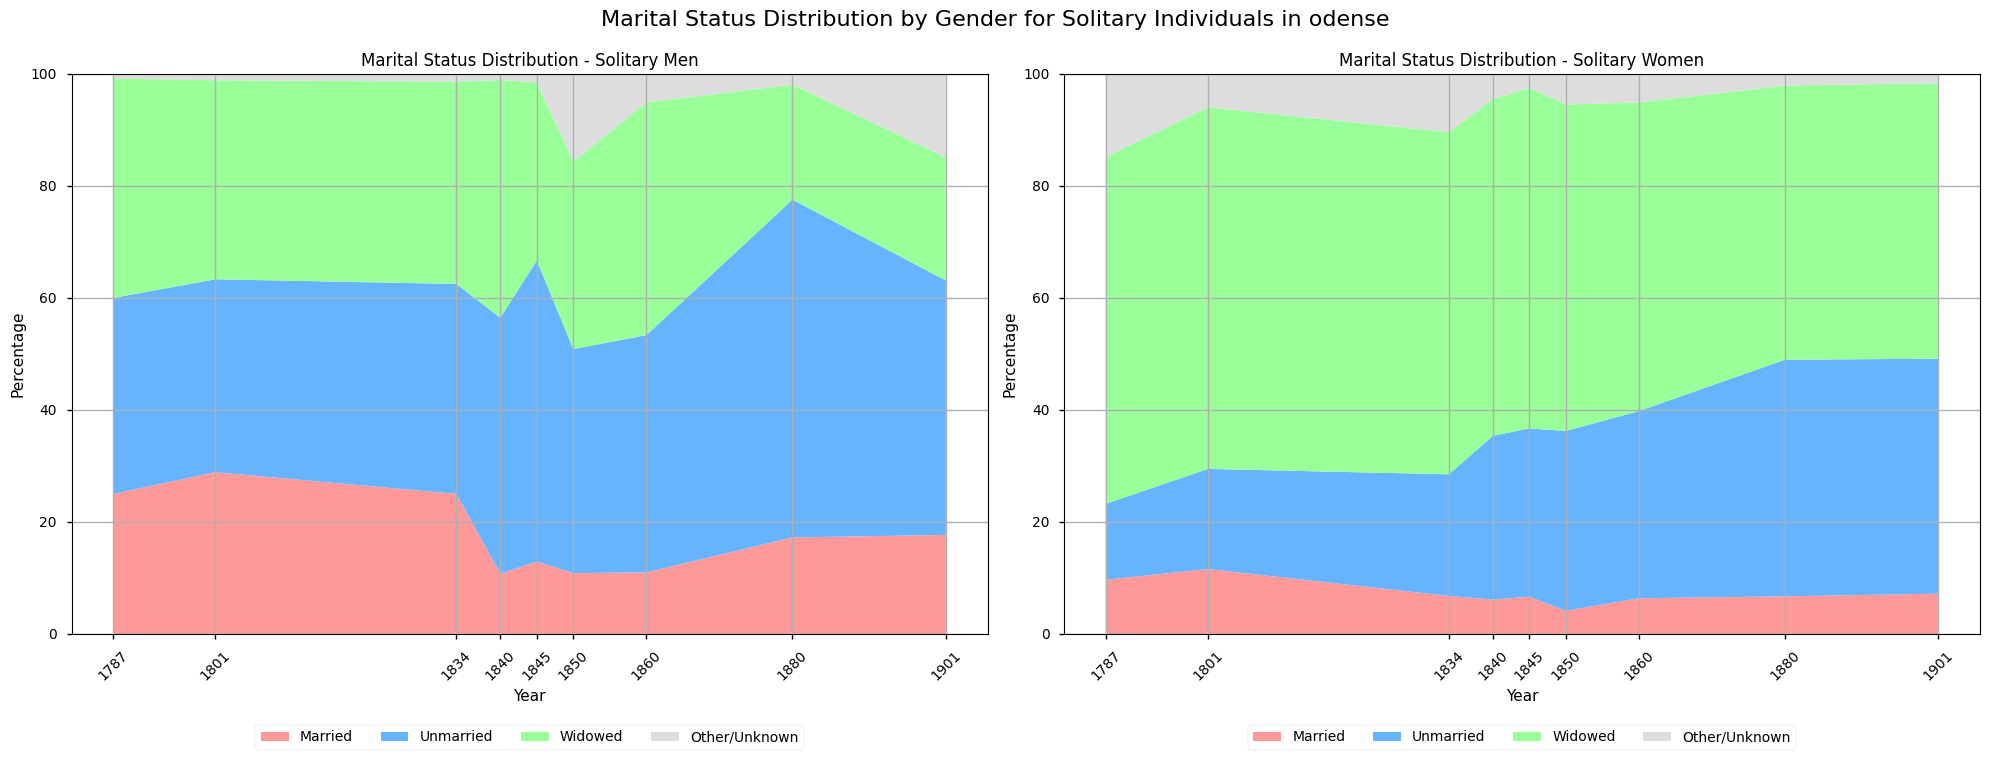


Gender-Specific Marital Status for Solitary Individuals in odense
Male Solitary Individuals:
  Married: 17.7%
  Unmarried: 43.8%
  Widowed: 33.6%
  Other/Unknown: 4.8%

Female Solitary Individuals:
  Married: 7.3%
  Unmarried: 29.1%
  Widowed: 57.8%
  Other/Unknown: 5.8%

Detailed Age Statistics for Solitary Individuals in odense

Year: 1787
----------------------------------------
Male solitary   - Median age: 53.0, IQR: 32.0
Proportion over 50: 54.2% (males)
Proportion over 70: 23.3% (males)
Female solitary - Median age: 60.0, IQR: 25.8
Proportion over 50: 69.7% (females)
Proportion over 70: 23.2% (females)

Year: 1801
----------------------------------------
Male solitary   - Median age: 56.5, IQR: 30.8
Proportion over 50: 55.6% (males)
Proportion over 70: 23.3% (males)
Female solitary - Median age: 60.5, IQR: 19.0
Proportion over 50: 75.8% (females)
Proportion over 70: 23.8% (females)

Year: 1834
----------------------------------------
Male solitary   - Median age: 47.0, IQR: 29.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Optional
from matplotlib.patches import Patch

def analyze_solitary_individuals(df_list: List[pd.DataFrame], county_names: List[str]) -> None:
    """
    Analyzes and plots demographics of solitary individuals across time for each county,
    including absolute numbers, gender distribution, age, and marital status.
    
    Args:
        df_list: List of DataFrames containing census data for different counties
        county_names: List of county names corresponding to each DataFrame
    """
    # Combine all dataframes with proper county labels
    for df, county in zip(df_list, county_names):
        if 'event_county' not in df.columns:
            df['event_county'] = county
    combined_df: pd.DataFrame = pd.concat(df_list, ignore_index=True)
    
    # Clean the data using the function from the shared code
    cleaned_df: pd.DataFrame = clean_household_data(combined_df)
    
    # Identify solitary households by counting members per household ID
    household_counts = cleaned_df.groupby('household_id').size()
    solitary_households = household_counts[household_counts == 1].index
    solitary_people = cleaned_df[cleaned_df['household_id'].isin(solitary_households)]
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8-notebook')
    counties = solitary_people['event_county'].unique()
    
    for county in counties:
        county_solitary: pd.DataFrame = solitary_people[solitary_people['event_county'] == county]
        county_total: pd.DataFrame = cleaned_df[cleaned_df['event_county'] == county]
        
        # Get years with data and remove any years with no solitary individuals
        years: List[int] = sorted(county_solitary['event_year'].unique())
        valid_years: List[int] = []
        valid_indices: List[int] = []
        
        if len(years) == 0:
            print(f"No solitary individuals found in {county}")
            continue
        
        # Initialize data storage for various metrics
        gender_ratios = []
        avg_ages = []
        marital_status = []
        population_ratios = []
        absolute_counts = []
        gender_counts_by_year = []
        male_marital_status_by_year = []
        female_marital_status_by_year = []
        
        # Calculate metrics for each year and identify valid years
        for i, year in enumerate(years):
            year_solitary = county_solitary[county_solitary['event_year'] == year]
            year_total = county_total[county_total['event_year'] == year]
            
            # Skip if no data for this year
            if len(year_solitary) == 0:
                continue
                
            # This is a valid year with data - store its index
            valid_years.append(year)
            valid_indices.append(i)
                
            # Solitary proportion of total population
            solitary_ratio = len(year_solitary) / len(year_total) * 100
            population_ratios.append(solitary_ratio)
            
            # Store absolute count
            absolute_counts.append(len(year_solitary))
            
            # Gender ratio (female percentage)
            gender_counts = year_solitary['sex'].str.lower().value_counts()
            female_count = gender_counts.get('f', 0) + gender_counts.get('k', 0)
            male_count = gender_counts.get('m', 0)
            female_ratio = female_count / len(year_solitary) * 100 if len(year_solitary) > 0 else 0
            gender_ratios.append(female_ratio)
            
            # Store gender counts
            gender_counts_by_year.append((male_count, female_count))
            
            # Average age
            avg_ages.append(year_solitary['age'].mean())
            
            # Overall marital status
            status_data = year_solitary['marital_status'].str.lower()
            total = len(status_data)
            
            # Calculate percentages for each marital status
            unmarried = status_data.str.contains('ugift', na=False).sum() / total * 100
            widow = status_data.str.contains('enke', na=False).sum() / total * 100
            married = status_data.str.match('gift', na=False).sum() / total * 100
            marital_status.append((married, unmarried, widow))
            
            # Gender-specific marital status
            males = year_solitary[year_solitary['sex'].str.lower() == 'm']
            females = year_solitary[year_solitary['sex'].str.lower().isin(['f', 'k'])]
            
            # Male marital status
            male_status = males['marital_status'].str.lower()
            male_total = len(male_status) if len(male_status) > 0 else 1  # Avoid division by zero
            
            male_married = male_status.str.match('gift', na=False).sum() / male_total * 100
            male_unmarried = male_status.str.contains('ugift', na=False).sum() / male_total * 100
            male_widower = male_status.str.contains('enke', na=False).sum() / male_total * 100
            # Calculate 'other' category to ensure total is 100%
            male_other = 100 - (male_married + male_unmarried + male_widower)
            
            male_marital_status_by_year.append((male_married, male_unmarried, male_widower, male_other))
            
            # Female marital status
            female_status = females['marital_status'].str.lower()
            female_total = len(female_status) if len(female_status) > 0 else 1  # Avoid division by zero
            
            female_married = female_status.str.match('gift', na=False).sum() / female_total * 100
            female_unmarried = female_status.str.contains('ugift', na=False).sum() / female_total * 100
            female_widow = female_status.str.contains('enke', na=False).sum() / female_total * 100
            # Calculate 'other' category to ensure total is 100%
            female_other = 100 - (female_married + female_unmarried + female_widow)
            
            female_marital_status_by_year.append((female_married, female_unmarried, female_widow, female_other))
        
        # If no valid years were found after filtering, continue to next county
        if not valid_years:
            print(f"No valid data for solitary individuals in {county} after filtering")
            continue
            
        # Create figure with six subplots (3×2 grid)
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        fig.suptitle(f'Solitary Individual Demographics in {county} Over Time', fontsize=16, y=0.98)
        
        # Plot 1: Gender ratio
        axes[0, 0].plot(valid_years, gender_ratios, 'o-', linewidth=2)
        axes[0, 0].set_ylabel('Female Solitary Individuals (%)')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_title('Gender Distribution')
        axes[0, 0].grid(True)
        axes[0, 0].set_ylim(0, 100)
        # Use only valid years for x-axis ticks
        axes[0, 0].set_xticks(valid_years)
        
        # Plot 2: Average age
        axes[0, 1].plot(valid_years, avg_ages, 'o-', linewidth=2, color='green')
        axes[0, 1].set_ylabel('Age (years)')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_title('Average Age')
        axes[0, 1].grid(True)
        # Use only valid years for x-axis ticks
        axes[0, 1].set_xticks(valid_years)
        
        # Plot 3: Marital status
        married_data = [x[0] for x in marital_status]
        unmarried_data = [x[1] for x in marital_status]
        widow_data = [x[2] for x in marital_status]
        
        axes[1, 0].stackplot(valid_years, 
                     [married_data, unmarried_data, widow_data],
                     labels=['Married', 'Unmarried', 'Widowed'],
                     colors=['#ff9999', '#66b3ff', '#99ff99'])
        axes[1, 0].set_ylabel('Percentage')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_title('Marital Status Distribution')
        axes[1, 0].grid(True)
        axes[1, 0].legend()
        axes[1, 0].set_ylim(0, 100)
        # Use only valid years for x-axis ticks
        axes[1, 0].set_xticks(valid_years)
        
        # Plot 4: Population proportion
        axes[1, 1].plot(valid_years, population_ratios, 'o-', linewidth=2, color='purple')
        axes[1, 1].set_ylabel('Solitary Individuals (% of total population)')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_title('Solitary Population Proportion')
        axes[1, 1].grid(True)
        axes[1, 1].set_ylim(0, max(population_ratios) * 1.2 if population_ratios else 10)
        # Use only valid years for x-axis ticks
        axes[1, 1].set_xticks(valid_years)
        
        # Plot 5: Absolute number of solitary individuals over time
        axes[2, 0].plot(valid_years, absolute_counts, 'o-', linewidth=2, color='darkred')
        axes[2, 0].set_ylabel('Number of Solitary Individuals')
        axes[2, 0].set_xlabel('Year')
        axes[2, 0].set_title('Absolute Number of Solitary Individuals')
        axes[2, 0].grid(True)
        # Use only valid years for x-axis ticks
        axes[2, 0].set_xticks(valid_years)
        
        # Plot 6: Gender distribution as bar plot
        male_counts = [x[0] for x in gender_counts_by_year]
        female_counts = [x[1] for x in gender_counts_by_year]
        
        bar_width = 0.35
        bar_positions = np.arange(len(valid_years))
        
        axes[2, 1].bar(bar_positions - bar_width/2, male_counts, bar_width, 
                      label='Male', color='#4477aa')
        axes[2, 1].bar(bar_positions + bar_width/2, female_counts, bar_width, 
                      label='Female', color='#ee6677')
        
        axes[2, 1].set_ylabel('Number of Solitary Individuals')
        axes[2, 1].set_xlabel('Year')
        axes[2, 1].set_title('Number of Solitary Individuals by Gender')
        # Set bar chart x-ticks and labels to valid years
        axes[2, 1].set_xticks(bar_positions)
        axes[2, 1].set_xticklabels(valid_years)
        axes[2, 1].legend()
        axes[2, 1].grid(True, axis='y')
        
        # Add total count labels on top of bars
        for i, (m, f) in enumerate(zip(male_counts, female_counts)):
            axes[2, 1].text(i - bar_width/2, m + 1, str(m), ha='center', va='bottom')
            axes[2, 1].text(i + bar_width/2, f + 1, str(f), ha='center', va='bottom')
        
        # Rotate x-axis labels for better readability
        for ax in axes.flatten():
            plt.setp(ax.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Adjust top spacing for the suptitle
        plt.show()
        
        # Print summary statistics
        print(f"\nSummary Statistics for Solitary Individuals in {county}")
        print("=" * 60)
        print(f"Total number of solitary individuals: {sum(absolute_counts)}")
        print(f"Total by gender: {sum(male_counts)} male, {sum(female_counts)} female")
        print(f"Average female ratio: {np.mean(gender_ratios):.1f}%")
        print(f"Average age: {np.mean(avg_ages):.1f} years")
        print(f"Average proportion of population: {np.mean(population_ratios):.1f}%")
        print(f"Average marital status distribution:")
        print(f"  Married: {np.mean(married_data):.1f}%")
        print(f"  Unmarried: {np.mean(unmarried_data):.1f}%")
        print(f"  Widowed: {np.mean(widow_data):.1f}%")
        print()
        
        # Additional age-related data structures
        male_age_by_year = []
        female_age_by_year = []
        age_brackets_by_year = []
        
        # For solitary individuals, we'll adjust age brackets to better reflect older population
        age_brackets = [(0, 29), (30, 39), (40, 49), (50, 59), (60, 69), (70, 100)]
        bracket_labels = ['<30', '30-39', '40-49', '50-59', '60-69', '70+']
        
        # Calculate metrics for each valid year
        for year in valid_years:
            year_solitary = county_solitary[county_solitary['event_year'] == year]
            
            # Store age data by gender
            males = year_solitary[year_solitary['sex'].str.lower() == 'm']
            females = year_solitary[year_solitary['sex'].str.lower().isin(['f', 'k'])]
            
            male_age_by_year.append(males['age'].dropna().values)
            female_age_by_year.append(females['age'].dropna().values)
            
            # Calculate age bracket distributions
            year_brackets = []
            for gender_df in [males, females]:
                bracket_counts = []
                for min_age, max_age in age_brackets:
                    count = len(gender_df[(gender_df['age'] >= min_age) & (gender_df['age'] <= max_age)])
                    bracket_counts.append(count)
                year_brackets.append(bracket_counts)
            age_brackets_by_year.append(year_brackets)
        
        # Create second figure for age distribution analysis
        fig2, axes = plt.subplots(2, 2, figsize=(20, 16))
        fig2.suptitle(f'Age Distribution Analysis of Solitary Individuals in {county}', fontsize=16, y=0.98)
        
        # Plot 1: Box plots of age by gender over time
        ax1 = axes[0, 0]
        
        # Create positions for box plots
        positions = []
        box_labels = []
        for i, year in enumerate(valid_years):
            positions.extend([i*3 + 1, i*3 + 2])  # Male, then female position
            box_labels.extend([f"{year} M", f"{year} F"])
        
        # Create box plot data
        box_data = []
        valid_positions = []
        valid_labels = []
        
        for i, (male_ages, female_ages) in enumerate(zip(male_age_by_year, female_age_by_year)):
            if len(male_ages) > 0:
                box_data.append(male_ages)
                valid_positions.append(positions[i*2])
                valid_labels.append(box_labels[i*2])
            
            if len(female_ages) > 0:
                box_data.append(female_ages)
                valid_positions.append(positions[i*2+1])
                valid_labels.append(box_labels[i*2+1])
        
        # Plot box plots if there's sufficient data
        if len(box_data) > 0:
            bplot = ax1.boxplot(box_data, positions=valid_positions, patch_artist=True, 
                              widths=0.6, showfliers=False)
            
            # Color boxes by gender
            for i, box in enumerate(bplot['boxes']):
                is_male = valid_labels[i].endswith('M')
                box.set(facecolor='#4477aa' if is_male else '#ee6677', alpha=0.7)
            
            ax1.set_title('Age Distribution by Gender and Year')
            ax1.set_ylabel('Age (years)')
            ax1.set_xticks(valid_positions)
            ax1.set_xticklabels(valid_labels, rotation=45)
            ax1.grid(True, axis='y')
            
            # Add a legend
            legend_elements = [
                Patch(facecolor='#4477aa', alpha=0.7, label='Male'),
                Patch(facecolor='#ee6677', alpha=0.7, label='Female')
            ]
            ax1.legend(handles=legend_elements, loc='upper right')
        else:
            ax1.text(0.5, 0.5, 'Insufficient data for boxplot', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax1.transAxes)
        
        # Plot 2: Age bracket distribution over time (stacked area chart) - Males
        ax2 = axes[0, 1]
        male_brackets = np.array([[year_data[0][i] for year_data in age_brackets_by_year] 
                                for i in range(len(age_brackets))])
        
        # Convert to percentages
        male_totals = male_brackets.sum(axis=0)
        male_pcts = np.zeros_like(male_brackets, dtype=float)
        
        for i in range(len(male_brackets)):
            for j in range(len(male_totals)):
                if male_totals[j] > 0:
                    male_pcts[i, j] = male_brackets[i, j] / male_totals[j] * 100
        
        # Plot stacked area chart
        if np.sum(male_totals) > 0:
            ax2.stackplot(valid_years, male_pcts, labels=bracket_labels, 
                         colors=plt.cm.viridis(np.linspace(0, 0.8, len(age_brackets))))
            ax2.set_title('Male Solitary Individuals Age Distribution')
            ax2.set_ylabel('Percentage')
            ax2.set_xlabel('Year')
            ax2.legend(loc='upper right')
            ax2.grid(True)
            ax2.set_ylim(0, 100)
            # Use only valid years for x-axis ticks
            ax2.set_xticks(valid_years)
        else:
            ax2.text(0.5, 0.5, 'Insufficient male data', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax2.transAxes)
        
        # Plot 3: Age bracket distribution over time (stacked area chart) - Females
        ax3 = axes[1, 0]
        female_brackets = np.array([[year_data[1][i] for year_data in age_brackets_by_year] 
                                  for i in range(len(age_brackets))])
        
        # Convert to percentages
        female_totals = female_brackets.sum(axis=0)
        female_pcts = np.zeros_like(female_brackets, dtype=float)
        
        for i in range(len(female_brackets)):
            for j in range(len(female_totals)):
                if female_totals[j] > 0:
                    female_pcts[i, j] = female_brackets[i, j] / female_totals[j] * 100
        
        # Plot stacked area chart
        if np.sum(female_totals) > 0:
            ax3.stackplot(valid_years, female_pcts, labels=bracket_labels, 
                         colors=plt.cm.viridis(np.linspace(0, 0.8, len(age_brackets))))
            ax3.set_title('Female Solitary Individuals Age Distribution')
            ax3.set_ylabel('Percentage')
            ax3.set_xlabel('Year')
            ax3.legend(loc='upper right')
            ax3.grid(True)
            ax3.set_ylim(0, 100)
            # Use only valid years for x-axis ticks
            ax3.set_xticks(valid_years)
        else:
            ax3.text(0.5, 0.5, 'Insufficient female data', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax3.transAxes)
        
        # Plot 4: Age distribution comparison (violin plots) for selected years
        ax4 = axes[1, 1]
        
        # Select a subset of years if there are many
        if len(valid_years) > 4:
            selected_indices = np.linspace(0, len(valid_years)-1, 4, dtype=int)
            selected_years = [valid_years[i] for i in selected_indices]
        else:
            selected_indices = range(len(valid_years))
            selected_years = valid_years
        
        # Create violin plot data and positions
        violin_data = []
        violin_positions = []
        violin_labels = []
        
        for pos, idx in enumerate(selected_indices):
            # Male data for this year
            if len(male_age_by_year[idx]) > 0:
                violin_data.append(male_age_by_year[idx])
                violin_positions.append(pos*2)
                violin_labels.append(f"M {selected_years[pos]}")
            
            # Female data for this year
            if len(female_age_by_year[idx]) > 0:
                violin_data.append(female_age_by_year[idx])
                violin_positions.append(pos*2 + 0.8)
                violin_labels.append(f"F {selected_years[pos]}")
        
        # Plot violin plots if there's data
        if len(violin_data) > 0:
            violin_parts = ax4.violinplot(violin_data, positions=violin_positions, 
                                        widths=0.7, showmeans=True)
            
            # Customize violin plots
            for i, pc in enumerate(violin_parts['bodies']):
                is_male = violin_labels[i].startswith('M')
                pc.set_facecolor('#4477aa' if is_male else '#ee6677')
                pc.set_alpha(0.7)
            
            # Set violin plot styling
            ax4.set_title('Age Distribution Comparison for Selected Years')
            ax4.set_ylabel('Age (years)')
            ax4.set_xticks(violin_positions)
            ax4.set_xticklabels(violin_labels, rotation=45)
            ax4.grid(True, axis='y')
            
            # Add horizontal lines for age milestones relevant to solitary living
            ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
            ax4.axhline(y=70, color='gray', linestyle='--', alpha=0.5)
            ax4.text(max(violin_positions), 50, 'Age 50', ha='right', va='bottom', alpha=0.7)
            ax4.text(max(violin_positions), 70, 'Age 70', ha='right', va='bottom', alpha=0.7)
        else:
            ax4.text(0.5, 0.5, 'Insufficient data for violin plot', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax4.transAxes)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()
        
        # NEW: Create a third figure for gender-specific marital status
        fig3, axes = plt.subplots(1, 2, figsize=(20, 8))
        fig3.suptitle(f'Marital Status Distribution by Gender for Solitary Individuals in {county}', 
                     fontsize=16, y=0.98)
        
        # Plot 1: Male marital status over time
        ax1 = axes[0]
        
        # Extract data
        male_married_data = [x[0] for x in male_marital_status_by_year]
        male_unmarried_data = [x[1] for x in male_marital_status_by_year]
        male_widower_data = [x[2] for x in male_marital_status_by_year]
        male_other_data = [x[3] for x in male_marital_status_by_year]
        
        # Plot stacked area chart for males
        ax1.stackplot(valid_years, 
                     [male_married_data, male_unmarried_data, male_widower_data, male_other_data],
                     labels=['Married', 'Unmarried', 'Widowed', 'Other/Unknown'],
                     colors=['#ff9999', '#66b3ff', '#99ff99', '#dddddd'])
        ax1.set_ylabel('Percentage')
        ax1.set_xlabel('Year')
        ax1.set_title('Marital Status Distribution - Solitary Men')
        ax1.grid(True)
        ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
        ax1.set_ylim(0, 100)
        # Use only valid years for x-axis ticks
        ax1.set_xticks(valid_years)
        
        # Plot 2: Female marital status over time
        ax2 = axes[1]
        
        # Extract data
        female_married_data = [x[0] for x in female_marital_status_by_year]
        female_unmarried_data = [x[1] for x in female_marital_status_by_year]
        female_widow_data = [x[2] for x in female_marital_status_by_year]
        female_other_data = [x[3] for x in female_marital_status_by_year]
        
        # Plot stacked area chart for females
        ax2.stackplot(valid_years, 
                     [female_married_data, female_unmarried_data, female_widow_data, female_other_data],
                     labels=['Married', 'Unmarried', 'Widowed', 'Other/Unknown'],
                     colors=['#ff9999', '#66b3ff', '#99ff99', '#dddddd'])
        ax2.set_ylabel('Percentage')
        ax2.set_xlabel('Year')
        ax2.set_title('Marital Status Distribution - Solitary Women')
        ax2.grid(True)
        ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
        ax2.set_ylim(0, 100)
        # Use only valid years for x-axis ticks
        ax2.set_xticks(valid_years)
        
        # Rotate x-axis labels for better readability
        for ax in axes.flatten():
            plt.setp(ax.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.2)
        plt.show()
        
        # Print additional gender-specific marital status statistics
        print(f"\nGender-Specific Marital Status for Solitary Individuals in {county}")
        print("=" * 60)
        print("Male Solitary Individuals:")
        print(f"  Married: {np.mean(male_married_data):.1f}%")
        print(f"  Unmarried: {np.mean(male_unmarried_data):.1f}%")
        print(f"  Widowed: {np.mean(male_widower_data):.1f}%")
        print(f"  Other/Unknown: {np.mean(male_other_data):.1f}%")
        print("\nFemale Solitary Individuals:")
        print(f"  Married: {np.mean(female_married_data):.1f}%")
        print(f"  Unmarried: {np.mean(female_unmarried_data):.1f}%")
        print(f"  Widowed: {np.mean(female_widow_data):.1f}%")
        print(f"  Other/Unknown: {np.mean(female_other_data):.1f}%")
        
        # Additional analysis: Calculate and print age statistics
        print(f"\nDetailed Age Statistics for Solitary Individuals in {county}")
        print("=" * 60)
        
        for i, year in enumerate(valid_years):
            m_ages = male_age_by_year[i]
            f_ages = female_age_by_year[i]
            
            print(f"\nYear: {year}")
            print("-" * 40)
            
            # Male statistics
            if len(m_ages) > 0:
                print(f"Male solitary   - Median age: {np.median(m_ages):.1f}, IQR: {np.percentile(m_ages, 75) - np.percentile(m_ages, 25):.1f}")
                # For solitary individuals, track older age brackets
                male_over_50 = np.sum(m_ages >= 50) / len(m_ages) * 100
                male_over_70 = np.sum(m_ages >= 70) / len(m_ages) * 100
                print(f"Proportion over 50: {male_over_50:.1f}% (males)")
                print(f"Proportion over 70: {male_over_70:.1f}% (males)")
            else:
                print("No male solitary individuals in this year")
                
            # Female statistics
            if len(f_ages) > 0:
                print(f"Female solitary - Median age: {np.median(f_ages):.1f}, IQR: {np.percentile(f_ages, 75) - np.percentile(f_ages, 25):.1f}")
                female_over_50 = np.sum(f_ages >= 50) / len(f_ages) * 100
                female_over_70 = np.sum(f_ages >= 70) / len(f_ages) * 100
                print(f"Proportion over 50: {female_over_50:.1f}% (females)")
                print(f"Proportion over 70: {female_over_70:.1f}% (females)")
            else:
                print("No female solitary individuals in this year")

# Run the analysis for all counties
analyze_solitary_individuals(df_list, county_names)

In [10]:
def analyze_marital_status_distribution(df: pd.DataFrame) -> None:
    """
    Analyzes the distribution of marital status values in the dataset,
    particularly focusing on values that aren't married/unmarried/widowed
    """
    cleaned_df = clean_household_data(df)
    
    # Function to identify solitary households
    def get_solitaries(data):
        households = data.groupby('household_id')
        return pd.concat([hh for _, hh in households if len(hh) == 1])
    
    counties = cleaned_df['event_county'].unique()
    
    for county in counties:
        print(f"\nAnalyzing {county}")
        print("=" * 50)
        
        county_data = cleaned_df[cleaned_df['event_county'] == county]
        years = sorted(county_data['event_year'].unique())
        
        for year in years:
            year_data = county_data[county_data['event_year'] == year]
            solitaries = get_solitaries(year_data)
            
            if len(solitaries) == 0:
                continue
            
            # Analyze marital status distribution
            status_counts = solitaries['marital_status'].value_counts()
            total_count = len(solitaries)
            
            print(f"\nYear: {year}")
            print(f"Total solitary households: {total_count}")
            print("\nMarital status distribution:")
            
            for status, count in status_counts.items():
                percentage = (count / total_count) * 100
                print(f"{status}: {count} ({percentage:.1f}%)")
            
            # Identify entries that don't match our main categories
            main_categories = solitaries['marital_status'].str.match('gift|ugift|enke', case=False, na=False)
            undefined = solitaries[~main_categories]
            
            if len(undefined) > 0:
                print("\nDetailed look at undefined statuses:")
                print("--------------------------------")
                for idx, row in undefined.iterrows():
                    print(f"Status: {row['marital_status']}, Age: {row['age']}, Sex: {row['sex']}")
            
            print("\n" + "-"*30)

# Run the analysis
analyze_marital_status_distribution(combined_df)


Analyzing odense

Year: 1787
Total solitary households: 430

Marital status distribution:
enke: 239 (55.6%)
ugift: 84 (19.5%)
gift: 60 (14.0%)
na: 46 (10.7%)
skilt: 1 (0.2%)

Detailed look at undefined statuses:
--------------------------------
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Status: na, Age: -1.0, Sex: f
Stat

# We look at the servants as a grous and see how they differ from the rest of the country

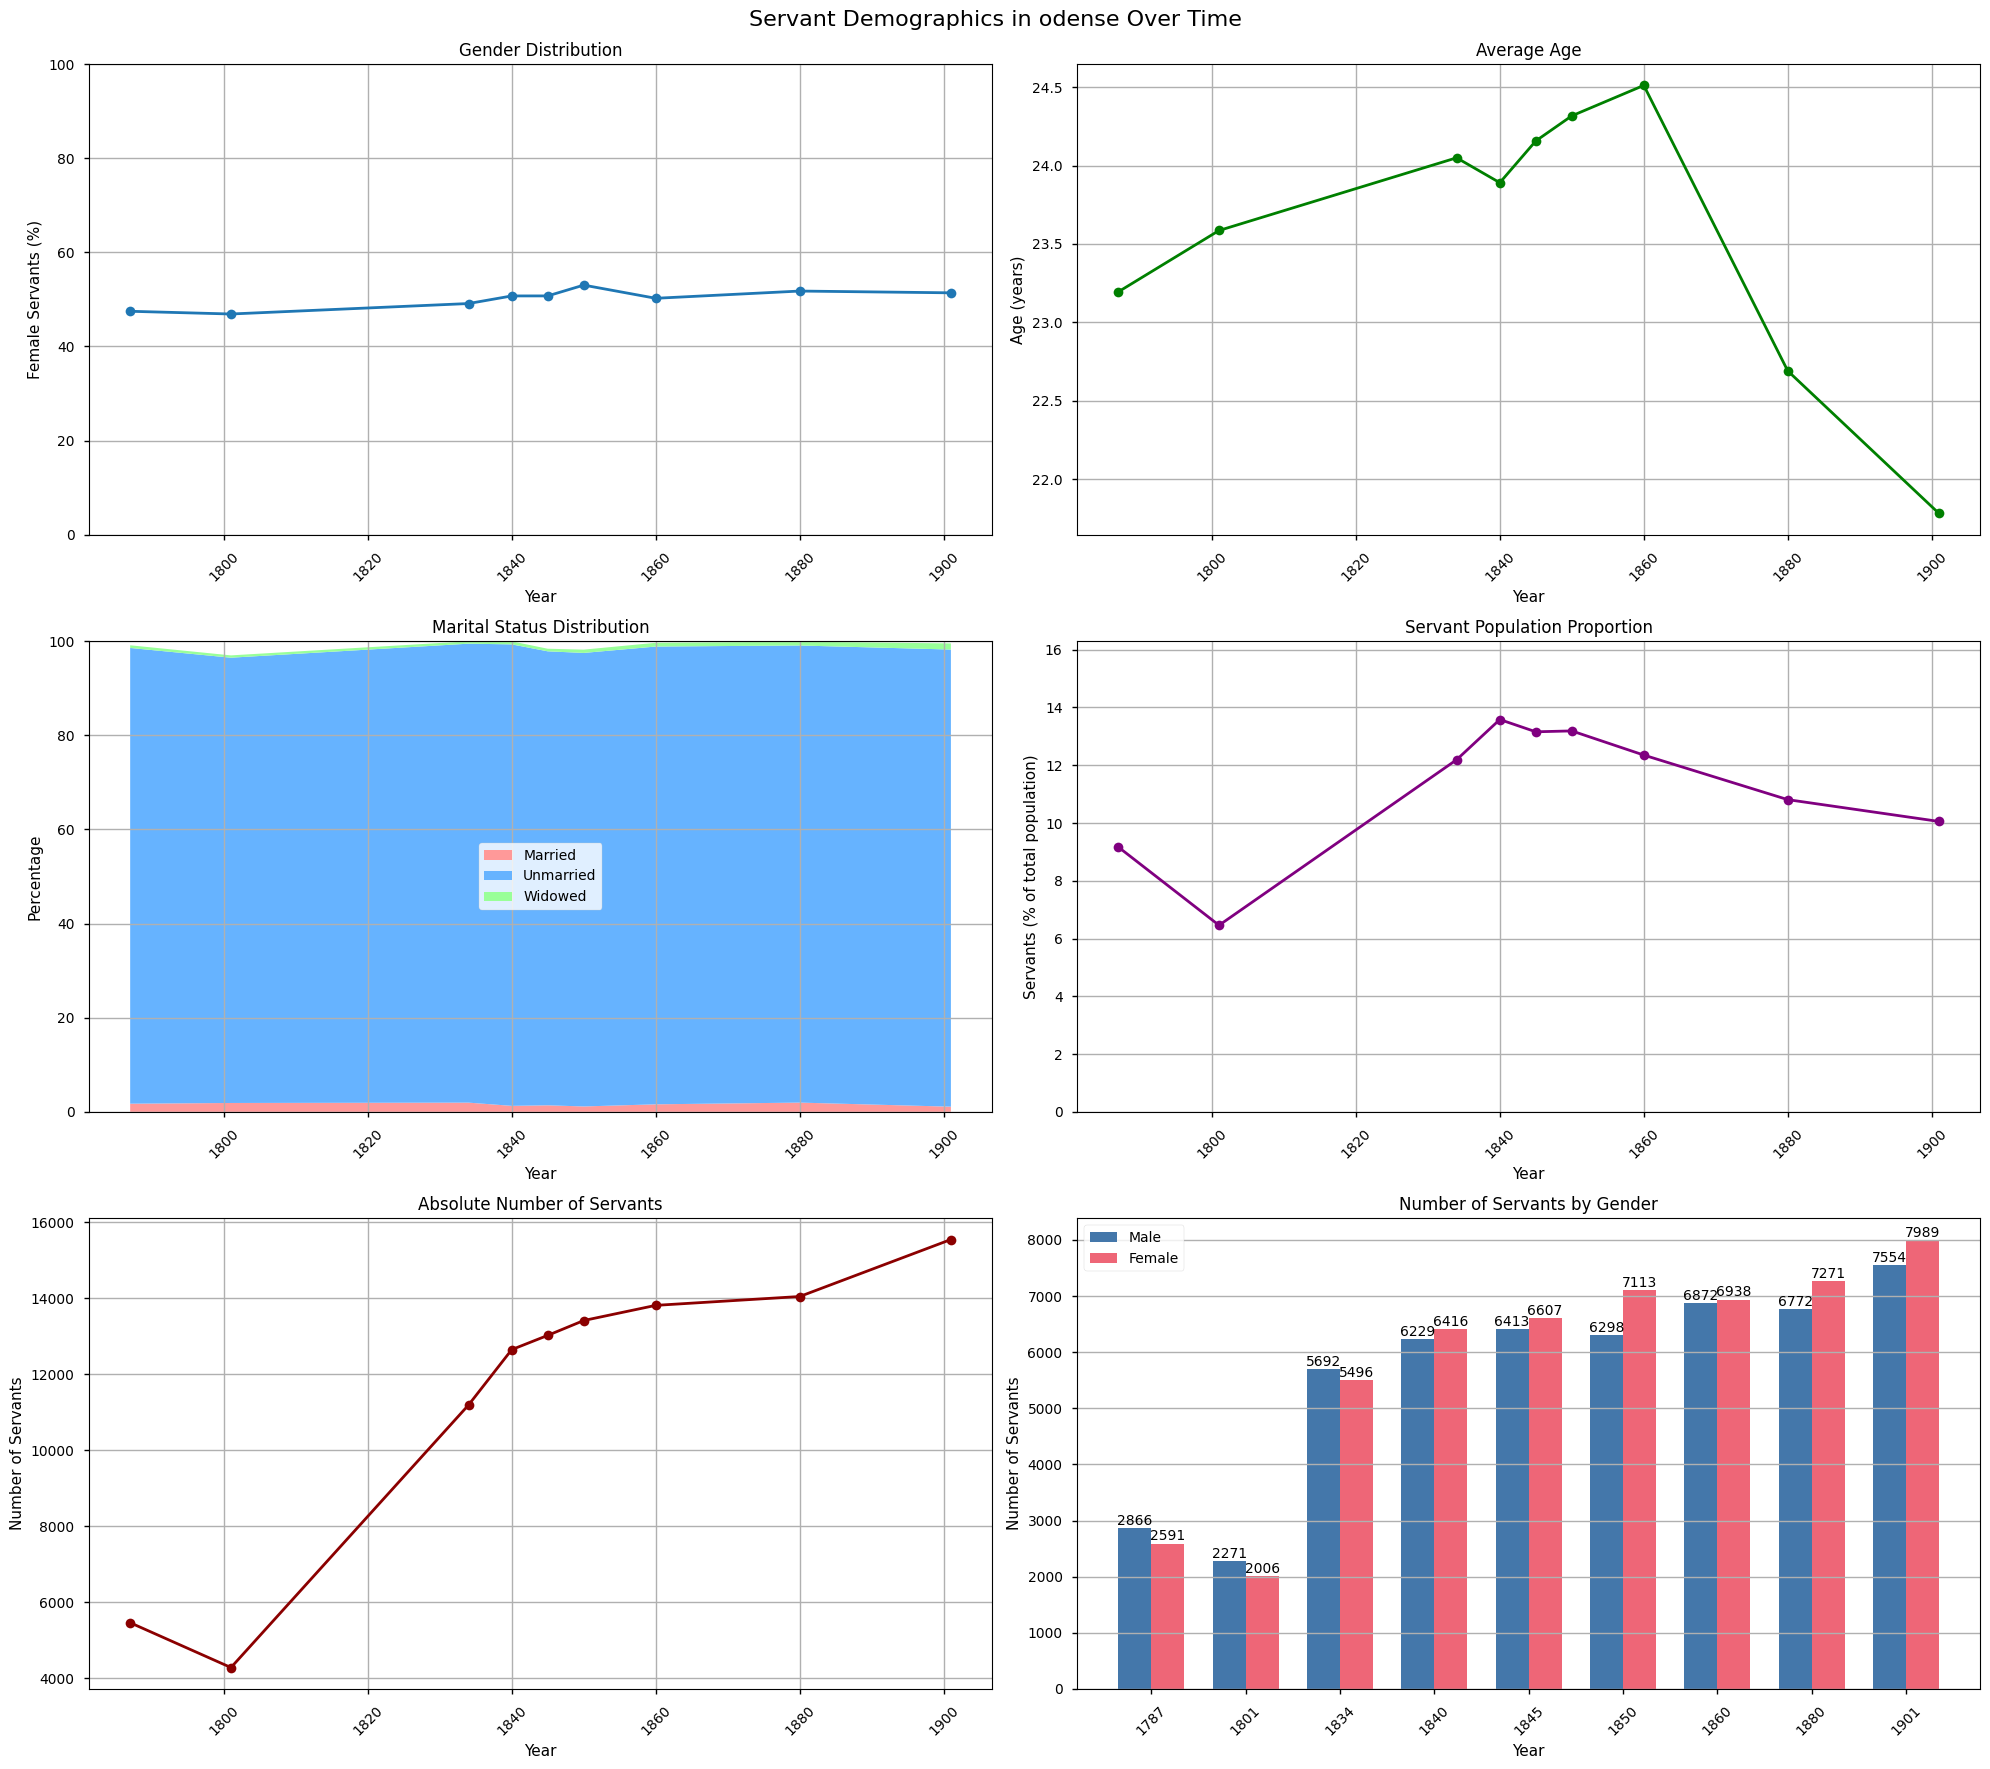


Summary Statistics for odense
Total number of servants: 103394
Total by gender: 50967 male, 52427 female
Average female ratio: 50.2%
Average age: 23.6 years
Average proportion of population: 11.2%
Average marital status distribution:
  Married: 1.6%
  Unmarried: 96.8%
  Widowed: 0.7%



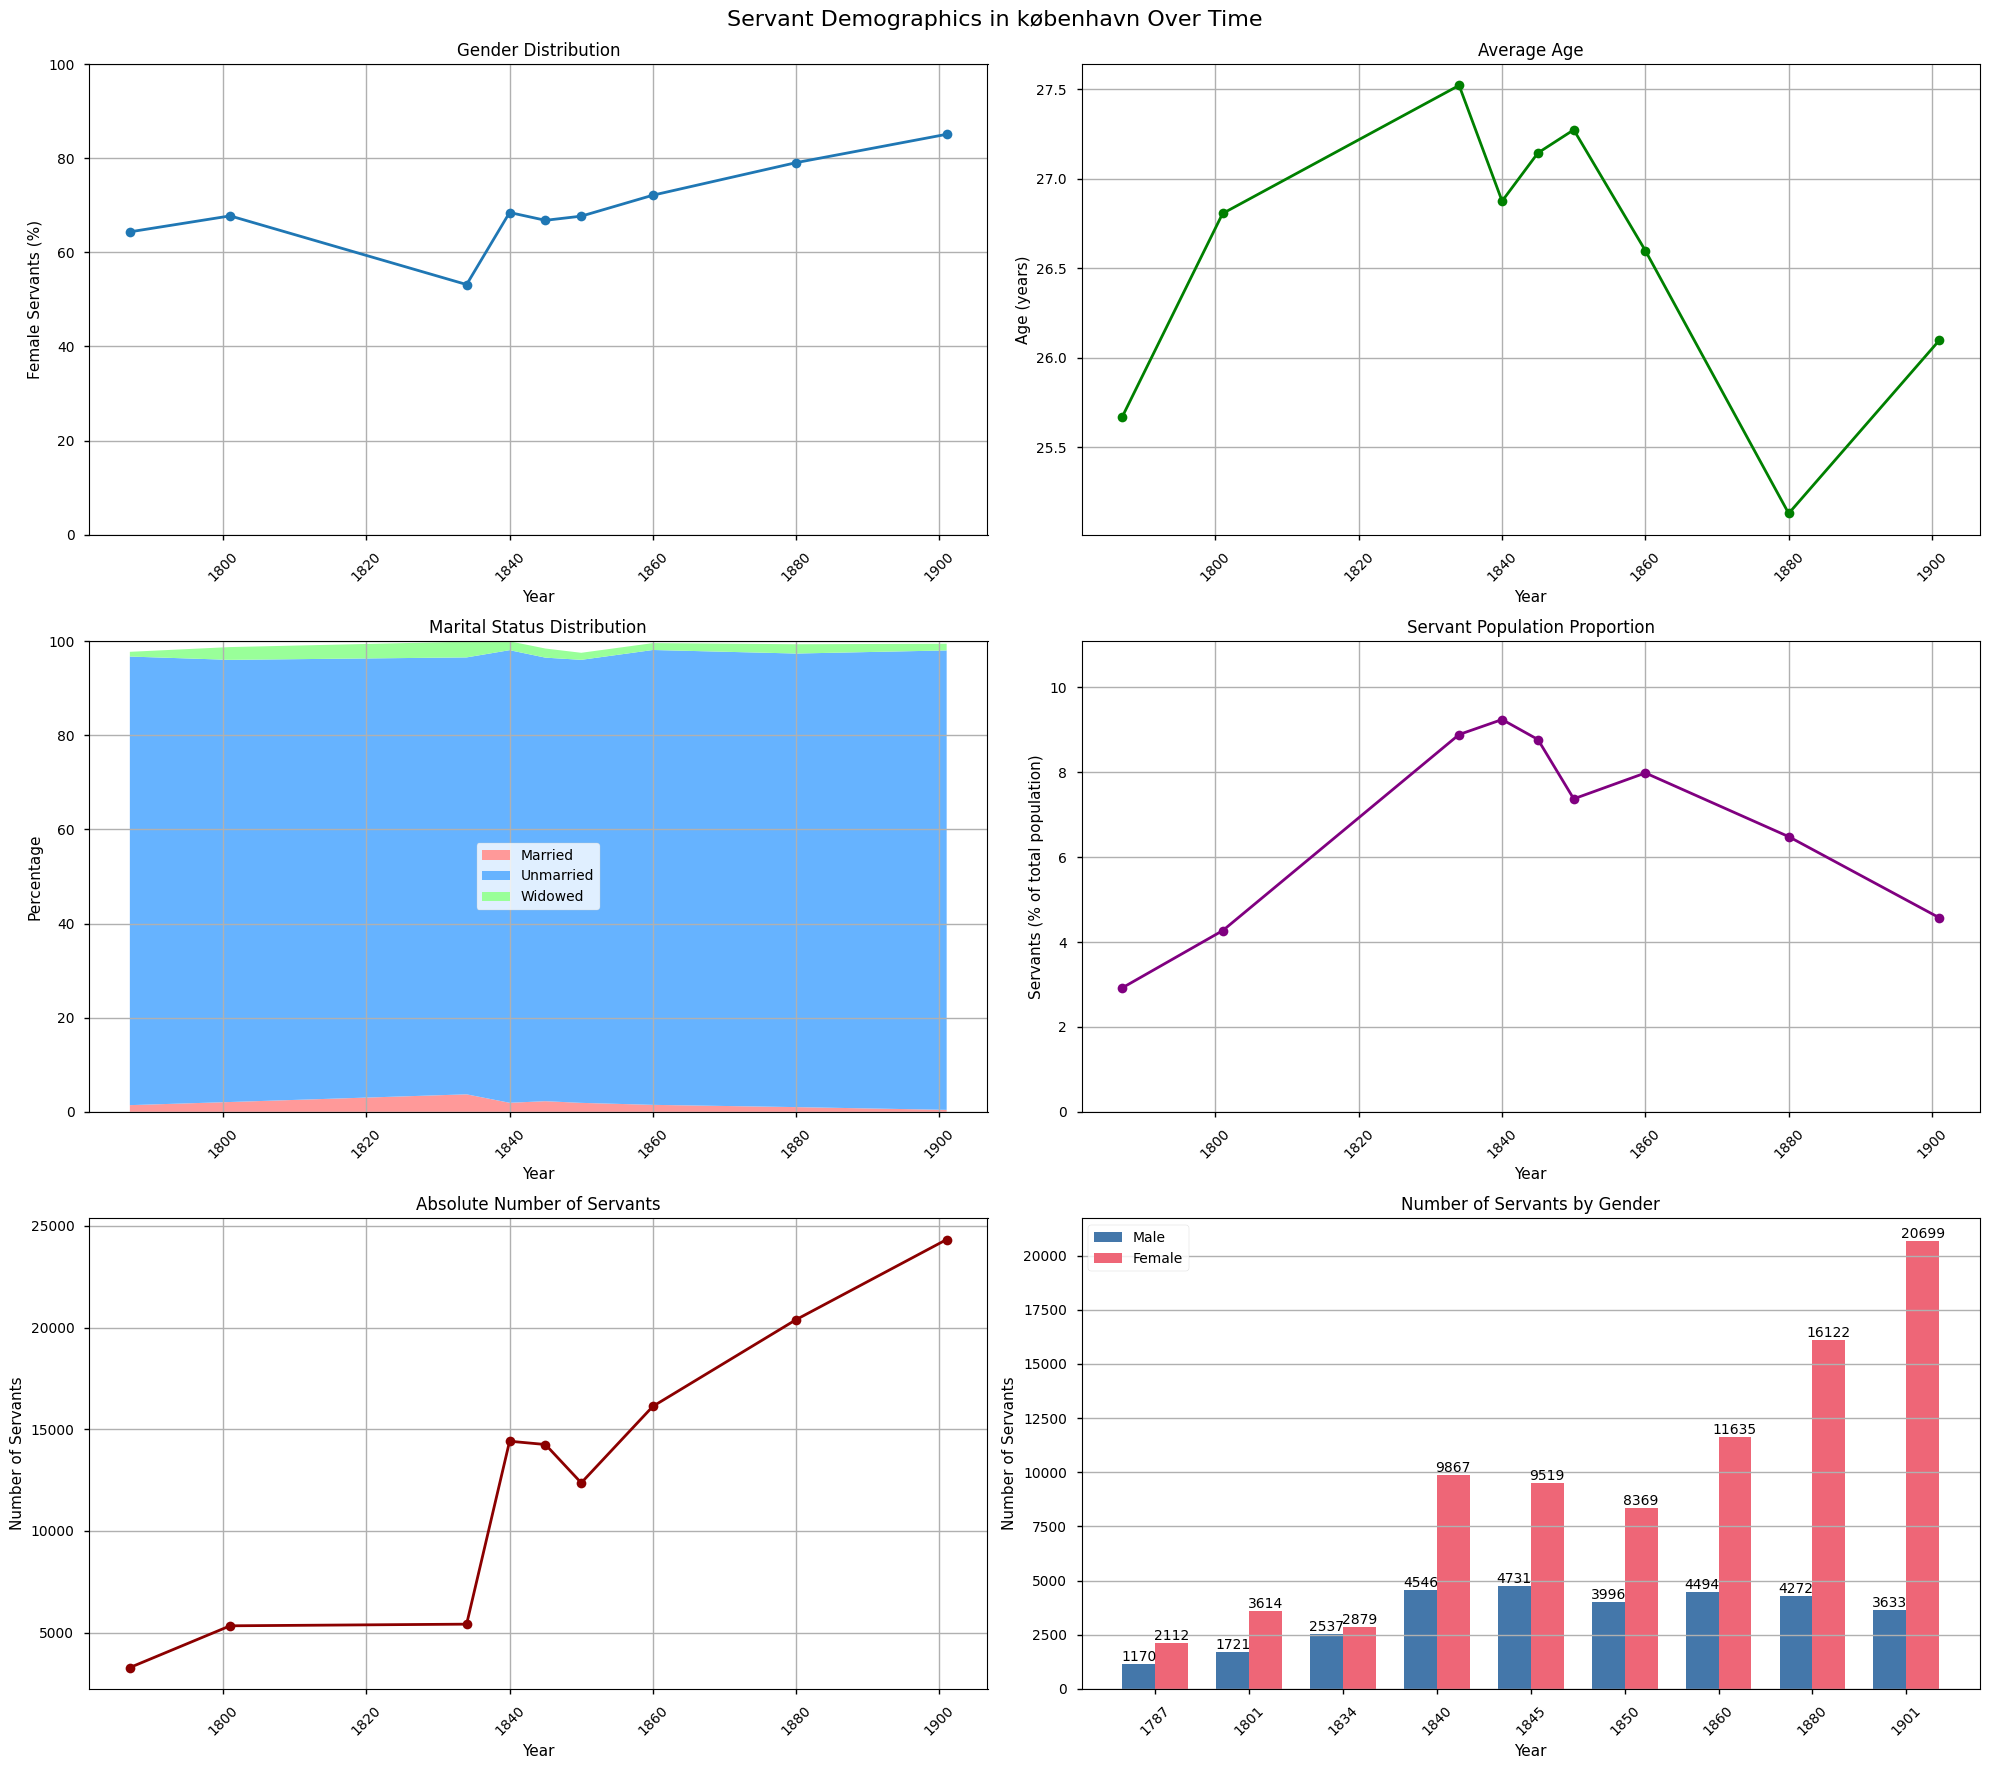


Summary Statistics for københavn
Total number of servants: 115916
Total by gender: 31100 male, 84816 female
Average female ratio: 69.4%
Average age: 26.6 years
Average proportion of population: 6.7%
Average marital status distribution:
  Married: 1.8%
  Unmarried: 95.2%
  Widowed: 1.9%




Summary Statistics for århus
Total number of servants: 42757
Total by gender: 20117 male, 22640 female
Average female ratio: 52.3%
Average age: 24.0 years
Average proportion of population: 11.0%
Average marital status distribution:
  Married: 2.0%
  Unmarried: 95.5%
  Widowed: 0.9%




Detailed Age Statistics for århus

Year: 1787
----------------------------------------
Male servants   - Median age: 24.0, IQR: 13.0
Female servants - Median age: 22.0, IQR: 8.0
Proportion under 15: 14.6% (males), 11.1% (females)
Proportion under 20: 31.2% (males), 32.6% (females)

Year: 1801
----------------------------------------
Male servants   - Median age: 24.0, IQR: 12.0
Female servants - Median age: 22.0, IQR: 8.0
Proportion under 15: 7.5% (males), 7.7% (females)
Proportion under 20: 28.4% (males), 34.3% (females)

Year: 1834
----------------------------------------
Male servants   - Median age: 24.0, IQR: 12.0
Female servants - Median age: 22.0, IQR: 8.0
Proportion under 15: 2.8% (males), 1.8% (females)
Proportion under 20: 31.7% (males), 33.6% (females)

Year: 1840
----------------------------------------
Male servants   - Median age: 23.0, IQR: 11.0
Female servants - Median age: 22.0, IQR: 7.0
Proportion under 15: 1.3% (males), 0.9% (females)
Proportion under 20: 29.8% (mal

In [25]:
def analyze_servants(df: pd.DataFrame) -> None:
    """
    Analyzes and plots servant demographics across time for each county,
    including absolute numbers and gender distribution
    """
    cleaned_df: pd.DataFrame = clean_household_data(df)
    
    # Identify servants
    servants: pd.DataFrame = cleaned_df[cleaned_df['household_position'].str.contains('tjeneste', case=False, na=False)]
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8-notebook')
    counties = servants['event_county'].unique()
    
    for county in counties:
        county_servants: pd.DataFrame = servants[servants['event_county'] == county]
        county_total: pd.DataFrame = cleaned_df[cleaned_df['event_county'] == county]
        years: list[str] = sorted(county_servants['event_year'].unique())
        
        # Initialize data storage
        gender_ratios = []
        avg_ages = []
        marital_status = []
        population_ratios = []
        absolute_counts = []  # New: Store absolute counts
        gender_counts_by_year = []  # New: Store gender counts by year
        
        # Calculate metrics for each year
        for year in years:
            year_servants = county_servants[county_servants['event_year'] == year]
            year_total = county_total[county_total['event_year'] == year]
            
            # Servant proportion of total population
            servant_ratio = len(year_servants) / len(year_total) * 100
            population_ratios.append(servant_ratio)
            
            # New: Store absolute count
            absolute_counts.append(len(year_servants))
            
            # Gender ratio (female percentage)
            gender_counts = year_servants['sex'].str.lower().value_counts()
            female_count = gender_counts.get('f', 0) + gender_counts.get('k', 0)
            male_count = gender_counts.get('m', 0)
            female_ratio = female_count / len(year_servants) * 100
            gender_ratios.append(female_ratio)
            
            # New: Store gender counts
            gender_counts_by_year.append((male_count, female_count))
            
            # Average age
            avg_ages.append(year_servants['age'].mean())
            
            # Marital status
            status_data = year_servants['marital_status'].str.lower()
            total = len(status_data)
            unmarried = status_data.str.contains('ugift', na=False).sum() / total * 100
            widow = status_data.str.contains('enke', na=False).sum() / total * 100
            married = status_data.str.match('gift', na=False).sum() / total * 100
            marital_status.append((married, unmarried, widow))
        
        # Create figure with six subplots (3x2 grid)
        fig, axes = plt.subplots(3, 2, figsize=(20, 18))
        fig.suptitle(f'Servant Demographics in {county} Over Time', fontsize=16, y=0.98)
        
        # Original plots
        # Plot 1: Gender ratio
        axes[0, 0].plot(years, gender_ratios, 'o-', linewidth=2)
        axes[0, 0].set_ylabel('Female Servants (%)')
        axes[0, 0].set_xlabel('Year')
        axes[0, 0].set_title('Gender Distribution')
        axes[0, 0].grid(True)
        axes[0, 0].set_ylim(0, 100)
        
        # Plot 2: Average age
        axes[0, 1].plot(years, avg_ages, 'o-', linewidth=2, color='green')
        axes[0, 1].set_ylabel('Age (years)')
        axes[0, 1].set_xlabel('Year')
        axes[0, 1].set_title('Average Age')
        axes[0, 1].grid(True)
        
        # Plot 3: Marital status
        married_data = [x[0] for x in marital_status]
        unmarried_data = [x[1] for x in marital_status]
        widow_data = [x[2] for x in marital_status]
        
        axes[1, 0].stackplot(years, 
                     [married_data, unmarried_data, widow_data],
                     labels=['Married', 'Unmarried', 'Widowed'],
                     colors=['#ff9999', '#66b3ff', '#99ff99'])
        axes[1, 0].set_ylabel('Percentage')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_title('Marital Status Distribution')
        axes[1, 0].grid(True)
        axes[1, 0].legend()
        axes[1, 0].set_ylim(0, 100)
        
        # Plot 4: Population proportion
        axes[1, 1].plot(years, population_ratios, 'o-', linewidth=2, color='purple')
        axes[1, 1].set_ylabel('Servants (% of total population)')
        axes[1, 1].set_xlabel('Year')
        axes[1, 1].set_title('Servant Population Proportion')
        axes[1, 1].grid(True)
        axes[1, 1].set_ylim(0, max(population_ratios) * 1.2)  # Set y-limit with 20% padding
        
        # New plots
        # Plot 5: Absolute number of servants over time
        axes[2, 0].plot(years, absolute_counts, 'o-', linewidth=2, color='darkred')
        axes[2, 0].set_ylabel('Number of Servants')
        axes[2, 0].set_xlabel('Year')
        axes[2, 0].set_title('Absolute Number of Servants')
        axes[2, 0].grid(True)
        
        # Plot 6: Gender distribution as bar plot
        male_counts = [x[0] for x in gender_counts_by_year]
        female_counts = [x[1] for x in gender_counts_by_year]
        
        bar_width = 0.35
        bar_positions = np.arange(len(years))
        
        axes[2, 1].bar(bar_positions - bar_width/2, male_counts, bar_width, 
                      label='Male', color='#4477aa')
        axes[2, 1].bar(bar_positions + bar_width/2, female_counts, bar_width, 
                      label='Female', color='#ee6677')
        
        axes[2, 1].set_ylabel('Number of Servants')
        axes[2, 1].set_xlabel('Year')
        axes[2, 1].set_title('Number of Servants by Gender')
        axes[2, 1].set_xticks(bar_positions)
        axes[2, 1].set_xticklabels(years)
        axes[2, 1].legend()
        axes[2, 1].grid(True, axis='y')
        
        # Add total count labels on top of bars
        for i, (m, f) in enumerate(zip(male_counts, female_counts)):
            axes[2, 1].text(i - bar_width/2, m + 1, str(m), ha='center', va='bottom')
            axes[2, 1].text(i + bar_width/2, f + 1, str(f), ha='center', va='bottom')
        
        # Rotate x-axis labels for better readability
        for ax in axes.flatten():
            plt.setp(ax.get_xticklabels(), rotation=45)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)  # Adjust top spacing for the suptitle
        plt.show()
        
        # Print summary statistics
        print(f"\nSummary Statistics for {county}")
        print("=" * 50)
        print(f"Total number of servants: {sum(absolute_counts)}")
        print(f"Total by gender: {sum(male_counts)} male, {sum(female_counts)} female")
        print(f"Average female ratio: {np.mean(gender_ratios):.1f}%")
        print(f"Average age: {np.mean(avg_ages):.1f} years")
        print(f"Average proportion of population: {np.mean(population_ratios):.1f}%")
        print(f"Average marital status distribution:")
        print(f"  Married: {np.mean(married_data):.1f}%")
        print(f"  Unmarried: {np.mean(unmarried_data):.1f}%")
        print(f"  Widowed: {np.mean(widow_data):.1f}%")
        print()
    
    # Additional age-related data structures
    male_age_by_year = []
    female_age_by_year = []
    age_brackets_by_year = []
    age_brackets = [(0, 14), (15, 19), (20, 29), (30, 39), (40, 100)]
    bracket_labels = ['<15', '15-19', '20-29', '30-39', '40+']
    
    # Calculate metrics for each year
    for year in years:
        year_servants = county_servants[county_servants['event_year'] == year]
        # [Keep your existing calculations]
        
        # Store age data by gender
        males = year_servants[year_servants['sex'].str.lower() == 'm']
        females = year_servants[year_servants['sex'].str.lower().isin(['f', 'k'])]
        
        male_age_by_year.append(males['age'].dropna().values)
        female_age_by_year.append(females['age'].dropna().values)
        
        # Calculate age bracket distributions
        year_brackets = []
        for gender_df in [males, females]:
            bracket_counts = []
            for min_age, max_age in age_brackets:
                count = len(gender_df[(gender_df['age'] >= min_age) & (gender_df['age'] <= max_age)])
                bracket_counts.append(count)
            year_brackets.append(bracket_counts)
        age_brackets_by_year.append(year_brackets)
    
    # [Keep your original plotting code]
    
    # Now add more sophisticated age visualizations
    fig2, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig2.suptitle(f'Age Distribution Analysis of Servants in {county}', fontsize=16, y=0.98)
    
    # Plot 1: Box plots of age by gender over time
    ax1 = axes[0, 0]
    
    # Create positions for box plots
    positions = []
    box_labels = []
    for i, year in enumerate(years):
        positions.extend([i*3 + 1, i*3 + 2])  # Male, then female position
        box_labels.extend([f"{year} M", f"{year} F"])
    
    # Create box plot data
    box_data = []
    for male_ages, female_ages in zip(male_age_by_year, female_age_by_year):
        box_data.append(male_ages)
        box_data.append(female_ages)
    
    # Plot box plots
    bplot = ax1.boxplot(box_data, positions=positions, patch_artist=True, 
                      widths=0.6, showfliers=False)
    
    # Color boxes by gender
    for i, box in enumerate(bplot['boxes']):
        if i % 2 == 0:  # Males (even indices)
            box.set(facecolor='#4477aa', alpha=0.7)
        else:  # Females (odd indices)
            box.set(facecolor='#ee6677', alpha=0.7)
    
    ax1.set_title('Age Distribution by Gender and Year')
    ax1.set_ylabel('Age (years)')
    ax1.set_xticks(np.array(range(len(box_labels)))*1.5)
    ax1.set_xticklabels(box_labels, rotation=45)
    ax1.grid(True, axis='y')
    
    # Add a legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#4477aa', alpha=0.7, label='Male'),
        Patch(facecolor='#ee6677', alpha=0.7, label='Female')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    # Plot 2: Age bracket distribution over time (stacked area chart) - Males
    ax2 = axes[0, 1]
    male_brackets = np.array([[year_data[0][i] for year_data in age_brackets_by_year] 
                            for i in range(len(age_brackets))])
    
    # Convert to percentages
    male_totals = male_brackets.sum(axis=0)
    male_pcts = np.zeros_like(male_brackets, dtype=float)
    for i in range(len(male_brackets)):
        male_pcts[i] = male_brackets[i] / male_totals * 100 if i < len(male_brackets) else 0
    
    # Plot stacked area chart
    ax2.stackplot(years, male_pcts, labels=bracket_labels, 
                 colors=plt.cm.viridis(np.linspace(0, 0.8, len(age_brackets))))
    ax2.set_title('Male Servants Age Distribution')
    ax2.set_ylabel('Percentage')
    ax2.set_xlabel('Year')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    ax2.set_ylim(0, 100)
    
    # Plot 3: Age bracket distribution over time (stacked area chart) - Females
    ax3 = axes[1, 0]
    female_brackets = np.array([[year_data[1][i] for year_data in age_brackets_by_year] 
                              for i in range(len(age_brackets))])
    
    # Convert to percentages
    female_totals = female_brackets.sum(axis=0)
    female_pcts = np.zeros_like(female_brackets, dtype=float)
    for i in range(len(female_brackets)):
        female_pcts[i] = female_brackets[i] / female_totals * 100 if i < len(female_brackets) else 0
    
    # Plot stacked area chart
    ax3.stackplot(years, female_pcts, labels=bracket_labels, 
                 colors=plt.cm.viridis(np.linspace(0, 0.8, len(age_brackets))))
    ax3.set_title('Female Servants Age Distribution')
    ax3.set_ylabel('Percentage')
    ax3.set_xlabel('Year')
    ax3.legend(loc='upper right')
    ax3.grid(True)
    ax3.set_ylim(0, 100)
    
    # Plot 4: Age distribution comparison (violin plots) for selected years
    ax4 = axes[1, 1]
    
    # Select a subset of years if there are many
    if len(years) > 4:
        selected_indices = np.linspace(0, len(years)-1, 4, dtype=int)
    else:
        selected_indices = range(len(years))
    
    selected_years = [years[i] for i in selected_indices]
    
    # Create violin plot data and positions
    violin_data = []
    violin_positions = []
    violin_labels = []
    
    for pos, idx in enumerate(selected_indices):
        # Male data for this year
        violin_data.append(male_age_by_year[idx])
        violin_positions.append(pos*2)
        violin_labels.append(f"M {selected_years[pos]}")
        
        # Female data for this year
        violin_data.append(female_age_by_year[idx])
        violin_positions.append(pos*2 + 0.8)
        violin_labels.append(f"F {selected_years[pos]}")
    
    # Plot violin plots
    violin_parts = ax4.violinplot(violin_data, positions=violin_positions, 
                                widths=0.7, showmeans=True)
    
    # Customize violin plots
    for i, pc in enumerate(violin_parts['bodies']):
        if i % 2 == 0:  # Males
            pc.set_facecolor('#4477aa')
            pc.set_alpha(0.7)
        else:  # Females
            pc.set_facecolor('#ee6677')
            pc.set_alpha(0.7)
    
    # Set violin plot styling
    ax4.set_title('Age Distribution Comparison for Selected Years')
    ax4.set_ylabel('Age (years)')
    ax4.set_xticks(violin_positions)
    ax4.set_xticklabels(violin_labels, rotation=45)
    ax4.grid(True, axis='y')
    
    # Add horizontal lines for typical working age ranges
    ax4.axhline(y=15, color='gray', linestyle='--', alpha=0.5)
    ax4.axhline(y=30, color='gray', linestyle='--', alpha=0.5)
    ax4.text(max(violin_positions), 15, 'Age 15', ha='right', va='bottom', alpha=0.7)
    ax4.text(max(violin_positions), 30, 'Age 30', ha='right', va='bottom', alpha=0.7)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # Additional analysis: Calculate and print age statistics
    print(f"\nDetailed Age Statistics for {county}")
    print("=" * 60)
    
    for i, year in enumerate(years):
        m_ages = male_age_by_year[i]
        f_ages = female_age_by_year[i]
        
        if len(m_ages) > 0 and len(f_ages) > 0:
            print(f"\nYear: {year}")
            print("-" * 40)
            print(f"Male servants   - Median age: {np.median(m_ages):.1f}, IQR: {np.percentile(m_ages, 75) - np.percentile(m_ages, 25):.1f}")
            print(f"Female servants - Median age: {np.median(f_ages):.1f}, IQR: {np.percentile(f_ages, 75) - np.percentile(f_ages, 25):.1f}")
            
            # Calculate proportion under certain ages
            male_under_15 = np.sum(m_ages < 15) / len(m_ages) * 100
            female_under_15 = np.sum(f_ages < 15) / len(f_ages) * 100
            male_under_20 = np.sum(m_ages < 20) / len(m_ages) * 100
            female_under_20 = np.sum(f_ages < 20) / len(f_ages) * 100
            
            print(f"Proportion under 15: {male_under_15:.1f}% (males), {female_under_15:.1f}% (females)")
            print(f"Proportion under 20: {male_under_20:.1f}% (males), {female_under_20:.1f}% (females)")

# Run the analysis
analyze_servants(combined_df)

Analyzing københavn...


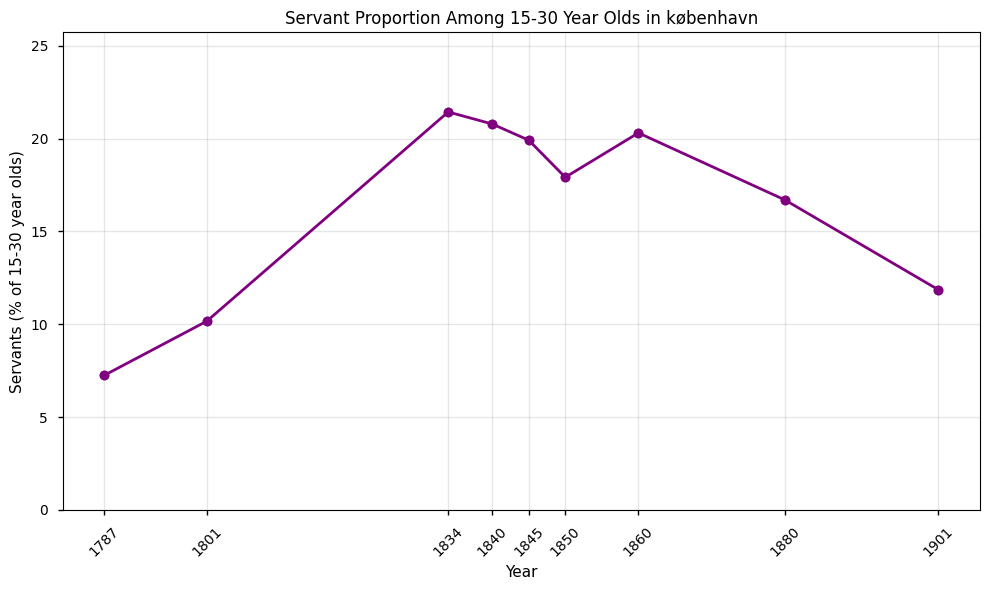

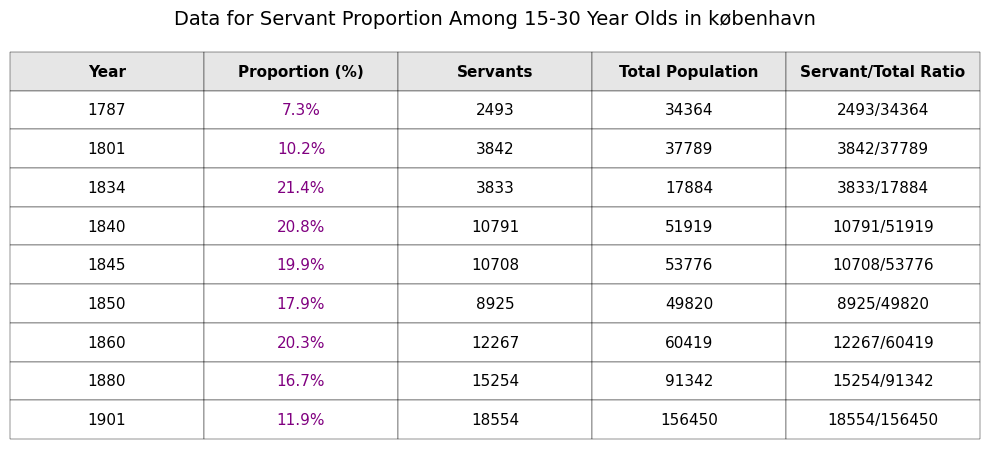


Servant Proportion Statistics for københavn
Age group analyzed: 15-30 years
Average proportion of 15-30 year olds who were servants: 16.3%
Minimum proportion: 7.3% (Year 1787)
Maximum proportion: 21.4% (Year 1834)

Detailed yearly breakdown in table above

Analyzing århus...


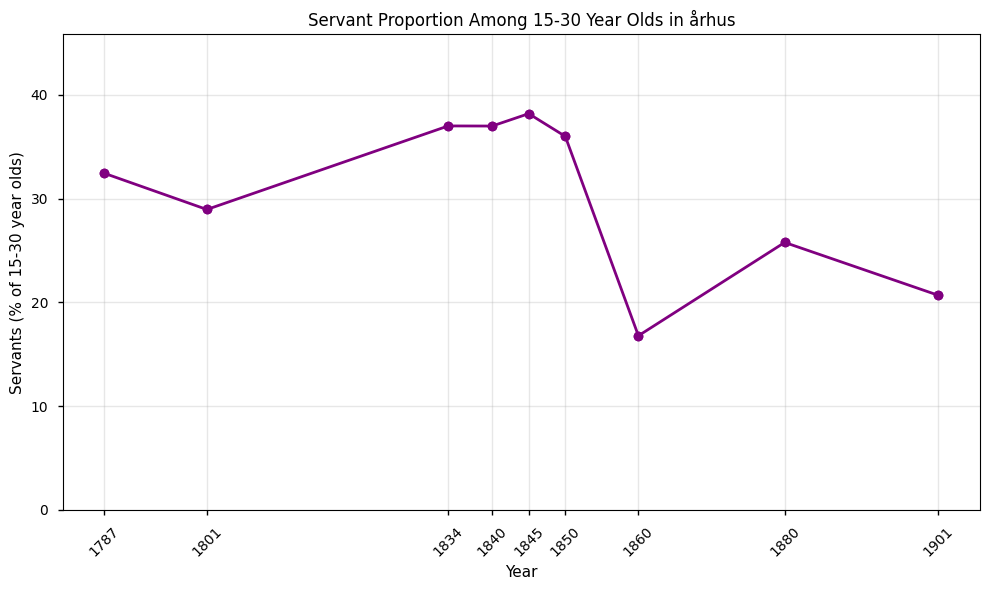

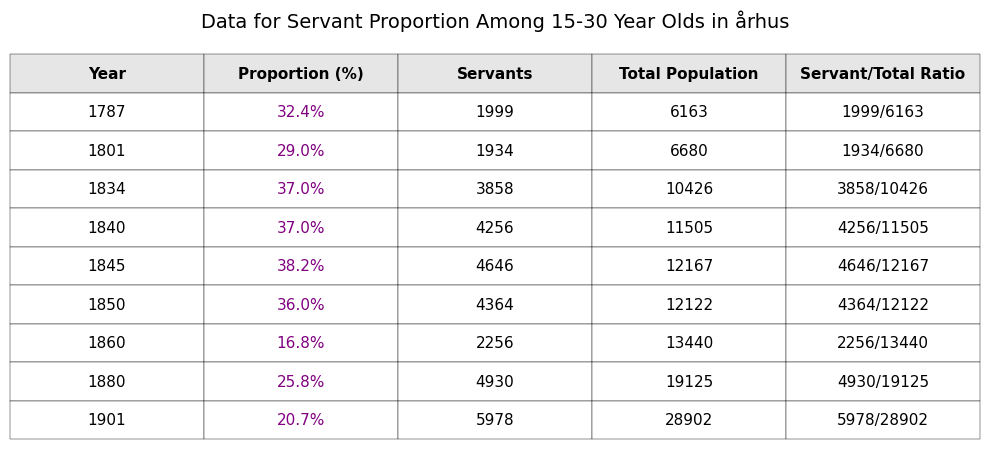


Servant Proportion Statistics for århus
Age group analyzed: 15-30 years
Average proportion of 15-30 year olds who were servants: 30.3%
Minimum proportion: 16.8% (Year 1860)
Maximum proportion: 38.2% (Year 1845)

Detailed yearly breakdown in table above

Analyzing odense...


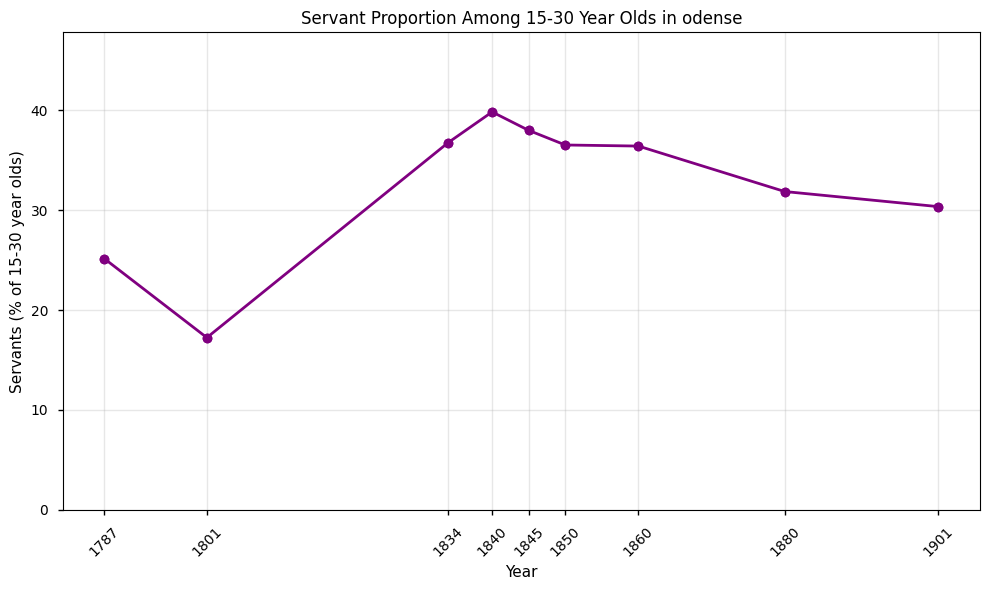

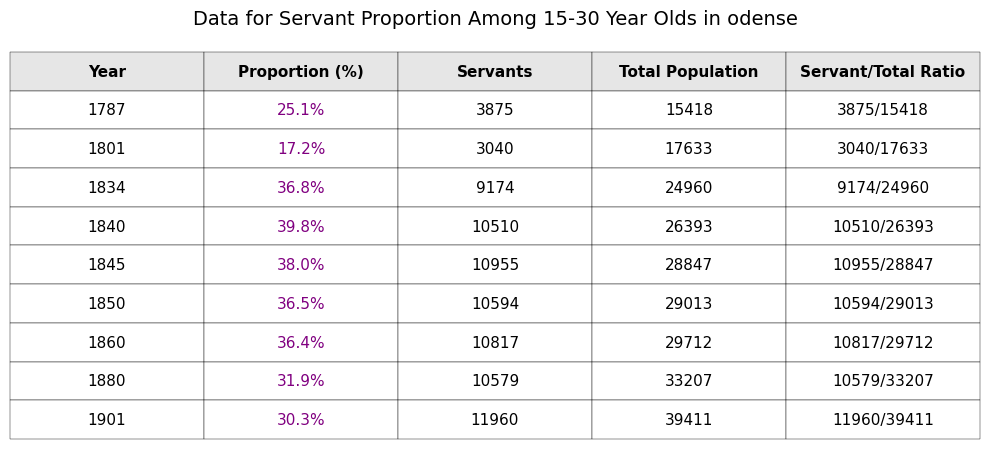


Servant Proportion Statistics for odense
Age group analyzed: 15-30 years
Average proportion of 15-30 year olds who were servants: 32.5%
Minimum proportion: 17.2% (Year 1801)
Maximum proportion: 39.8% (Year 1840)

Detailed yearly breakdown in table above



In [22]:
def analyze_servants_proportion_by_age(
    df: pd.DataFrame,
    min_age: int = 15,
    max_age: int = 30
) -> None:
    """
    Analyzes and plots the proportion of servants within a specified age group
    across time for each county
    
    Args:
        df: DataFrame containing census data with household information
        min_age: Minimum age for the analysis (inclusive)
        max_age: Maximum age for the analysis (inclusive)
    """
    cleaned_df: pd.DataFrame = clean_household_data(df)
    
    # Identify servants
    servants: pd.DataFrame = cleaned_df[cleaned_df['household_position'].str.contains('tjeneste', case=False, na=False)]
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8-notebook')
    counties = servants['event_county'].unique()
    
    for county in counties:
        county_servants: pd.DataFrame = servants[servants['event_county'] == county]
        county_total: pd.DataFrame = cleaned_df[cleaned_df['event_county'] == county]
        years: list[int] = sorted(county_servants['event_year'].unique())
        
        # Initialize data storage
        age_group_ratios: list[float] = []
        total_in_age_group: list[int] = []
        servants_in_age_group: list[int] = []
        
        # Calculate metrics for each year
        for year in years:
            year_servants = county_servants[county_servants['event_year'] == year]
            year_total = county_total[county_total['event_year'] == year]
            
            # Filter specified age range in both populations
            age_range_servants = year_servants[(year_servants['age'] >= min_age) & (year_servants['age'] <= max_age)]
            age_range_population = year_total[(year_total['age'] >= min_age) & (year_total['age'] <= max_age)]
            
            # Store counts for reference
            servants_count = len(age_range_servants)
            population_count = len(age_range_population)
            
            servants_in_age_group.append(servants_count)
            total_in_age_group.append(population_count)
            
            # Servant proportion of specified age group
            if population_count > 0:  # Avoid division by zero
                age_group_ratio = servants_count / population_count * 100
            else:
                age_group_ratio = 0
                
            age_group_ratios.append(age_group_ratio)
        
        # FIGURE 1: Line chart for proportion
        plt.figure(figsize=(10, 6))
        
        # Main plot: Proportion of servants in age group
        plt.plot(years, age_group_ratios, 'o-', linewidth=2, color='purple')
        
        # Add data points with values
        for i, (x, y) in enumerate(zip(years, age_group_ratios)):
            plt.plot(x, y, 'o', markersize=7, color='purple')
        
        # Set axis labels and title
        plt.ylabel(f'Servants (% of {min_age}-{max_age} year olds)')
        plt.xlabel('Year')
        plt.title(f'Servant Proportion Among {min_age}-{max_age} Year Olds in {county}')
        plt.grid(True, alpha=0.3)
        
        # Set y-axis limits with some padding
        max_ratio = max(age_group_ratios) if age_group_ratios and max(age_group_ratios) > 0 else 10
        plt.ylim(0, max_ratio * 1.2)
        
        # Set x-axis to only show years with data
        plt.xticks(years, rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # FIGURE 2: Data table
        # Create a DataFrame for better table visualization
        table_df = pd.DataFrame({
            'Year': years,
            'Proportion (%)': [f"{ratio:.1f}%" for ratio in age_group_ratios],
            'Servants': servants_in_age_group,
            'Total Population': total_in_age_group,
            'Servant/Total Ratio': [f"{s}/{t}" for s, t in zip(servants_in_age_group, total_in_age_group)]
        })
        
        # Create figure for the table
        fig, ax = plt.subplots(figsize=(10, len(years) * 0.4 + 1))  # Adjust height based on number of rows
        ax.axis('off')
        
        # Create table
        table = ax.table(
            cellText=table_df.values,
            colLabels=table_df.columns,
            cellLoc='center',
            loc='center',
            bbox=[0, 0, 1, 1]  # Use the full axis
        )
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1.2, 1.5)  # Adjust width and height
        
        # Style header and cells
        for (row, col), cell in table.get_celld().items():
            if row == 0:  # Header row
                cell.set_text_props(weight='bold')
                cell.set_facecolor('#E6E6E6')
            elif col == 1:  # Proportion column
                cell.set_text_props(color='purple')
        
        plt.title(f"Data for Servant Proportion Among {min_age}-{max_age} Year Olds in {county}", 
                  pad=20, fontsize=14)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\nServant Proportion Statistics for {county}")
        print("=" * 50)
        print(f"Age group analyzed: {min_age}-{max_age} years")
        print(f"Average proportion of {min_age}-{max_age} year olds who were servants: {np.mean(age_group_ratios):.1f}%")
        print(f"Minimum proportion: {min(age_group_ratios):.1f}% (Year {years[age_group_ratios.index(min(age_group_ratios))]})")
        print(f"Maximum proportion: {max(age_group_ratios):.1f}% (Year {years[age_group_ratios.index(max(age_group_ratios))]})")
        print("\nDetailed yearly breakdown in table above")
        print()

# Process each county dataframe separately
for df, county_name in zip(df_list, county_names):
    print(f"Analyzing {county_name}...")
    analyze_servants_proportion_by_age(df, min_age=15, max_age=30)